<a href="https://colab.research.google.com/github/Md-Sanzid-Bin-Hossain/UCF-WSI-Dataset/blob/main/UCF_WSI_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import seaborn as sns
import os
import time
import random
import json
import pandas as pd
from collections import Counter
from torchvision.models.swin_transformer import swin_t  # Import Swin Transformer

In [ ]:
# Set random seed for reproducibility
random_state = 42
random.seed(random_state)

model_name='efficientnet_b0_15_class'

In [ ]:
path='/home/jupyter/Patch_extraction/'
base = '/home/jupyter/Patch_extraction/'
results_path='/home/jupyter/Result_summary/'

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
def patch_selection(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))

           # Randomly select 100 images if there are more than 100
            # if len(files1) > 100:
            #     selected_files = random.sample(files1, 100)
            # else:
            selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [ ]:
def patch_selection_expanded_test(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))

            # Randomly select 100 images if there are more than 100
            if len(files1) > 100:
                selected_files = random.sample(files1, 100)
            else:
                selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids


In [ ]:
# Set random seed for reproducibility
random_state = 42
random.seed(random_state)

train_patch_ids = []
train_labels = []
train_slide_ids = []

val_patch_ids = []
val_labels = []
val_slide_ids = []

test_patch_ids = []
test_labels = []
test_slide_ids = []

expanded_test_patch_ids = []
expanded_test_labels = []
expanded_test_slide_ids = []

# Lists to store slide IDs with their class labels
train_slide_info = []
val_slide_info = []
test_slide_info = []
expanded_test_slide_info = []

for i in range(0, 15):
    # List all file IDs in the directory
    ids = os.listdir(base + '/' + str(i) + '/')
    ids_1 = ids

    # Ensure at most 15 slides are selected
    if len(ids) > 15:
        ids = random.sample(ids, 15)

    print(len(ids))

    # Split the IDs into training, validation, and test sets
    train_ids_1, test_ids = train_test_split(ids, test_size=0.30, random_state=42)
    train_ids, val_ids = train_test_split(train_ids_1, test_size=0.20, random_state=42)

    # Get expanded test slides
    selected_ids = set(train_ids + val_ids)
    expanded_test_ids = [id_ for id_ in ids_1 if id_ not in selected_ids]



    # Assuming patch_selection function selects patches from given ids and class index
    train_patch_id, train_label, train_slide_id = patch_selection(train_ids, i)
    val_patch_id, val_label, val_slide_id = patch_selection(val_ids, i)
    test_patch_id, test_label, test_slide_id = patch_selection(test_ids, i)
    expanded_test_patch_id, expanded_test_label, expanded_test_slide_id = patch_selection_expanded_test(expanded_test_ids, i)

    train_patch_ids.extend(train_patch_id)
    train_labels.extend(train_label)
    train_slide_ids.extend(train_slide_id)

    val_patch_ids.extend(val_patch_id)
    val_labels.extend(val_label)
    val_slide_ids.extend(val_slide_id)

    test_patch_ids.extend(test_patch_id)
    test_labels.extend(test_label)
    test_slide_ids.extend(test_slide_id)

    expanded_test_patch_ids.extend(expanded_test_patch_id)
    expanded_test_labels.extend(expanded_test_label)
    expanded_test_slide_ids.extend(expanded_test_slide_id)

    # Add slide IDs and their class labels to the respective lists
    train_slide_info.extend([(id_, i) for id_ in train_ids])
    val_slide_info.extend([(id_, i) for id_ in val_ids])
    test_slide_info.extend([(id_, i) for id_ in test_ids])
    expanded_test_slide_info.extend([(id_, i) for id_ in expanded_test_ids])

# Convert to DataFrame
train_df = pd.DataFrame(train_slide_info, columns=['Slide ID', 'Class'])
val_df = pd.DataFrame(val_slide_info, columns=['Slide ID', 'Class'])
test_df = pd.DataFrame(test_slide_info, columns=['Slide ID', 'Class'])
expanded_test_df = pd.DataFrame(expanded_test_slide_info, columns=['Slide ID', 'Class'])

# Save to CSV files
train_df.to_csv(results_path+'train_slide_ids.csv', index=False)
val_df.to_csv(results_path+'val_slide_ids.csv', index=False)
test_df.to_csv(results_path+'test_slide_ids.csv', index=False)
expanded_test_df.to_csv(results_path+'expanded_test_slide_ids.csv', index=False)

# Save to JSON files
train_df.to_json(results_path+'train_slide_ids.json', orient='records', lines=True)
val_df.to_json(results_path+'val_slide_ids.json', orient='records', lines=True)
test_df.to_json(results_path+'test_slide_ids.json', orient='records', lines=True)
expanded_test_df.to_json(results_path+'expanded_test_slide_ids.json', orient='records', lines=True)

# Print some results to verify
print(f"Total training patches: {len(train_patch_ids)}")
print(f"Total validation patches: {len(val_patch_ids)}")
print(f"Total testing patches: {len(test_patch_ids)}")
print(f"Total expanded test patches: {len(expanded_test_patch_ids)}")


15


100%|██████████| 374/374 [00:00<00:00, 962.29it/s]


15


100%|██████████| 79/79 [00:00<00:00, 481.17it/s]


15


100%|██████████| 82/82 [00:00<00:00, 575.21it/s]


15


100%|██████████| 29/29 [00:00<00:00, 470.82it/s]


15


100%|██████████| 14/14 [00:00<00:00, 531.10it/s]


15


100%|██████████| 18/18 [00:00<00:00, 730.27it/s]


15


100%|██████████| 47/47 [00:00<00:00, 500.40it/s]


15


100%|██████████| 57/57 [00:00<00:00, 2184.23it/s]


15


100%|██████████| 19/19 [00:00<00:00, 798.37it/s]


15


100%|██████████| 102/102 [00:00<00:00, 547.28it/s]


9


100%|██████████| 3/3 [00:00<00:00, 552.49it/s]


7


100%|██████████| 3/3 [00:00<00:00, 574.40it/s]


15


100%|██████████| 9/9 [00:00<00:00, 712.35it/s]


10


100%|██████████| 3/3 [00:00<00:00, 675.59it/s]


11


100%|██████████| 4/4 [00:00<00:00, 773.21it/s]


Total training patches: 301376
Total validation patches: 79799
Total testing patches: 184886
Total expanded test patches: 83923


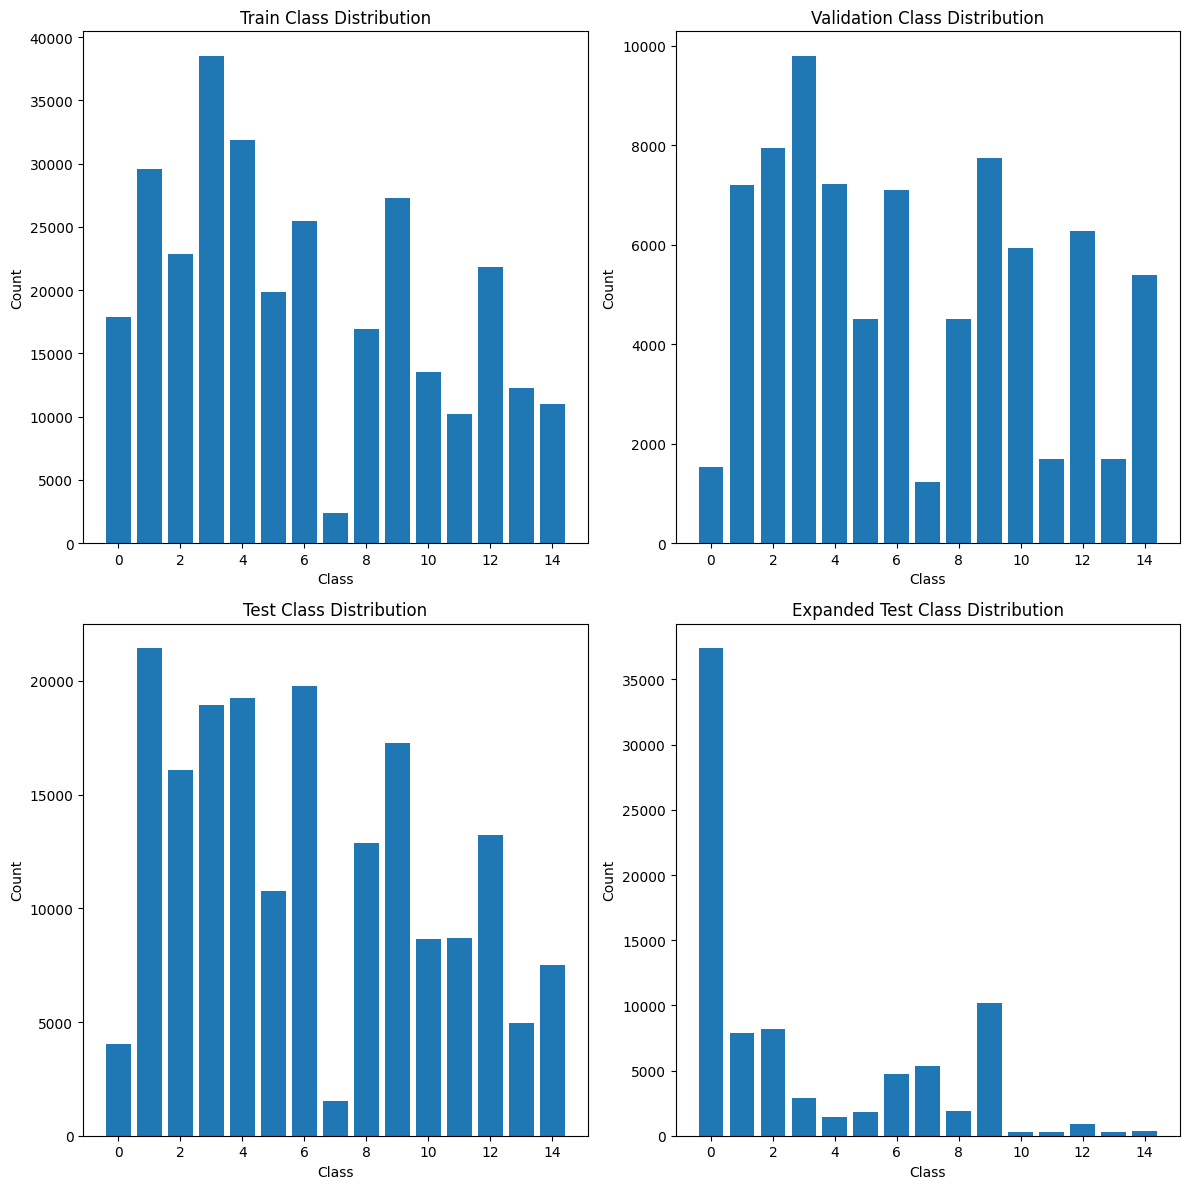

Train class distribution: [17856. 29546. 22858. 38534. 31848. 19839. 25455.  2406. 16952. 27267.
 13530. 10179. 21864. 12248. 10994.]
Validation class distribution: [1533. 7209. 7949. 9803. 7223. 4502. 7097. 1223. 4502. 7739. 5945. 1701.
 6288. 1685. 5400.]
Test class distribution: [ 4013. 21435. 16074. 18933. 19231. 10772. 19792.  1536. 12852. 17250.
  8642.  8676. 13205.  4951.  7524.]
Expanded Test class distribution: [37400.  7900.  8200.  2900.  1400.  1800.  4700.  5323.  1900. 10200.
   300.   300.   900.   300.   400.]


In [ ]:
def get_class_distribution_from_filenames(filenames, custom_classes):
    class_counts = np.zeros(len(custom_classes))
    class_map = {cls: idx for idx, cls in enumerate(custom_classes)}

    for filename in filenames:
        # Extract class label from the directory name
        class_label = int(os.path.basename(os.path.dirname(os.path.dirname(filename))))
        if class_label in class_map:
            class_counts[class_map[class_label]] += 1

    return class_counts

# Define your custom range of class labels
custom_range = list(range(0, 15))

# Assuming train_patch_ids, val_patch_ids, test_patch_ids, and expanded_test_patch_ids are lists of image paths
train_class_distribution = get_class_distribution_from_filenames(train_patch_ids, custom_range)
val_class_distribution = get_class_distribution_from_filenames(val_patch_ids, custom_range)
test_class_distribution = get_class_distribution_from_filenames(test_patch_ids, custom_range)
expanded_test_class_distribution = get_class_distribution_from_filenames(expanded_test_patch_ids, custom_range)

# Plotting class distributions
classes = np.array(custom_range)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.bar(classes, train_class_distribution)
plt.title('Train Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
plt.bar(classes, val_class_distribution)
plt.title('Validation Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
plt.bar(classes, test_class_distribution)
plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.bar(classes, expanded_test_class_distribution)
plt.title('Expanded Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print distributions as arrays
print("Train class distribution:", train_class_distribution)
print("Validation class distribution:", val_class_distribution)
print("Test class distribution:", test_class_distribution)
print("Expanded Test class distribution:", expanded_test_class_distribution)

# Save distributions to CSV
output_folder = 'Result_summary'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

distribution_data = {
    'Class': classes,
    'Train': train_class_distribution,
    'Validation': val_class_distribution,
    'Test': test_class_distribution,
    'Expanded Test': expanded_test_class_distribution
}

distribution_df = pd.DataFrame(distribution_data)
distribution_df.to_csv(os.path.join(output_folder, 'Patches_class_distributions.csv'), index=False)

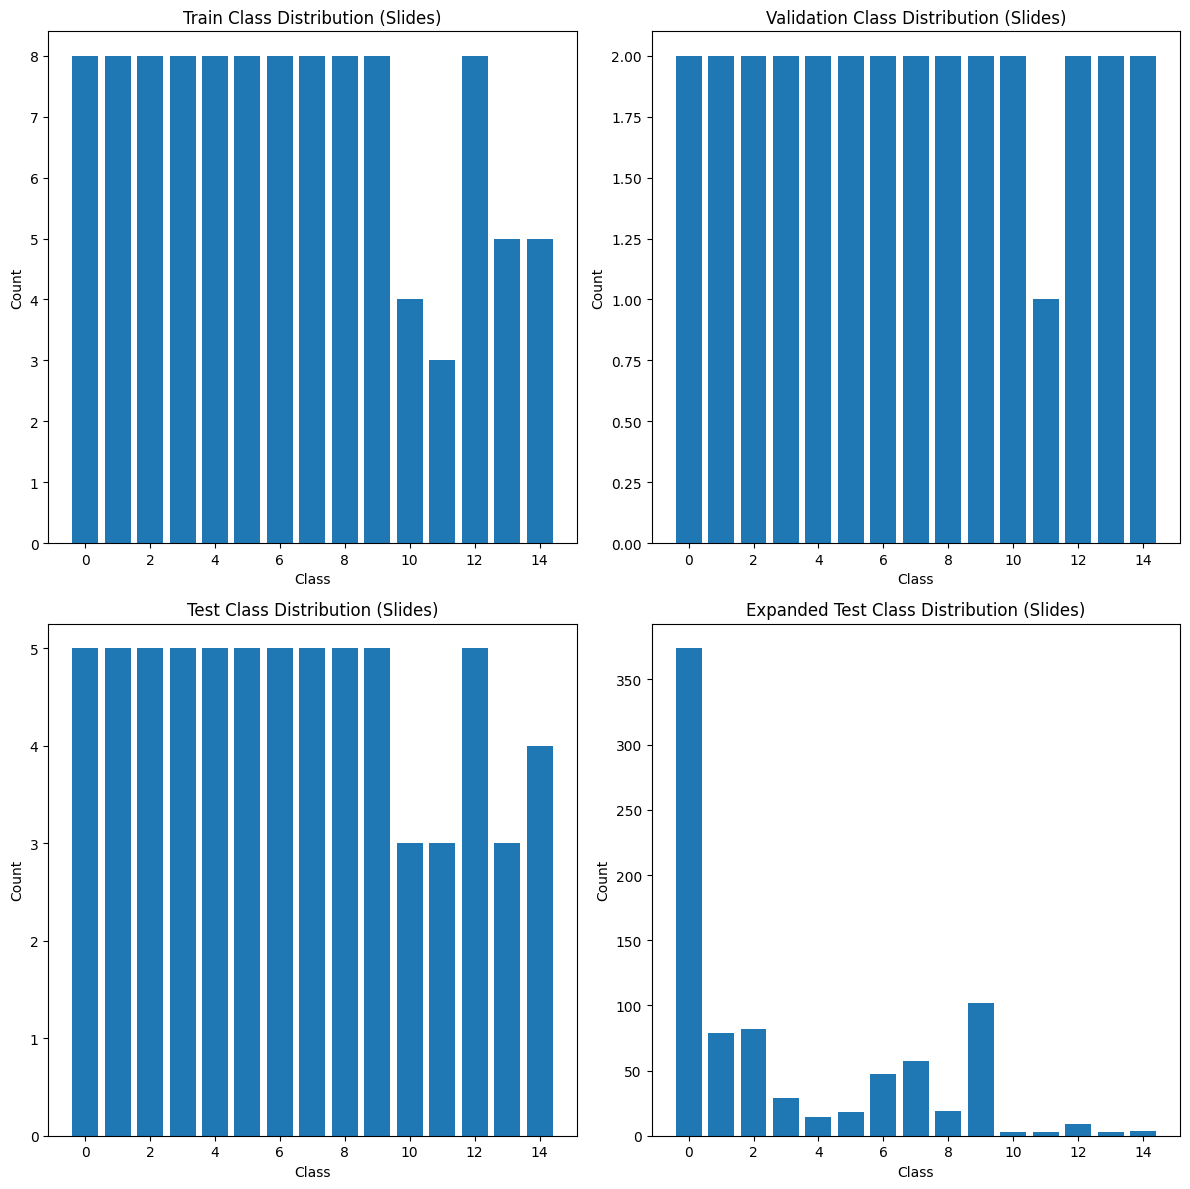

Train class distribution (slides): [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 4. 3. 8. 5. 5.]
Validation class distribution (slides): [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2.]
Test class distribution (slides): [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 5. 3. 4.]
Expanded Test class distribution (slides): [374.  79.  82.  29.  14.  18.  47.  57.  19. 102.   3.   3.   9.   3.
   4.]


In [ ]:
# Function to get class distribution from slide info
def get_class_distribution_from_slide_info(slide_info, custom_classes):
    class_counts = np.zeros(len(custom_classes))
    class_map = {cls: idx for idx, cls in enumerate(custom_classes)}

    for slide_id, class_label in slide_info:
        if class_label in class_map:
            class_counts[class_map[class_label]] += 1

    return class_counts

# Define your custom range of class labels
custom_range = list(range(0, 15))

# Calculate class distributions for slides
train_slide_distribution = get_class_distribution_from_slide_info(train_slide_info, custom_range)
val_slide_distribution = get_class_distribution_from_slide_info(val_slide_info, custom_range)
test_slide_distribution = get_class_distribution_from_slide_info(test_slide_info, custom_range)
expanded_test_slide_distribution = get_class_distribution_from_slide_info(expanded_test_slide_info, custom_range)

# Plotting class distributions for slides
classes = np.array(custom_range)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.bar(classes, train_slide_distribution)
plt.title('Train Class Distribution (Slides)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
plt.bar(classes, val_slide_distribution)
plt.title('Validation Class Distribution (Slides)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
plt.bar(classes, test_slide_distribution)
plt.title('Test Class Distribution (Slides)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.bar(classes, expanded_test_slide_distribution)
plt.title('Expanded Test Class Distribution (Slides)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print distributions as arrays
print("Train class distribution (slides):", train_slide_distribution)
print("Validation class distribution (slides):", val_slide_distribution)
print("Test class distribution (slides):", test_slide_distribution)
print("Expanded Test class distribution (slides):", expanded_test_slide_distribution)

# Save distributions to CSV
output_folder = 'Result_summary'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

distribution_data = {
    'Class': classes,
    'Train': train_slide_distribution,
    'Validation': val_slide_distribution,
    'Test': test_slide_distribution,
    'Expanded Test': expanded_test_slide_distribution
}

distribution_df = pd.DataFrame(distribution_data)
distribution_df.to_csv(os.path.join(output_folder, 'slide_class_distributions.csv'), index=False)


In [ ]:

# Assuming train_patch_ids, train_labels, train_slide_ids, test_patch_ids, test_labels, and test_slide_ids are lists of image paths, labels, and slide IDs for training and testing
# Create dataset and dataloader
class TissueDataset(Dataset):
    def __init__(self, image_paths, labels, slide_ids, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.slide_ids = slide_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        slide_id = self.slide_ids[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, slide_id



In [ ]:
# Define the data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloader
train_dataset = TissueDataset(train_patch_ids, train_labels, train_slide_ids, transform=train_transform)
val_dataset = TissueDataset(val_patch_ids, val_labels, val_slide_ids, transform=val_transform)
test_dataset = TissueDataset(test_patch_ids, test_labels, test_slide_ids, transform=val_transform)
expanded_test_dataset = TissueDataset(expanded_test_patch_ids, expanded_test_labels, expanded_test_slide_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
expanded_test_loader = DataLoader(expanded_test_dataset, batch_size=128, shuffle=False, num_workers=4)


In [ ]:
print(len(train_loader))

2355


In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
def training(train_loader, val_loader, learn_rate, EPOCHS, model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use DataParallel for multi-GPU support
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learn_rate)

    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    # Initialize lists to store epoch data
    epoch_data = {
        'Epoch': [],
        'Train Loss': [],
        'Train Accuracy': [],
        'Validation Loss': [],
        'Validation Accuracy': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        epoch_start_time = time.time()

        # Initialize tqdm progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')

        for batch_idx, (inputs, labels, slide_ids) in enumerate(train_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            batch_acc = running_corrects.double() / ((batch_idx + 1) * train_loader.batch_size)

            # Calculate and display ETA
            batch_end_time = time.time()
            batch_duration = batch_end_time - epoch_start_time
            eta = batch_duration * (len(train_loader) - batch_idx - 1) / (batch_idx + 1)

            # Update tqdm progress bar with current loss, accuracy, and ETA
            train_loader_tqdm.set_postfix(
                loss=batch_loss,
                accuracy=batch_acc.item(),
                ETA=f"{eta/60:.2f} min"
            )

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels, slide_ids in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # Save the model at the end of each epoch if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs")
            break

        # Save epoch data
        epoch_data['Epoch'].append(epoch + 1)
        epoch_data['Train Loss'].append(epoch_loss)
        epoch_data['Train Accuracy'].append(epoch_acc.item())
        epoch_data['Validation Loss'].append(val_loss)
        epoch_data['Validation Accuracy'].append(val_acc.item())

    # Save epoch data to CSV file
    epoch_df = pd.DataFrame(epoch_data)
    epoch_df.to_csv(results_path+model_name+'_training_validation_metrics.csv', index=False)

    return model


In [ ]:
## Model-1

class ClassificationModel(nn.Module):
    def __init__(self, num_classes=17):
        super(ClassificationModel, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.batch_norm = nn.BatchNorm2d(3, affine=False)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[1].in_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.batch_norm(x)  # Apply batch normalization to the input
        x = self.features(x)
        x = self.classifier(x)
        return x

def freezing_layers(model):
    for param in model.features.parameters():
        param.requires_grad = False

In [ ]:
### Model-2

#import torch.nn as nn
# import torchvision.models as models

# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=15):
#         super(ClassificationModel, self).__init__()
#         base_model = models.resnet50(pretrained=True)
#         # Assuming the input has 3 channels (RGB), adjust if necessary
#         self.batch_norm = nn.BatchNorm2d(3, affine=False)
#         self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the last layer ( fc)
#         in_features = base_model.fc.in_features
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.batch_norm(x)  # Apply batch normalization to the input
#         x = self.features(x)
#         x = torch.flatten(x, 1)  # Flatten the features
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False


In [ ]:
# ## Model-3

# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=15):
#         super(ClassificationModel, self).__init__()

#         base_model = swin_t(pretrained=True)
#         self.batch_norm = nn.BatchNorm2d(3, affine=False)

#         # Extract features from the Swin Transformer (adjust index as needed)
#         self.features = nn.Sequential(*list(base_model.children())[:-2])  # Adjust index based on Swin Transformer architecture
#         in_features = base_model.head.in_features  # Get input features for the classifier

#         self.classifier = nn.Sequential(
#             nn.Linear(in_features, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.batch_norm(x)
#         x = self.features(x)  # Extract features from Swin Transformer
#         x = torch.flatten(x, 1)  # Flatten the features
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False


In [ ]:
# # Model-4


# import torch
# import torch.nn as nn
# from torchvision import models
# from transformers import ViTModel, ViTConfig

# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=15):
#         super(ClassificationModel, self).__init__()

#         # Load a pretrained Vision Transformer model
#         config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
#         self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224', config=config)
#         self.batch_norm = nn.BatchNorm2d(3, affine=False)  # Assuming the input has 3 channels (RGB)


#         # Classifier layer
#         self.classifier = nn.Sequential(
#             nn.Linear(config.hidden_size, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.batch_norm(x)  # Apply batch normalization to the input
#         # Pass the input through the Vision Transformer
#         outputs = self.vit(x)
#         pooled_output = outputs.pooler_output  # Use the pooled output from the Vision Transformer

#         # Pass the pooled output through the classifier
#         x = self.classifier(pooled_output)
#         return x

# def freezing_layers(model):
#     for param in model.vit.parameters():
#         param.requires_grad = False

In [ ]:
# #Model 5

# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=17):
#         super(ClassificationModel, self).__init__()
#         # Load the pre-trained VGG-19 model
#         base_model = models.vgg19(pretrained=True)
#         # Extract features from the VGG-19 model
#         self.features = nn.Sequential(*list(base_model.features.children()))  # Extract only the convolutional part
#         self.batch_norm = nn.BatchNorm2d(3, affine=False)

#         # Define the classifier layers based on VGG-19's classifier structure
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(25088, 4096),  # VGG-19's first fully connected layer
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),  # VGG-19's second fully connected layer
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(4096, num_classes)  # Output layer
#         )

#     def forward(self, x):
#         x = self.batch_norm(x)
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False
# #

In [ ]:
model = ClassificationModel(num_classes=15)
print(model)

ClassificationModel(
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_s

In [ ]:
num_classes=15


model = ClassificationModel(num_classes=15)
freezing_layers(model)

learn_rate = 0.001
EPOCHS = 5
filename =results_path+'efficientnet_b0_15_class.pth'

model = training(train_loader, val_loader, learn_rate, EPOCHS, model, filename)


Epoch 1/5: 100%|██████████| 2355/2355 [2:05:57<00:00,  3.21s/batch, ETA=0.00 min, accuracy=0.695, loss=0.985]  

Epoch 1/5, Loss: 0.9848, Acc: 0.6950


Validation Loss: 1.9337, Validation Acc: 0.5054


Epoch 2/5: 100%|██████████| 2355/2355 [2:09:45<00:00,  3.31s/batch, ETA=0.00 min, accuracy=0.73, loss=0.863]    

Epoch 2/5, Loss: 0.8636, Acc: 0.7303


Validation Loss: 1.9783, Validation Acc: 0.5047


Epoch 3/5:  21%|██        | 498/2355 [27:22<1:38:38,  3.19s/batch, ETA=101.82 min, accuracy=0.735, loss=0.845]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/5: 100%|██████████| 2355/2355 [2:09:24<00:00,  3.30s/batch, ETA=0.00 min, accuracy=0.74, loss=0.83]   

Epoch 3/5, Loss: 0.8307, Acc: 0.7401


Validation Loss: 1.8696, Validation Acc: 0.5152


Epoch 4/5: 100%|██████████| 2355/2355 [2:07:05<00:00,  3.24s/batch, ETA=0.00 min, accuracy=0.746, loss=0.811]   

Epoch 4/5, Loss: 0.8109, Acc: 0.7462


Validation Loss: 1.9964, Validation Acc: 0.5005


Epoch 5/5: 100%|██████████| 2355/2355 [2:08:00<00:00,  3.26s/batch, ETA=0.00 min, accuracy=0.749, loss=0.802]   

Epoch 5/5, Loss: 0.8023, Acc: 0.7489


Validation Loss: 1.9467, Validation Acc: 0.5215
Stopping early after 5 epochs


In [ ]:
# Load the best model for evaluation
filename = results_path+'efficientnet_b0_15_class.pth'

model = ClassificationModel(num_classes=15)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model.load_state_dict(torch.load(filename))


# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model.eval()


test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(test_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



Evaluating:   0%|          | 1/1445 [00:05<2:04:15,  5.16s/batch]

Batch Loss: 3.5510, Batch Accuracy: 0.1406


Evaluating:   0%|          | 2/1445 [00:07<1:29:25,  3.72s/batch]

Batch Loss: 3.5976, Batch Accuracy: 0.0977


Evaluating:   0%|          | 3/1445 [00:10<1:17:00,  3.20s/batch]

Batch Loss: 3.1568, Batch Accuracy: 0.1562


Evaluating:   0%|          | 4/1445 [00:12<1:10:08,  2.92s/batch]

Batch Loss: 2.9815, Batch Accuracy: 0.1758


Evaluating:   0%|          | 5/1445 [00:15<1:06:50,  2.78s/batch]

Batch Loss: 2.8728, Batch Accuracy: 0.1875


Evaluating:   0%|          | 6/1445 [00:18<1:06:16,  2.76s/batch]

Batch Loss: 2.8087, Batch Accuracy: 0.1927


Evaluating:   0%|          | 7/1445 [00:20<1:03:46,  2.66s/batch]

Batch Loss: 2.6729, Batch Accuracy: 0.2333


Evaluating:   1%|          | 8/1445 [00:23<1:03:14,  2.64s/batch]

Batch Loss: 2.5006, Batch Accuracy: 0.2871


Evaluating:   1%|          | 9/1445 [00:25<1:02:23,  2.61s/batch]

Batch Loss: 2.3779, Batch Accuracy: 0.3264


Evaluating:   1%|          | 10/1445 [00:28<1:02:40,  2.62s/batch]

Batch Loss: 2.2837, Batch Accuracy: 0.3523


Evaluating:   1%|          | 11/1445 [00:30<1:01:58,  2.59s/batch]

Batch Loss: 2.2056, Batch Accuracy: 0.3750


Evaluating:   1%|          | 12/1445 [00:33<1:02:26,  2.61s/batch]

Batch Loss: 2.1512, Batch Accuracy: 0.3887


Evaluating:   1%|          | 13/1445 [00:36<1:01:27,  2.58s/batch]

Batch Loss: 2.0903, Batch Accuracy: 0.4081


Evaluating:   1%|          | 14/1445 [00:38<1:02:20,  2.61s/batch]

Batch Loss: 2.0374, Batch Accuracy: 0.4208


Evaluating:   1%|          | 15/1445 [00:41<1:01:22,  2.58s/batch]

Batch Loss: 2.0174, Batch Accuracy: 0.4297


Evaluating:   1%|          | 16/1445 [00:44<1:02:46,  2.64s/batch]

Batch Loss: 1.9828, Batch Accuracy: 0.4375


Evaluating:   1%|          | 17/1445 [00:46<1:01:51,  2.60s/batch]

Batch Loss: 1.9483, Batch Accuracy: 0.4499


Evaluating:   1%|          | 18/1445 [00:49<1:02:34,  2.63s/batch]

Batch Loss: 1.9302, Batch Accuracy: 0.4575


Evaluating:   1%|▏         | 19/1445 [00:51<1:02:31,  2.63s/batch]

Batch Loss: 1.9038, Batch Accuracy: 0.4622


Evaluating:   1%|▏         | 20/1445 [00:54<1:01:34,  2.59s/batch]

Batch Loss: 1.8832, Batch Accuracy: 0.4695


Evaluating:   1%|▏         | 21/1445 [00:56<1:00:36,  2.55s/batch]

Batch Loss: 1.9063, Batch Accuracy: 0.4639


Evaluating:   2%|▏         | 22/1445 [00:59<1:00:10,  2.54s/batch]

Batch Loss: 1.9735, Batch Accuracy: 0.4478


Evaluating:   2%|▏         | 23/1445 [01:02<1:01:45,  2.61s/batch]

Batch Loss: 2.0274, Batch Accuracy: 0.4338


Evaluating:   2%|▏         | 24/1445 [01:04<1:00:18,  2.55s/batch]

Batch Loss: 2.0805, Batch Accuracy: 0.4183


Evaluating:   2%|▏         | 25/1445 [01:07<1:01:53,  2.62s/batch]

Batch Loss: 2.1312, Batch Accuracy: 0.4053


Evaluating:   2%|▏         | 26/1445 [01:09<1:01:07,  2.58s/batch]

Batch Loss: 2.1701, Batch Accuracy: 0.3933


Evaluating:   2%|▏         | 27/1445 [01:12<1:00:10,  2.55s/batch]

Batch Loss: 2.2022, Batch Accuracy: 0.3843


Evaluating:   2%|▏         | 28/1445 [01:14<59:36,  2.52s/batch]  

Batch Loss: 2.2425, Batch Accuracy: 0.3733


Evaluating:   2%|▏         | 29/1445 [01:17<59:19,  2.51s/batch]

Batch Loss: 2.2573, Batch Accuracy: 0.3672


Evaluating:   2%|▏         | 30/1445 [01:19<1:00:16,  2.56s/batch]

Batch Loss: 2.2748, Batch Accuracy: 0.3609


Evaluating:   2%|▏         | 31/1445 [01:22<59:35,  2.53s/batch]  

Batch Loss: 2.2975, Batch Accuracy: 0.3528


Evaluating:   2%|▏         | 32/1445 [01:24<58:49,  2.50s/batch]

Batch Loss: 2.3294, Batch Accuracy: 0.3467


Evaluating:   2%|▏         | 33/1445 [01:27<58:18,  2.48s/batch]

Batch Loss: 2.3830, Batch Accuracy: 0.3383


Evaluating:   2%|▏         | 34/1445 [01:29<59:07,  2.51s/batch]

Batch Loss: 2.4317, Batch Accuracy: 0.3311


Evaluating:   2%|▏         | 35/1445 [01:32<1:02:00,  2.64s/batch]

Batch Loss: 2.4691, Batch Accuracy: 0.3246


Evaluating:   2%|▏         | 36/1445 [01:35<1:00:25,  2.57s/batch]

Batch Loss: 2.5111, Batch Accuracy: 0.3184


Evaluating:   3%|▎         | 37/1445 [01:37<1:00:00,  2.56s/batch]

Batch Loss: 2.5457, Batch Accuracy: 0.3117


Evaluating:   3%|▎         | 38/1445 [01:40<1:00:25,  2.58s/batch]

Batch Loss: 2.5821, Batch Accuracy: 0.3063


Evaluating:   3%|▎         | 39/1445 [01:42<1:00:01,  2.56s/batch]

Batch Loss: 2.6235, Batch Accuracy: 0.3001


Evaluating:   3%|▎         | 40/1445 [01:45<59:06,  2.52s/batch]  

Batch Loss: 2.6461, Batch Accuracy: 0.2947


Evaluating:   3%|▎         | 41/1445 [01:47<58:36,  2.50s/batch]

Batch Loss: 2.6752, Batch Accuracy: 0.2896


Evaluating:   3%|▎         | 42/1445 [01:50<58:20,  2.50s/batch]

Batch Loss: 2.7065, Batch Accuracy: 0.2846


Evaluating:   3%|▎         | 43/1445 [01:52<59:31,  2.55s/batch]

Batch Loss: 2.7383, Batch Accuracy: 0.2798


Evaluating:   3%|▎         | 44/1445 [01:55<59:17,  2.54s/batch]

Batch Loss: 2.7613, Batch Accuracy: 0.2754


Evaluating:   3%|▎         | 45/1445 [01:57<58:52,  2.52s/batch]

Batch Loss: 2.7840, Batch Accuracy: 0.2722


Evaluating:   3%|▎         | 46/1445 [02:00<59:01,  2.53s/batch]

Batch Loss: 2.8077, Batch Accuracy: 0.2677


Evaluating:   3%|▎         | 47/1445 [02:02<58:10,  2.50s/batch]

Batch Loss: 2.8332, Batch Accuracy: 0.2636


Evaluating:   3%|▎         | 48/1445 [02:05<57:48,  2.48s/batch]

Batch Loss: 2.8541, Batch Accuracy: 0.2598


Evaluating:   3%|▎         | 49/1445 [02:07<57:27,  2.47s/batch]

Batch Loss: 2.8763, Batch Accuracy: 0.2562


Evaluating:   3%|▎         | 50/1445 [02:10<58:14,  2.51s/batch]

Batch Loss: 2.9018, Batch Accuracy: 0.2523


Evaluating:   4%|▎         | 51/1445 [02:13<59:31,  2.56s/batch]

Batch Loss: 2.9160, Batch Accuracy: 0.2495


Evaluating:   4%|▎         | 52/1445 [02:15<58:34,  2.52s/batch]

Batch Loss: 2.9392, Batch Accuracy: 0.2459


Evaluating:   4%|▎         | 53/1445 [02:17<57:41,  2.49s/batch]

Batch Loss: 2.9579, Batch Accuracy: 0.2426


Evaluating:   4%|▎         | 54/1445 [02:20<58:41,  2.53s/batch]

Batch Loss: 2.9729, Batch Accuracy: 0.2400


Evaluating:   4%|▍         | 55/1445 [02:23<58:28,  2.52s/batch]

Batch Loss: 2.9660, Batch Accuracy: 0.2406


Evaluating:   4%|▍         | 56/1445 [02:25<58:00,  2.51s/batch]

Batch Loss: 2.9694, Batch Accuracy: 0.2394


Evaluating:   4%|▍         | 57/1445 [02:28<59:18,  2.56s/batch]

Batch Loss: 2.9693, Batch Accuracy: 0.2388


Evaluating:   4%|▍         | 58/1445 [02:30<58:28,  2.53s/batch]

Batch Loss: 2.9650, Batch Accuracy: 0.2377


Evaluating:   4%|▍         | 59/1445 [02:33<59:56,  2.60s/batch]

Batch Loss: 2.9655, Batch Accuracy: 0.2373


Evaluating:   4%|▍         | 60/1445 [02:35<59:00,  2.56s/batch]

Batch Loss: 2.9641, Batch Accuracy: 0.2359


Evaluating:   4%|▍         | 61/1445 [02:38<58:23,  2.53s/batch]

Batch Loss: 2.9590, Batch Accuracy: 0.2358


Evaluating:   4%|▍         | 62/1445 [02:40<58:43,  2.55s/batch]

Batch Loss: 2.9589, Batch Accuracy: 0.2351


Evaluating:   4%|▍         | 63/1445 [02:43<57:35,  2.50s/batch]

Batch Loss: 2.9539, Batch Accuracy: 0.2351


Evaluating:   4%|▍         | 64/1445 [02:45<57:26,  2.50s/batch]

Batch Loss: 2.9534, Batch Accuracy: 0.2349


Evaluating:   4%|▍         | 65/1445 [02:48<57:06,  2.48s/batch]

Batch Loss: 2.9531, Batch Accuracy: 0.2346


Evaluating:   5%|▍         | 66/1445 [02:50<56:25,  2.45s/batch]

Batch Loss: 2.9498, Batch Accuracy: 0.2335


Evaluating:   5%|▍         | 67/1445 [02:53<56:23,  2.46s/batch]

Batch Loss: 2.9529, Batch Accuracy: 0.2333


Evaluating:   5%|▍         | 68/1445 [02:55<56:43,  2.47s/batch]

Batch Loss: 2.9522, Batch Accuracy: 0.2329


Evaluating:   5%|▍         | 69/1445 [02:58<58:14,  2.54s/batch]

Batch Loss: 2.9486, Batch Accuracy: 0.2329


Evaluating:   5%|▍         | 70/1445 [03:00<57:13,  2.50s/batch]

Batch Loss: 2.9476, Batch Accuracy: 0.2328


Evaluating:   5%|▍         | 71/1445 [03:03<58:23,  2.55s/batch]

Batch Loss: 2.9478, Batch Accuracy: 0.2317


Evaluating:   5%|▍         | 72/1445 [03:05<57:29,  2.51s/batch]

Batch Loss: 2.9469, Batch Accuracy: 0.2316


Evaluating:   5%|▌         | 73/1445 [03:08<56:53,  2.49s/batch]

Batch Loss: 2.9442, Batch Accuracy: 0.2314


Evaluating:   5%|▌         | 74/1445 [03:10<56:13,  2.46s/batch]

Batch Loss: 2.9451, Batch Accuracy: 0.2309


Evaluating:   5%|▌         | 75/1445 [03:13<56:15,  2.46s/batch]

Batch Loss: 2.9419, Batch Accuracy: 0.2307


Evaluating:   5%|▌         | 76/1445 [03:15<55:38,  2.44s/batch]

Batch Loss: 2.9457, Batch Accuracy: 0.2304


Evaluating:   5%|▌         | 77/1445 [03:17<55:46,  2.45s/batch]

Batch Loss: 2.9421, Batch Accuracy: 0.2307


Evaluating:   5%|▌         | 78/1445 [03:20<55:43,  2.45s/batch]

Batch Loss: 2.9443, Batch Accuracy: 0.2296


Evaluating:   5%|▌         | 79/1445 [03:22<56:30,  2.48s/batch]

Batch Loss: 2.9477, Batch Accuracy: 0.2294


Evaluating:   6%|▌         | 80/1445 [03:25<55:53,  2.46s/batch]

Batch Loss: 2.9489, Batch Accuracy: 0.2286


Evaluating:   6%|▌         | 81/1445 [03:28<57:51,  2.55s/batch]

Batch Loss: 2.9480, Batch Accuracy: 0.2283


Evaluating:   6%|▌         | 82/1445 [03:30<57:00,  2.51s/batch]

Batch Loss: 2.9471, Batch Accuracy: 0.2274


Evaluating:   6%|▌         | 83/1445 [03:33<59:41,  2.63s/batch]

Batch Loss: 2.9467, Batch Accuracy: 0.2266


Evaluating:   6%|▌         | 84/1445 [03:35<58:27,  2.58s/batch]

Batch Loss: 2.9467, Batch Accuracy: 0.2259


Evaluating:   6%|▌         | 85/1445 [03:38<59:49,  2.64s/batch]

Batch Loss: 2.9480, Batch Accuracy: 0.2256


Evaluating:   6%|▌         | 86/1445 [03:41<58:22,  2.58s/batch]

Batch Loss: 2.9458, Batch Accuracy: 0.2255


Evaluating:   6%|▌         | 87/1445 [03:43<58:22,  2.58s/batch]

Batch Loss: 2.9443, Batch Accuracy: 0.2254


Evaluating:   6%|▌         | 88/1445 [03:46<58:30,  2.59s/batch]

Batch Loss: 2.9439, Batch Accuracy: 0.2250


Evaluating:   6%|▌         | 89/1445 [03:48<58:50,  2.60s/batch]

Batch Loss: 2.9421, Batch Accuracy: 0.2246


Evaluating:   6%|▌         | 90/1445 [03:51<57:20,  2.54s/batch]

Batch Loss: 2.9300, Batch Accuracy: 0.2276


Evaluating:   6%|▋         | 91/1445 [03:53<56:50,  2.52s/batch]

Batch Loss: 2.9179, Batch Accuracy: 0.2308


Evaluating:   6%|▋         | 92/1445 [03:56<56:02,  2.48s/batch]

Batch Loss: 2.9051, Batch Accuracy: 0.2340


Evaluating:   6%|▋         | 93/1445 [03:58<56:13,  2.50s/batch]

Batch Loss: 2.8924, Batch Accuracy: 0.2369


Evaluating:   7%|▋         | 94/1445 [04:01<55:49,  2.48s/batch]

Batch Loss: 2.8788, Batch Accuracy: 0.2398


Evaluating:   7%|▋         | 95/1445 [04:03<56:45,  2.52s/batch]

Batch Loss: 2.8644, Batch Accuracy: 0.2430


Evaluating:   7%|▋         | 96/1445 [04:06<55:50,  2.48s/batch]

Batch Loss: 2.8520, Batch Accuracy: 0.2459


Evaluating:   7%|▋         | 97/1445 [04:08<55:49,  2.48s/batch]

Batch Loss: 2.8404, Batch Accuracy: 0.2486


Evaluating:   7%|▋         | 98/1445 [04:11<55:38,  2.48s/batch]

Batch Loss: 2.8279, Batch Accuracy: 0.2514


Evaluating:   7%|▋         | 99/1445 [04:13<57:10,  2.55s/batch]

Batch Loss: 2.8171, Batch Accuracy: 0.2534


Evaluating:   7%|▋         | 100/1445 [04:16<55:59,  2.50s/batch]

Batch Loss: 2.8057, Batch Accuracy: 0.2559


Evaluating:   7%|▋         | 101/1445 [04:18<55:32,  2.48s/batch]

Batch Loss: 2.7927, Batch Accuracy: 0.2584


Evaluating:   7%|▋         | 102/1445 [04:21<55:26,  2.48s/batch]

Batch Loss: 2.7815, Batch Accuracy: 0.2610


Evaluating:   7%|▋         | 103/1445 [04:23<55:49,  2.50s/batch]

Batch Loss: 2.7694, Batch Accuracy: 0.2633


Evaluating:   7%|▋         | 104/1445 [04:26<55:18,  2.47s/batch]

Batch Loss: 2.7603, Batch Accuracy: 0.2653


Evaluating:   7%|▋         | 105/1445 [04:28<56:05,  2.51s/batch]

Batch Loss: 2.7495, Batch Accuracy: 0.2675


Evaluating:   7%|▋         | 106/1445 [04:31<55:58,  2.51s/batch]

Batch Loss: 2.7368, Batch Accuracy: 0.2707


Evaluating:   7%|▋         | 107/1445 [04:34<58:01,  2.60s/batch]

Batch Loss: 2.7268, Batch Accuracy: 0.2732


Evaluating:   7%|▋         | 108/1445 [04:36<56:46,  2.55s/batch]

Batch Loss: 2.7163, Batch Accuracy: 0.2758


Evaluating:   8%|▊         | 109/1445 [04:39<58:08,  2.61s/batch]

Batch Loss: 2.7088, Batch Accuracy: 0.2780


Evaluating:   8%|▊         | 110/1445 [04:41<57:28,  2.58s/batch]

Batch Loss: 2.7000, Batch Accuracy: 0.2803


Evaluating:   8%|▊         | 111/1445 [04:44<56:47,  2.55s/batch]

Batch Loss: 2.6910, Batch Accuracy: 0.2822


Evaluating:   8%|▊         | 112/1445 [04:46<56:24,  2.54s/batch]

Batch Loss: 2.6792, Batch Accuracy: 0.2849


Evaluating:   8%|▊         | 113/1445 [04:49<56:28,  2.54s/batch]

Batch Loss: 2.6715, Batch Accuracy: 0.2869


Evaluating:   8%|▊         | 114/1445 [04:51<55:54,  2.52s/batch]

Batch Loss: 2.6621, Batch Accuracy: 0.2887


Evaluating:   8%|▊         | 115/1445 [04:54<56:09,  2.53s/batch]

Batch Loss: 2.6519, Batch Accuracy: 0.2912


Evaluating:   8%|▊         | 116/1445 [04:56<56:10,  2.54s/batch]

Batch Loss: 2.6431, Batch Accuracy: 0.2934


Evaluating:   8%|▊         | 117/1445 [04:59<55:59,  2.53s/batch]

Batch Loss: 2.6338, Batch Accuracy: 0.2957


Evaluating:   8%|▊         | 118/1445 [05:01<55:29,  2.51s/batch]

Batch Loss: 2.6225, Batch Accuracy: 0.2984


Evaluating:   8%|▊         | 119/1445 [05:04<57:34,  2.61s/batch]

Batch Loss: 2.6128, Batch Accuracy: 0.3008


Evaluating:   8%|▊         | 120/1445 [05:07<56:26,  2.56s/batch]

Batch Loss: 2.6052, Batch Accuracy: 0.3026


Evaluating:   8%|▊         | 121/1445 [05:09<55:59,  2.54s/batch]

Batch Loss: 2.5970, Batch Accuracy: 0.3046


Evaluating:   8%|▊         | 122/1445 [05:12<55:10,  2.50s/batch]

Batch Loss: 2.5876, Batch Accuracy: 0.3069


Evaluating:   9%|▊         | 123/1445 [05:14<54:41,  2.48s/batch]

Batch Loss: 2.5805, Batch Accuracy: 0.3088


Evaluating:   9%|▊         | 124/1445 [05:16<54:22,  2.47s/batch]

Batch Loss: 2.5719, Batch Accuracy: 0.3109


Evaluating:   9%|▊         | 125/1445 [05:19<54:18,  2.47s/batch]

Batch Loss: 2.5625, Batch Accuracy: 0.3132


Evaluating:   9%|▊         | 126/1445 [05:21<54:07,  2.46s/batch]

Batch Loss: 2.5560, Batch Accuracy: 0.3151


Evaluating:   9%|▉         | 127/1445 [05:24<56:00,  2.55s/batch]

Batch Loss: 2.5480, Batch Accuracy: 0.3170


Evaluating:   9%|▉         | 128/1445 [05:26<54:51,  2.50s/batch]

Batch Loss: 2.5414, Batch Accuracy: 0.3187


Evaluating:   9%|▉         | 129/1445 [05:29<54:56,  2.50s/batch]

Batch Loss: 2.5355, Batch Accuracy: 0.3199


Evaluating:   9%|▉         | 130/1445 [05:32<55:24,  2.53s/batch]

Batch Loss: 2.5298, Batch Accuracy: 0.3212


Evaluating:   9%|▉         | 131/1445 [05:34<56:41,  2.59s/batch]

Batch Loss: 2.5217, Batch Accuracy: 0.3232


Evaluating:   9%|▉         | 132/1445 [05:37<56:35,  2.59s/batch]

Batch Loss: 2.5156, Batch Accuracy: 0.3246


Evaluating:   9%|▉         | 133/1445 [05:39<56:05,  2.57s/batch]

Batch Loss: 2.5092, Batch Accuracy: 0.3261


Evaluating:   9%|▉         | 134/1445 [05:42<55:02,  2.52s/batch]

Batch Loss: 2.5042, Batch Accuracy: 0.3280


Evaluating:   9%|▉         | 135/1445 [05:44<54:25,  2.49s/batch]

Batch Loss: 2.5075, Batch Accuracy: 0.3286


Evaluating:   9%|▉         | 136/1445 [05:47<54:21,  2.49s/batch]

Batch Loss: 2.5095, Batch Accuracy: 0.3300


Evaluating:   9%|▉         | 137/1445 [05:49<54:13,  2.49s/batch]

Batch Loss: 2.5151, Batch Accuracy: 0.3311


Evaluating:  10%|▉         | 138/1445 [05:52<53:47,  2.47s/batch]

Batch Loss: 2.5205, Batch Accuracy: 0.3320


Evaluating:  10%|▉         | 139/1445 [05:54<53:50,  2.47s/batch]

Batch Loss: 2.5256, Batch Accuracy: 0.3326


Evaluating:  10%|▉         | 140/1445 [05:56<53:21,  2.45s/batch]

Batch Loss: 2.5261, Batch Accuracy: 0.3338


Evaluating:  10%|▉         | 141/1445 [05:59<53:37,  2.47s/batch]

Batch Loss: 2.5311, Batch Accuracy: 0.3344


Evaluating:  10%|▉         | 142/1445 [06:01<53:33,  2.47s/batch]

Batch Loss: 2.5350, Batch Accuracy: 0.3353


Evaluating:  10%|▉         | 143/1445 [06:04<53:44,  2.48s/batch]

Batch Loss: 2.5404, Batch Accuracy: 0.3362


Evaluating:  10%|▉         | 144/1445 [06:06<54:04,  2.49s/batch]

Batch Loss: 2.5433, Batch Accuracy: 0.3370


Evaluating:  10%|█         | 145/1445 [06:09<54:06,  2.50s/batch]

Batch Loss: 2.5458, Batch Accuracy: 0.3381


Evaluating:  10%|█         | 146/1445 [06:11<53:52,  2.49s/batch]

Batch Loss: 2.5525, Batch Accuracy: 0.3383


Evaluating:  10%|█         | 147/1445 [06:14<53:56,  2.49s/batch]

Batch Loss: 2.5588, Batch Accuracy: 0.3389


Evaluating:  10%|█         | 148/1445 [06:17<55:42,  2.58s/batch]

Batch Loss: 2.5602, Batch Accuracy: 0.3400


Evaluating:  10%|█         | 149/1445 [06:19<55:04,  2.55s/batch]

Batch Loss: 2.5657, Batch Accuracy: 0.3404


Evaluating:  10%|█         | 150/1445 [06:22<54:16,  2.51s/batch]

Batch Loss: 2.5688, Batch Accuracy: 0.3412


Evaluating:  10%|█         | 151/1445 [06:24<53:58,  2.50s/batch]

Batch Loss: 2.5744, Batch Accuracy: 0.3415


Evaluating:  11%|█         | 152/1445 [06:27<55:00,  2.55s/batch]

Batch Loss: 2.5814, Batch Accuracy: 0.3421


Evaluating:  11%|█         | 153/1445 [06:29<54:29,  2.53s/batch]

Batch Loss: 2.5854, Batch Accuracy: 0.3427


Evaluating:  11%|█         | 154/1445 [06:32<54:24,  2.53s/batch]

Batch Loss: 2.5900, Batch Accuracy: 0.3432


Evaluating:  11%|█         | 155/1445 [06:35<55:43,  2.59s/batch]

Batch Loss: 2.5936, Batch Accuracy: 0.3438


Evaluating:  11%|█         | 156/1445 [06:37<54:36,  2.54s/batch]

Batch Loss: 2.5997, Batch Accuracy: 0.3440


Evaluating:  11%|█         | 157/1445 [06:40<54:52,  2.56s/batch]

Batch Loss: 2.6022, Batch Accuracy: 0.3448


Evaluating:  11%|█         | 158/1445 [06:42<55:03,  2.57s/batch]

Batch Loss: 2.6060, Batch Accuracy: 0.3456


Evaluating:  11%|█         | 159/1445 [06:45<54:32,  2.54s/batch]

Batch Loss: 2.6131, Batch Accuracy: 0.3460


Evaluating:  11%|█         | 160/1445 [06:47<54:15,  2.53s/batch]

Batch Loss: 2.6155, Batch Accuracy: 0.3466


Evaluating:  11%|█         | 161/1445 [06:50<54:33,  2.55s/batch]

Batch Loss: 2.6199, Batch Accuracy: 0.3471


Evaluating:  11%|█         | 162/1445 [06:52<53:46,  2.51s/batch]

Batch Loss: 2.6210, Batch Accuracy: 0.3480


Evaluating:  11%|█▏        | 163/1445 [06:55<54:42,  2.56s/batch]

Batch Loss: 2.6254, Batch Accuracy: 0.3484


Evaluating:  11%|█▏        | 164/1445 [06:57<54:02,  2.53s/batch]

Batch Loss: 2.6282, Batch Accuracy: 0.3489


Evaluating:  11%|█▏        | 165/1445 [07:00<53:35,  2.51s/batch]

Batch Loss: 2.6325, Batch Accuracy: 0.3495


Evaluating:  11%|█▏        | 166/1445 [07:02<53:40,  2.52s/batch]

Batch Loss: 2.6347, Batch Accuracy: 0.3502


Evaluating:  12%|█▏        | 167/1445 [07:05<53:00,  2.49s/batch]

Batch Loss: 2.6198, Batch Accuracy: 0.3539


Evaluating:  12%|█▏        | 168/1445 [07:07<54:25,  2.56s/batch]

Batch Loss: 2.6054, Batch Accuracy: 0.3574


Evaluating:  12%|█▏        | 169/1445 [07:10<56:53,  2.67s/batch]

Batch Loss: 2.5910, Batch Accuracy: 0.3609


Evaluating:  12%|█▏        | 170/1445 [07:13<57:12,  2.69s/batch]

Batch Loss: 2.5767, Batch Accuracy: 0.3644


Evaluating:  12%|█▏        | 171/1445 [07:16<55:36,  2.62s/batch]

Batch Loss: 2.5629, Batch Accuracy: 0.3678


Evaluating:  12%|█▏        | 172/1445 [07:18<55:17,  2.61s/batch]

Batch Loss: 2.5495, Batch Accuracy: 0.3710


Evaluating:  12%|█▏        | 173/1445 [07:21<54:35,  2.57s/batch]

Batch Loss: 2.5362, Batch Accuracy: 0.3742


Evaluating:  12%|█▏        | 174/1445 [07:23<53:31,  2.53s/batch]

Batch Loss: 2.5229, Batch Accuracy: 0.3773


Evaluating:  12%|█▏        | 175/1445 [07:26<53:43,  2.54s/batch]

Batch Loss: 2.5095, Batch Accuracy: 0.3805


Evaluating:  12%|█▏        | 176/1445 [07:28<52:48,  2.50s/batch]

Batch Loss: 2.4969, Batch Accuracy: 0.3835


Evaluating:  12%|█▏        | 177/1445 [07:31<52:43,  2.49s/batch]

Batch Loss: 2.4843, Batch Accuracy: 0.3866


Evaluating:  12%|█▏        | 178/1445 [07:33<54:18,  2.57s/batch]

Batch Loss: 2.4726, Batch Accuracy: 0.3893


Evaluating:  12%|█▏        | 179/1445 [07:36<53:31,  2.54s/batch]

Batch Loss: 2.4601, Batch Accuracy: 0.3923


Evaluating:  12%|█▏        | 180/1445 [07:38<52:40,  2.50s/batch]

Batch Loss: 2.4480, Batch Accuracy: 0.3951


Evaluating:  13%|█▎        | 181/1445 [07:41<54:12,  2.57s/batch]

Batch Loss: 2.4358, Batch Accuracy: 0.3980


Evaluating:  13%|█▎        | 182/1445 [07:44<54:42,  2.60s/batch]

Batch Loss: 2.4238, Batch Accuracy: 0.4008


Evaluating:  13%|█▎        | 183/1445 [07:46<54:10,  2.58s/batch]

Batch Loss: 2.4115, Batch Accuracy: 0.4038


Evaluating:  13%|█▎        | 184/1445 [07:49<53:24,  2.54s/batch]

Batch Loss: 2.3999, Batch Accuracy: 0.4064


Evaluating:  13%|█▎        | 185/1445 [07:51<54:52,  2.61s/batch]

Batch Loss: 2.3882, Batch Accuracy: 0.4092


Evaluating:  13%|█▎        | 186/1445 [07:54<53:48,  2.56s/batch]

Batch Loss: 2.3763, Batch Accuracy: 0.4120


Evaluating:  13%|█▎        | 187/1445 [07:56<54:58,  2.62s/batch]

Batch Loss: 2.3650, Batch Accuracy: 0.4147


Evaluating:  13%|█▎        | 188/1445 [07:59<55:02,  2.63s/batch]

Batch Loss: 2.3542, Batch Accuracy: 0.4173


Evaluating:  13%|█▎        | 189/1445 [08:02<53:45,  2.57s/batch]

Batch Loss: 2.3430, Batch Accuracy: 0.4199


Evaluating:  13%|█▎        | 190/1445 [08:04<53:02,  2.54s/batch]

Batch Loss: 2.3317, Batch Accuracy: 0.4226


Evaluating:  13%|█▎        | 191/1445 [08:07<52:48,  2.53s/batch]

Batch Loss: 2.3210, Batch Accuracy: 0.4252


Evaluating:  13%|█▎        | 192/1445 [08:09<52:38,  2.52s/batch]

Batch Loss: 2.3098, Batch Accuracy: 0.4279


Evaluating:  13%|█▎        | 193/1445 [08:11<52:08,  2.50s/batch]

Batch Loss: 2.2991, Batch Accuracy: 0.4306


Evaluating:  13%|█▎        | 194/1445 [08:14<51:57,  2.49s/batch]

Batch Loss: 2.2886, Batch Accuracy: 0.4330


Evaluating:  13%|█▎        | 195/1445 [08:17<52:57,  2.54s/batch]

Batch Loss: 2.2784, Batch Accuracy: 0.4355


Evaluating:  14%|█▎        | 196/1445 [08:19<52:29,  2.52s/batch]

Batch Loss: 2.2682, Batch Accuracy: 0.4379


Evaluating:  14%|█▎        | 197/1445 [08:22<53:36,  2.58s/batch]

Batch Loss: 2.2582, Batch Accuracy: 0.4402


Evaluating:  14%|█▎        | 198/1445 [08:24<52:51,  2.54s/batch]

Batch Loss: 2.2477, Batch Accuracy: 0.4427


Evaluating:  14%|█▍        | 199/1445 [08:27<52:07,  2.51s/batch]

Batch Loss: 2.2379, Batch Accuracy: 0.4451


Evaluating:  14%|█▍        | 200/1445 [08:29<51:47,  2.50s/batch]

Batch Loss: 2.2287, Batch Accuracy: 0.4475


Evaluating:  14%|█▍        | 201/1445 [08:32<52:32,  2.53s/batch]

Batch Loss: 2.2195, Batch Accuracy: 0.4500


Evaluating:  14%|█▍        | 202/1445 [08:34<52:50,  2.55s/batch]

Batch Loss: 2.2107, Batch Accuracy: 0.4522


Evaluating:  14%|█▍        | 203/1445 [08:37<53:11,  2.57s/batch]

Batch Loss: 2.2015, Batch Accuracy: 0.4546


Evaluating:  14%|█▍        | 204/1445 [08:39<52:23,  2.53s/batch]

Batch Loss: 2.1926, Batch Accuracy: 0.4569


Evaluating:  14%|█▍        | 205/1445 [08:42<52:37,  2.55s/batch]

Batch Loss: 2.1841, Batch Accuracy: 0.4590


Evaluating:  14%|█▍        | 206/1445 [08:45<52:14,  2.53s/batch]

Batch Loss: 2.1753, Batch Accuracy: 0.4611


Evaluating:  14%|█▍        | 207/1445 [08:47<53:02,  2.57s/batch]

Batch Loss: 2.1664, Batch Accuracy: 0.4635


Evaluating:  14%|█▍        | 208/1445 [08:50<52:26,  2.54s/batch]

Batch Loss: 2.1578, Batch Accuracy: 0.4657


Evaluating:  14%|█▍        | 209/1445 [08:52<51:43,  2.51s/batch]

Batch Loss: 2.1496, Batch Accuracy: 0.4679


Evaluating:  15%|█▍        | 210/1445 [08:55<51:18,  2.49s/batch]

Batch Loss: 2.1411, Batch Accuracy: 0.4698


Evaluating:  15%|█▍        | 211/1445 [08:57<51:15,  2.49s/batch]

Batch Loss: 2.1327, Batch Accuracy: 0.4720


Evaluating:  15%|█▍        | 212/1445 [09:00<51:08,  2.49s/batch]

Batch Loss: 2.1246, Batch Accuracy: 0.4739


Evaluating:  15%|█▍        | 213/1445 [09:02<51:22,  2.50s/batch]

Batch Loss: 2.1162, Batch Accuracy: 0.4761


Evaluating:  15%|█▍        | 214/1445 [09:04<50:48,  2.48s/batch]

Batch Loss: 2.1084, Batch Accuracy: 0.4782


Evaluating:  15%|█▍        | 215/1445 [09:07<50:54,  2.48s/batch]

Batch Loss: 2.1002, Batch Accuracy: 0.4802


Evaluating:  15%|█▍        | 216/1445 [09:10<52:18,  2.55s/batch]

Batch Loss: 2.1193, Batch Accuracy: 0.4796


Evaluating:  15%|█▌        | 217/1445 [09:12<51:59,  2.54s/batch]

Batch Loss: 2.1550, Batch Accuracy: 0.4774


Evaluating:  15%|█▌        | 218/1445 [09:15<51:39,  2.53s/batch]

Batch Loss: 2.1923, Batch Accuracy: 0.4752


Evaluating:  15%|█▌        | 219/1445 [09:17<53:21,  2.61s/batch]

Batch Loss: 2.2285, Batch Accuracy: 0.4730


Evaluating:  15%|█▌        | 220/1445 [09:20<52:29,  2.57s/batch]

Batch Loss: 2.2628, Batch Accuracy: 0.4708


Evaluating:  15%|█▌        | 221/1445 [09:22<51:45,  2.54s/batch]

Batch Loss: 2.2967, Batch Accuracy: 0.4688


Evaluating:  15%|█▌        | 222/1445 [09:25<51:39,  2.53s/batch]

Batch Loss: 2.3318, Batch Accuracy: 0.4666


Evaluating:  15%|█▌        | 223/1445 [09:27<51:07,  2.51s/batch]

Batch Loss: 2.3662, Batch Accuracy: 0.4645


Evaluating:  16%|█▌        | 224/1445 [09:30<52:20,  2.57s/batch]

Batch Loss: 2.4005, Batch Accuracy: 0.4625


Evaluating:  16%|█▌        | 225/1445 [09:33<52:17,  2.57s/batch]

Batch Loss: 2.4325, Batch Accuracy: 0.4604


Evaluating:  16%|█▌        | 226/1445 [09:35<52:18,  2.57s/batch]

Batch Loss: 2.4661, Batch Accuracy: 0.4584


Evaluating:  16%|█▌        | 227/1445 [09:38<51:07,  2.52s/batch]

Batch Loss: 2.4966, Batch Accuracy: 0.4564


Evaluating:  16%|█▌        | 228/1445 [09:40<51:10,  2.52s/batch]

Batch Loss: 2.5289, Batch Accuracy: 0.4544


Evaluating:  16%|█▌        | 229/1445 [09:43<51:41,  2.55s/batch]

Batch Loss: 2.5638, Batch Accuracy: 0.4524


Evaluating:  16%|█▌        | 230/1445 [09:45<50:35,  2.50s/batch]

Batch Loss: 2.5951, Batch Accuracy: 0.4504


Evaluating:  16%|█▌        | 231/1445 [09:48<51:30,  2.55s/batch]

Batch Loss: 2.6262, Batch Accuracy: 0.4485


Evaluating:  16%|█▌        | 232/1445 [09:50<50:52,  2.52s/batch]

Batch Loss: 2.6568, Batch Accuracy: 0.4466


Evaluating:  16%|█▌        | 233/1445 [09:53<51:02,  2.53s/batch]

Batch Loss: 2.6879, Batch Accuracy: 0.4446


Evaluating:  16%|█▌        | 234/1445 [09:55<51:08,  2.53s/batch]

Batch Loss: 2.7202, Batch Accuracy: 0.4427


Evaluating:  16%|█▋        | 235/1445 [09:58<50:27,  2.50s/batch]

Batch Loss: 2.7504, Batch Accuracy: 0.4409


Evaluating:  16%|█▋        | 236/1445 [10:00<50:12,  2.49s/batch]

Batch Loss: 2.7835, Batch Accuracy: 0.4390


Evaluating:  16%|█▋        | 237/1445 [10:03<49:54,  2.48s/batch]

Batch Loss: 2.8134, Batch Accuracy: 0.4371


Evaluating:  16%|█▋        | 238/1445 [10:05<49:20,  2.45s/batch]

Batch Loss: 2.8421, Batch Accuracy: 0.4353


Evaluating:  17%|█▋        | 239/1445 [10:08<49:16,  2.45s/batch]

Batch Loss: 2.8695, Batch Accuracy: 0.4335


Evaluating:  17%|█▋        | 240/1445 [10:10<50:39,  2.52s/batch]

Batch Loss: 2.8956, Batch Accuracy: 0.4317


Evaluating:  17%|█▋        | 241/1445 [10:13<49:58,  2.49s/batch]

Batch Loss: 2.9151, Batch Accuracy: 0.4309


Evaluating:  17%|█▋        | 242/1445 [10:15<49:42,  2.48s/batch]

Batch Loss: 2.9037, Batch Accuracy: 0.4331


Evaluating:  17%|█▋        | 243/1445 [10:18<49:54,  2.49s/batch]

Batch Loss: 2.8922, Batch Accuracy: 0.4354


Evaluating:  17%|█▋        | 244/1445 [10:20<49:17,  2.46s/batch]

Batch Loss: 2.8814, Batch Accuracy: 0.4375


Evaluating:  17%|█▋        | 245/1445 [10:23<51:10,  2.56s/batch]

Batch Loss: 2.8707, Batch Accuracy: 0.4396


Evaluating:  17%|█▋        | 246/1445 [10:25<50:32,  2.53s/batch]

Batch Loss: 2.8597, Batch Accuracy: 0.4417


Evaluating:  17%|█▋        | 247/1445 [10:28<50:02,  2.51s/batch]

Batch Loss: 2.8488, Batch Accuracy: 0.4438


Evaluating:  17%|█▋        | 248/1445 [10:30<49:44,  2.49s/batch]

Batch Loss: 2.8380, Batch Accuracy: 0.4459


Evaluating:  17%|█▋        | 249/1445 [10:33<51:53,  2.60s/batch]

Batch Loss: 2.8274, Batch Accuracy: 0.4480


Evaluating:  17%|█▋        | 250/1445 [10:36<50:53,  2.56s/batch]

Batch Loss: 2.8172, Batch Accuracy: 0.4500


Evaluating:  17%|█▋        | 251/1445 [10:38<50:08,  2.52s/batch]

Batch Loss: 2.8068, Batch Accuracy: 0.4520


Evaluating:  17%|█▋        | 252/1445 [10:40<50:09,  2.52s/batch]

Batch Loss: 2.7964, Batch Accuracy: 0.4540


Evaluating:  18%|█▊        | 253/1445 [10:43<49:57,  2.51s/batch]

Batch Loss: 2.7858, Batch Accuracy: 0.4561


Evaluating:  18%|█▊        | 254/1445 [10:45<49:28,  2.49s/batch]

Batch Loss: 2.7754, Batch Accuracy: 0.4581


Evaluating:  18%|█▊        | 255/1445 [10:48<49:12,  2.48s/batch]

Batch Loss: 2.7650, Batch Accuracy: 0.4601


Evaluating:  18%|█▊        | 256/1445 [10:50<48:41,  2.46s/batch]

Batch Loss: 2.7549, Batch Accuracy: 0.4621


Evaluating:  18%|█▊        | 257/1445 [10:53<48:35,  2.45s/batch]

Batch Loss: 2.7452, Batch Accuracy: 0.4640


Evaluating:  18%|█▊        | 258/1445 [10:55<49:20,  2.49s/batch]

Batch Loss: 2.7349, Batch Accuracy: 0.4659


Evaluating:  18%|█▊        | 259/1445 [10:58<49:06,  2.48s/batch]

Batch Loss: 2.7250, Batch Accuracy: 0.4679


Evaluating:  18%|█▊        | 260/1445 [11:00<48:53,  2.48s/batch]

Batch Loss: 2.7158, Batch Accuracy: 0.4697


Evaluating:  18%|█▊        | 261/1445 [11:03<48:39,  2.47s/batch]

Batch Loss: 2.7060, Batch Accuracy: 0.4716


Evaluating:  18%|█▊        | 262/1445 [11:05<48:47,  2.47s/batch]

Batch Loss: 2.6966, Batch Accuracy: 0.4734


Evaluating:  18%|█▊        | 263/1445 [11:08<50:19,  2.55s/batch]

Batch Loss: 2.6870, Batch Accuracy: 0.4753


Evaluating:  18%|█▊        | 264/1445 [11:10<49:32,  2.52s/batch]

Batch Loss: 2.6777, Batch Accuracy: 0.4771


Evaluating:  18%|█▊        | 265/1445 [11:13<50:45,  2.58s/batch]

Batch Loss: 2.6718, Batch Accuracy: 0.4780


Evaluating:  18%|█▊        | 266/1445 [11:15<49:42,  2.53s/batch]

Batch Loss: 2.6662, Batch Accuracy: 0.4789


Evaluating:  18%|█▊        | 267/1445 [11:18<49:09,  2.50s/batch]

Batch Loss: 2.6589, Batch Accuracy: 0.4801


Evaluating:  19%|█▊        | 268/1445 [11:21<49:41,  2.53s/batch]

Batch Loss: 2.6530, Batch Accuracy: 0.4811


Evaluating:  19%|█▊        | 269/1445 [11:23<49:30,  2.53s/batch]

Batch Loss: 2.6474, Batch Accuracy: 0.4818


Evaluating:  19%|█▊        | 270/1445 [11:25<49:08,  2.51s/batch]

Batch Loss: 2.6415, Batch Accuracy: 0.4827


Evaluating:  19%|█▉        | 271/1445 [11:28<49:04,  2.51s/batch]

Batch Loss: 2.6354, Batch Accuracy: 0.4836


Evaluating:  19%|█▉        | 272/1445 [11:31<49:01,  2.51s/batch]

Batch Loss: 2.6300, Batch Accuracy: 0.4843


Evaluating:  19%|█▉        | 273/1445 [11:33<50:15,  2.57s/batch]

Batch Loss: 2.6234, Batch Accuracy: 0.4853


Evaluating:  19%|█▉        | 274/1445 [11:36<49:26,  2.53s/batch]

Batch Loss: 2.6173, Batch Accuracy: 0.4864


Evaluating:  19%|█▉        | 275/1445 [11:38<49:05,  2.52s/batch]

Batch Loss: 2.6118, Batch Accuracy: 0.4872


Evaluating:  19%|█▉        | 276/1445 [11:41<48:21,  2.48s/batch]

Batch Loss: 2.6065, Batch Accuracy: 0.4879


Evaluating:  19%|█▉        | 277/1445 [11:43<48:13,  2.48s/batch]

Batch Loss: 2.6002, Batch Accuracy: 0.4891


Evaluating:  19%|█▉        | 278/1445 [11:45<48:01,  2.47s/batch]

Batch Loss: 2.5941, Batch Accuracy: 0.4901


Evaluating:  19%|█▉        | 279/1445 [11:48<49:10,  2.53s/batch]

Batch Loss: 2.5880, Batch Accuracy: 0.4911


Evaluating:  19%|█▉        | 280/1445 [11:51<48:38,  2.51s/batch]

Batch Loss: 2.5826, Batch Accuracy: 0.4919


Evaluating:  19%|█▉        | 281/1445 [11:53<48:21,  2.49s/batch]

Batch Loss: 2.5767, Batch Accuracy: 0.4928


Evaluating:  20%|█▉        | 282/1445 [11:56<48:11,  2.49s/batch]

Batch Loss: 2.5706, Batch Accuracy: 0.4938


Evaluating:  20%|█▉        | 283/1445 [11:58<49:39,  2.56s/batch]

Batch Loss: 2.5657, Batch Accuracy: 0.4946


Evaluating:  20%|█▉        | 284/1445 [12:01<48:52,  2.53s/batch]

Batch Loss: 2.5607, Batch Accuracy: 0.4954


Evaluating:  20%|█▉        | 285/1445 [12:03<48:15,  2.50s/batch]

Batch Loss: 2.5549, Batch Accuracy: 0.4964


Evaluating:  20%|█▉        | 286/1445 [12:06<48:39,  2.52s/batch]

Batch Loss: 2.5500, Batch Accuracy: 0.4970


Evaluating:  20%|█▉        | 287/1445 [12:08<48:38,  2.52s/batch]

Batch Loss: 2.5445, Batch Accuracy: 0.4979


Evaluating:  20%|█▉        | 288/1445 [12:11<48:40,  2.52s/batch]

Batch Loss: 2.5393, Batch Accuracy: 0.4987


Evaluating:  20%|██        | 289/1445 [12:13<48:27,  2.51s/batch]

Batch Loss: 2.5336, Batch Accuracy: 0.4995


Evaluating:  20%|██        | 290/1445 [12:16<47:55,  2.49s/batch]

Batch Loss: 2.5283, Batch Accuracy: 0.5002


Evaluating:  20%|██        | 291/1445 [12:18<47:26,  2.47s/batch]

Batch Loss: 2.5222, Batch Accuracy: 0.5008


Evaluating:  20%|██        | 292/1445 [12:21<47:03,  2.45s/batch]

Batch Loss: 2.5171, Batch Accuracy: 0.5013


Evaluating:  20%|██        | 293/1445 [12:23<48:43,  2.54s/batch]

Batch Loss: 2.5121, Batch Accuracy: 0.5017


Evaluating:  20%|██        | 294/1445 [12:26<48:20,  2.52s/batch]

Batch Loss: 2.5076, Batch Accuracy: 0.5019


Evaluating:  20%|██        | 295/1445 [12:28<48:33,  2.53s/batch]

Batch Loss: 2.5029, Batch Accuracy: 0.5023


Evaluating:  20%|██        | 296/1445 [12:31<48:15,  2.52s/batch]

Batch Loss: 2.4977, Batch Accuracy: 0.5026


Evaluating:  21%|██        | 297/1445 [12:33<49:00,  2.56s/batch]

Batch Loss: 2.4933, Batch Accuracy: 0.5028


Evaluating:  21%|██        | 298/1445 [12:36<49:03,  2.57s/batch]

Batch Loss: 2.4884, Batch Accuracy: 0.5033


Evaluating:  21%|██        | 299/1445 [12:38<48:03,  2.52s/batch]

Batch Loss: 2.4834, Batch Accuracy: 0.5037


Evaluating:  21%|██        | 300/1445 [12:41<47:40,  2.50s/batch]

Batch Loss: 2.4788, Batch Accuracy: 0.5040


Evaluating:  21%|██        | 301/1445 [12:43<47:28,  2.49s/batch]

Batch Loss: 2.4737, Batch Accuracy: 0.5045


Evaluating:  21%|██        | 302/1445 [12:46<47:28,  2.49s/batch]

Batch Loss: 2.4685, Batch Accuracy: 0.5050


Evaluating:  21%|██        | 303/1445 [12:48<47:01,  2.47s/batch]

Batch Loss: 2.4635, Batch Accuracy: 0.5055


Evaluating:  21%|██        | 304/1445 [12:51<48:32,  2.55s/batch]

Batch Loss: 2.4585, Batch Accuracy: 0.5060


Evaluating:  21%|██        | 305/1445 [12:53<48:05,  2.53s/batch]

Batch Loss: 2.4538, Batch Accuracy: 0.5062


Evaluating:  21%|██        | 306/1445 [12:56<47:35,  2.51s/batch]

Batch Loss: 2.4484, Batch Accuracy: 0.5069


Evaluating:  21%|██        | 307/1445 [12:58<47:05,  2.48s/batch]

Batch Loss: 2.4437, Batch Accuracy: 0.5074


Evaluating:  21%|██▏       | 308/1445 [13:01<48:57,  2.58s/batch]

Batch Loss: 2.4391, Batch Accuracy: 0.5075


Evaluating:  21%|██▏       | 309/1445 [13:04<47:56,  2.53s/batch]

Batch Loss: 2.4344, Batch Accuracy: 0.5079


Evaluating:  21%|██▏       | 310/1445 [13:06<48:59,  2.59s/batch]

Batch Loss: 2.4300, Batch Accuracy: 0.5081


Evaluating:  22%|██▏       | 311/1445 [13:09<48:09,  2.55s/batch]

Batch Loss: 2.4259, Batch Accuracy: 0.5083


Evaluating:  22%|██▏       | 312/1445 [13:11<47:41,  2.53s/batch]

Batch Loss: 2.4211, Batch Accuracy: 0.5088


Evaluating:  22%|██▏       | 313/1445 [13:14<47:01,  2.49s/batch]

Batch Loss: 2.4170, Batch Accuracy: 0.5090


Evaluating:  22%|██▏       | 314/1445 [13:16<46:50,  2.48s/batch]

Batch Loss: 2.4121, Batch Accuracy: 0.5095


Evaluating:  22%|██▏       | 315/1445 [13:19<47:16,  2.51s/batch]

Batch Loss: 2.4078, Batch Accuracy: 0.5098


Evaluating:  22%|██▏       | 316/1445 [13:21<47:29,  2.52s/batch]

Batch Loss: 2.4033, Batch Accuracy: 0.5101


Evaluating:  22%|██▏       | 317/1445 [13:24<46:43,  2.49s/batch]

Batch Loss: 2.3985, Batch Accuracy: 0.5106


Evaluating:  22%|██▏       | 318/1445 [13:26<46:51,  2.49s/batch]

Batch Loss: 2.3944, Batch Accuracy: 0.5110


Evaluating:  22%|██▏       | 319/1445 [13:29<47:27,  2.53s/batch]

Batch Loss: 2.3901, Batch Accuracy: 0.5114


Evaluating:  22%|██▏       | 320/1445 [13:31<47:24,  2.53s/batch]

Batch Loss: 2.3861, Batch Accuracy: 0.5116


Evaluating:  22%|██▏       | 321/1445 [13:34<49:19,  2.63s/batch]

Batch Loss: 2.3818, Batch Accuracy: 0.5119


Evaluating:  22%|██▏       | 322/1445 [13:37<48:31,  2.59s/batch]

Batch Loss: 2.3782, Batch Accuracy: 0.5122


Evaluating:  22%|██▏       | 323/1445 [13:39<47:28,  2.54s/batch]

Batch Loss: 2.3741, Batch Accuracy: 0.5126


Evaluating:  22%|██▏       | 324/1445 [13:42<48:32,  2.60s/batch]

Batch Loss: 2.3698, Batch Accuracy: 0.5130


Evaluating:  22%|██▏       | 325/1445 [13:44<47:50,  2.56s/batch]

Batch Loss: 2.3639, Batch Accuracy: 0.5140


Evaluating:  23%|██▎       | 326/1445 [13:47<47:35,  2.55s/batch]

Batch Loss: 2.3566, Batch Accuracy: 0.5155


Evaluating:  23%|██▎       | 327/1445 [13:49<47:01,  2.52s/batch]

Batch Loss: 2.3494, Batch Accuracy: 0.5170


Evaluating:  23%|██▎       | 328/1445 [13:52<46:34,  2.50s/batch]

Batch Loss: 2.3423, Batch Accuracy: 0.5184


Evaluating:  23%|██▎       | 329/1445 [13:54<46:29,  2.50s/batch]

Batch Loss: 2.3352, Batch Accuracy: 0.5199


Evaluating:  23%|██▎       | 330/1445 [13:57<47:04,  2.53s/batch]

Batch Loss: 2.3281, Batch Accuracy: 0.5214


Evaluating:  23%|██▎       | 331/1445 [13:59<46:22,  2.50s/batch]

Batch Loss: 2.3211, Batch Accuracy: 0.5228


Evaluating:  23%|██▎       | 332/1445 [14:02<47:29,  2.56s/batch]

Batch Loss: 2.3141, Batch Accuracy: 0.5242


Evaluating:  23%|██▎       | 333/1445 [14:04<47:04,  2.54s/batch]

Batch Loss: 2.3072, Batch Accuracy: 0.5257


Evaluating:  23%|██▎       | 334/1445 [14:07<46:18,  2.50s/batch]

Batch Loss: 2.3003, Batch Accuracy: 0.5271


Evaluating:  23%|██▎       | 335/1445 [14:09<46:52,  2.53s/batch]

Batch Loss: 2.2935, Batch Accuracy: 0.5285


Evaluating:  23%|██▎       | 336/1445 [14:12<46:09,  2.50s/batch]

Batch Loss: 2.2867, Batch Accuracy: 0.5299


Evaluating:  23%|██▎       | 337/1445 [14:15<47:26,  2.57s/batch]

Batch Loss: 2.2800, Batch Accuracy: 0.5312


Evaluating:  23%|██▎       | 338/1445 [14:17<46:42,  2.53s/batch]

Batch Loss: 2.2733, Batch Accuracy: 0.5326


Evaluating:  23%|██▎       | 339/1445 [14:20<46:34,  2.53s/batch]

Batch Loss: 2.2665, Batch Accuracy: 0.5340


Evaluating:  24%|██▎       | 340/1445 [14:22<46:55,  2.55s/batch]

Batch Loss: 2.2599, Batch Accuracy: 0.5354


Evaluating:  24%|██▎       | 341/1445 [14:25<47:49,  2.60s/batch]

Batch Loss: 2.2533, Batch Accuracy: 0.5367


Evaluating:  24%|██▎       | 342/1445 [14:27<46:44,  2.54s/batch]

Batch Loss: 2.2467, Batch Accuracy: 0.5381


Evaluating:  24%|██▎       | 343/1445 [14:30<45:55,  2.50s/batch]

Batch Loss: 2.2402, Batch Accuracy: 0.5394


Evaluating:  24%|██▍       | 344/1445 [14:33<47:53,  2.61s/batch]

Batch Loss: 2.2337, Batch Accuracy: 0.5408


Evaluating:  24%|██▍       | 345/1445 [14:35<46:32,  2.54s/batch]

Batch Loss: 2.2272, Batch Accuracy: 0.5421


Evaluating:  24%|██▍       | 346/1445 [14:37<46:09,  2.52s/batch]

Batch Loss: 2.2208, Batch Accuracy: 0.5434


Evaluating:  24%|██▍       | 347/1445 [14:40<45:33,  2.49s/batch]

Batch Loss: 2.2144, Batch Accuracy: 0.5447


Evaluating:  24%|██▍       | 348/1445 [14:42<45:35,  2.49s/batch]

Batch Loss: 2.2081, Batch Accuracy: 0.5460


Evaluating:  24%|██▍       | 349/1445 [14:45<45:01,  2.46s/batch]

Batch Loss: 2.2018, Batch Accuracy: 0.5473


Evaluating:  24%|██▍       | 350/1445 [14:47<44:58,  2.46s/batch]

Batch Loss: 2.1955, Batch Accuracy: 0.5486


Evaluating:  24%|██▍       | 351/1445 [14:50<45:02,  2.47s/batch]

Batch Loss: 2.1893, Batch Accuracy: 0.5499


Evaluating:  24%|██▍       | 352/1445 [14:52<45:07,  2.48s/batch]

Batch Loss: 2.1832, Batch Accuracy: 0.5512


Evaluating:  24%|██▍       | 353/1445 [14:55<45:01,  2.47s/batch]

Batch Loss: 2.1770, Batch Accuracy: 0.5524


Evaluating:  24%|██▍       | 354/1445 [14:57<44:37,  2.45s/batch]

Batch Loss: 2.1708, Batch Accuracy: 0.5537


Evaluating:  25%|██▍       | 355/1445 [15:00<44:42,  2.46s/batch]

Batch Loss: 2.1648, Batch Accuracy: 0.5550


Evaluating:  25%|██▍       | 356/1445 [15:02<44:35,  2.46s/batch]

Batch Loss: 2.1587, Batch Accuracy: 0.5562


Evaluating:  25%|██▍       | 357/1445 [15:04<44:18,  2.44s/batch]

Batch Loss: 2.1527, Batch Accuracy: 0.5574


Evaluating:  25%|██▍       | 358/1445 [15:07<44:46,  2.47s/batch]

Batch Loss: 2.1467, Batch Accuracy: 0.5587


Evaluating:  25%|██▍       | 359/1445 [15:09<45:07,  2.49s/batch]

Batch Loss: 2.1407, Batch Accuracy: 0.5599


Evaluating:  25%|██▍       | 360/1445 [15:12<44:58,  2.49s/batch]

Batch Loss: 2.1348, Batch Accuracy: 0.5611


Evaluating:  25%|██▍       | 361/1445 [15:14<44:55,  2.49s/batch]

Batch Loss: 2.1289, Batch Accuracy: 0.5623


Evaluating:  25%|██▌       | 362/1445 [15:17<44:23,  2.46s/batch]

Batch Loss: 2.1230, Batch Accuracy: 0.5635


Evaluating:  25%|██▌       | 363/1445 [15:19<45:05,  2.50s/batch]

Batch Loss: 2.1172, Batch Accuracy: 0.5647


Evaluating:  25%|██▌       | 364/1445 [15:22<44:43,  2.48s/batch]

Batch Loss: 2.1114, Batch Accuracy: 0.5659


Evaluating:  25%|██▌       | 365/1445 [15:24<45:09,  2.51s/batch]

Batch Loss: 2.1056, Batch Accuracy: 0.5671


Evaluating:  25%|██▌       | 366/1445 [15:27<45:02,  2.50s/batch]

Batch Loss: 2.0999, Batch Accuracy: 0.5683


Evaluating:  25%|██▌       | 367/1445 [15:29<44:45,  2.49s/batch]

Batch Loss: 2.0942, Batch Accuracy: 0.5695


Evaluating:  25%|██▌       | 368/1445 [15:32<45:02,  2.51s/batch]

Batch Loss: 2.0885, Batch Accuracy: 0.5707


Evaluating:  26%|██▌       | 369/1445 [15:35<45:23,  2.53s/batch]

Batch Loss: 2.0830, Batch Accuracy: 0.5718


Evaluating:  26%|██▌       | 370/1445 [15:37<44:50,  2.50s/batch]

Batch Loss: 2.0776, Batch Accuracy: 0.5729


Evaluating:  26%|██▌       | 371/1445 [15:39<44:23,  2.48s/batch]

Batch Loss: 2.0724, Batch Accuracy: 0.5739


Evaluating:  26%|██▌       | 372/1445 [15:42<44:32,  2.49s/batch]

Batch Loss: 2.0671, Batch Accuracy: 0.5750


Evaluating:  26%|██▌       | 373/1445 [15:44<44:21,  2.48s/batch]

Batch Loss: 2.0620, Batch Accuracy: 0.5760


Evaluating:  26%|██▌       | 374/1445 [15:47<44:07,  2.47s/batch]

Batch Loss: 2.0568, Batch Accuracy: 0.5770


Evaluating:  26%|██▌       | 375/1445 [15:49<44:21,  2.49s/batch]

Batch Loss: 2.0519, Batch Accuracy: 0.5779


Evaluating:  26%|██▌       | 376/1445 [15:52<43:59,  2.47s/batch]

Batch Loss: 2.0467, Batch Accuracy: 0.5789


Evaluating:  26%|██▌       | 377/1445 [15:54<44:27,  2.50s/batch]

Batch Loss: 2.0415, Batch Accuracy: 0.5800


Evaluating:  26%|██▌       | 378/1445 [15:57<44:14,  2.49s/batch]

Batch Loss: 2.0367, Batch Accuracy: 0.5810


Evaluating:  26%|██▌       | 379/1445 [15:59<45:10,  2.54s/batch]

Batch Loss: 2.0315, Batch Accuracy: 0.5820


Evaluating:  26%|██▋       | 380/1445 [16:02<44:20,  2.50s/batch]

Batch Loss: 2.0265, Batch Accuracy: 0.5830


Evaluating:  26%|██▋       | 381/1445 [16:04<44:21,  2.50s/batch]

Batch Loss: 2.0214, Batch Accuracy: 0.5841


Evaluating:  26%|██▋       | 382/1445 [16:07<44:10,  2.49s/batch]

Batch Loss: 2.0167, Batch Accuracy: 0.5850


Evaluating:  27%|██▋       | 383/1445 [16:09<43:57,  2.48s/batch]

Batch Loss: 2.0119, Batch Accuracy: 0.5859


Evaluating:  27%|██▋       | 384/1445 [16:12<46:16,  2.62s/batch]

Batch Loss: 2.0068, Batch Accuracy: 0.5870


Evaluating:  27%|██▋       | 385/1445 [16:15<45:43,  2.59s/batch]

Batch Loss: 2.0018, Batch Accuracy: 0.5880


Evaluating:  27%|██▋       | 386/1445 [16:17<44:41,  2.53s/batch]

Batch Loss: 1.9969, Batch Accuracy: 0.5890


Evaluating:  27%|██▋       | 387/1445 [16:20<44:09,  2.50s/batch]

Batch Loss: 1.9919, Batch Accuracy: 0.5900


Evaluating:  27%|██▋       | 388/1445 [16:22<43:39,  2.48s/batch]

Batch Loss: 1.9870, Batch Accuracy: 0.5910


Evaluating:  27%|██▋       | 389/1445 [16:25<43:52,  2.49s/batch]

Batch Loss: 1.9825, Batch Accuracy: 0.5919


Evaluating:  27%|██▋       | 390/1445 [16:27<45:07,  2.57s/batch]

Batch Loss: 1.9777, Batch Accuracy: 0.5928


Evaluating:  27%|██▋       | 391/1445 [16:30<46:32,  2.65s/batch]

Batch Loss: 1.9729, Batch Accuracy: 0.5938


Evaluating:  27%|██▋       | 392/1445 [16:33<47:17,  2.69s/batch]

Batch Loss: 1.9680, Batch Accuracy: 0.5948


Evaluating:  27%|██▋       | 393/1445 [16:35<45:53,  2.62s/batch]

Batch Loss: 1.9633, Batch Accuracy: 0.5957


Evaluating:  27%|██▋       | 394/1445 [16:38<44:41,  2.55s/batch]

Batch Loss: 1.9587, Batch Accuracy: 0.5967


Evaluating:  27%|██▋       | 395/1445 [16:40<44:01,  2.52s/batch]

Batch Loss: 1.9540, Batch Accuracy: 0.5976


Evaluating:  27%|██▋       | 396/1445 [16:43<43:29,  2.49s/batch]

Batch Loss: 1.9495, Batch Accuracy: 0.5985


Evaluating:  27%|██▋       | 397/1445 [16:45<45:12,  2.59s/batch]

Batch Loss: 1.9450, Batch Accuracy: 0.5995


Evaluating:  28%|██▊       | 398/1445 [16:48<45:31,  2.61s/batch]

Batch Loss: 1.9403, Batch Accuracy: 0.6004


Evaluating:  28%|██▊       | 399/1445 [16:51<44:23,  2.55s/batch]

Batch Loss: 1.9356, Batch Accuracy: 0.6014


Evaluating:  28%|██▊       | 400/1445 [16:53<43:41,  2.51s/batch]

Batch Loss: 1.9312, Batch Accuracy: 0.6023


Evaluating:  28%|██▊       | 401/1445 [16:55<44:00,  2.53s/batch]

Batch Loss: 1.9268, Batch Accuracy: 0.6032


Evaluating:  28%|██▊       | 402/1445 [16:58<43:28,  2.50s/batch]

Batch Loss: 1.9221, Batch Accuracy: 0.6041


Evaluating:  28%|██▊       | 403/1445 [17:00<43:10,  2.49s/batch]

Batch Loss: 1.9176, Batch Accuracy: 0.6051


Evaluating:  28%|██▊       | 404/1445 [17:03<42:53,  2.47s/batch]

Batch Loss: 1.9131, Batch Accuracy: 0.6060


Evaluating:  28%|██▊       | 405/1445 [17:05<42:42,  2.46s/batch]

Batch Loss: 1.9089, Batch Accuracy: 0.6068


Evaluating:  28%|██▊       | 406/1445 [17:08<42:58,  2.48s/batch]

Batch Loss: 1.9047, Batch Accuracy: 0.6076


Evaluating:  28%|██▊       | 407/1445 [17:10<43:25,  2.51s/batch]

Batch Loss: 1.9008, Batch Accuracy: 0.6084


Evaluating:  28%|██▊       | 408/1445 [17:13<42:56,  2.48s/batch]

Batch Loss: 1.8968, Batch Accuracy: 0.6092


Evaluating:  28%|██▊       | 409/1445 [17:15<43:04,  2.49s/batch]

Batch Loss: 1.8926, Batch Accuracy: 0.6100


Evaluating:  28%|██▊       | 410/1445 [17:18<43:04,  2.50s/batch]

Batch Loss: 1.8885, Batch Accuracy: 0.6108


Evaluating:  28%|██▊       | 411/1445 [17:20<43:05,  2.50s/batch]

Batch Loss: 1.8844, Batch Accuracy: 0.6116


Evaluating:  29%|██▊       | 412/1445 [17:23<42:46,  2.48s/batch]

Batch Loss: 1.8802, Batch Accuracy: 0.6125


Evaluating:  29%|██▊       | 413/1445 [17:25<42:45,  2.49s/batch]

Batch Loss: 1.8762, Batch Accuracy: 0.6133


Evaluating:  29%|██▊       | 414/1445 [17:28<42:44,  2.49s/batch]

Batch Loss: 1.8727, Batch Accuracy: 0.6140


Evaluating:  29%|██▊       | 415/1445 [17:30<42:35,  2.48s/batch]

Batch Loss: 1.8685, Batch Accuracy: 0.6149


Evaluating:  29%|██▉       | 416/1445 [17:33<43:08,  2.52s/batch]

Batch Loss: 1.8643, Batch Accuracy: 0.6158


Evaluating:  29%|██▉       | 417/1445 [17:35<43:24,  2.53s/batch]

Batch Loss: 1.8602, Batch Accuracy: 0.6165


Evaluating:  29%|██▉       | 418/1445 [17:38<44:24,  2.59s/batch]

Batch Loss: 1.8561, Batch Accuracy: 0.6173


Evaluating:  29%|██▉       | 419/1445 [17:41<43:30,  2.54s/batch]

Batch Loss: 1.8522, Batch Accuracy: 0.6181


Evaluating:  29%|██▉       | 420/1445 [17:43<43:07,  2.52s/batch]

Batch Loss: 1.8485, Batch Accuracy: 0.6188


Evaluating:  29%|██▉       | 421/1445 [17:46<43:21,  2.54s/batch]

Batch Loss: 1.8446, Batch Accuracy: 0.6196


Evaluating:  29%|██▉       | 422/1445 [17:48<43:11,  2.53s/batch]

Batch Loss: 1.8409, Batch Accuracy: 0.6204


Evaluating:  29%|██▉       | 423/1445 [17:51<42:40,  2.51s/batch]

Batch Loss: 1.8370, Batch Accuracy: 0.6212


Evaluating:  29%|██▉       | 424/1445 [17:53<42:11,  2.48s/batch]

Batch Loss: 1.8331, Batch Accuracy: 0.6219


Evaluating:  29%|██▉       | 425/1445 [17:56<42:27,  2.50s/batch]

Batch Loss: 1.8294, Batch Accuracy: 0.6226


Evaluating:  29%|██▉       | 426/1445 [17:58<42:05,  2.48s/batch]

Batch Loss: 1.8259, Batch Accuracy: 0.6233


Evaluating:  30%|██▉       | 427/1445 [18:01<42:34,  2.51s/batch]

Batch Loss: 1.8220, Batch Accuracy: 0.6241


Evaluating:  30%|██▉       | 428/1445 [18:03<42:18,  2.50s/batch]

Batch Loss: 1.8184, Batch Accuracy: 0.6248


Evaluating:  30%|██▉       | 429/1445 [18:06<42:32,  2.51s/batch]

Batch Loss: 1.8148, Batch Accuracy: 0.6255


Evaluating:  30%|██▉       | 430/1445 [18:08<42:17,  2.50s/batch]

Batch Loss: 1.8113, Batch Accuracy: 0.6262


Evaluating:  30%|██▉       | 431/1445 [18:10<42:02,  2.49s/batch]

Batch Loss: 1.8076, Batch Accuracy: 0.6270


Evaluating:  30%|██▉       | 432/1445 [18:13<43:20,  2.57s/batch]

Batch Loss: 1.8040, Batch Accuracy: 0.6277


Evaluating:  30%|██▉       | 433/1445 [18:16<42:54,  2.54s/batch]

Batch Loss: 1.8003, Batch Accuracy: 0.6284


Evaluating:  30%|███       | 434/1445 [18:18<43:01,  2.55s/batch]

Batch Loss: 1.7968, Batch Accuracy: 0.6291


Evaluating:  30%|███       | 435/1445 [18:21<43:03,  2.56s/batch]

Batch Loss: 1.7931, Batch Accuracy: 0.6299


Evaluating:  30%|███       | 436/1445 [18:23<42:27,  2.52s/batch]

Batch Loss: 1.7894, Batch Accuracy: 0.6306


Evaluating:  30%|███       | 437/1445 [18:26<42:49,  2.55s/batch]

Batch Loss: 1.7860, Batch Accuracy: 0.6312


Evaluating:  30%|███       | 438/1445 [18:28<42:46,  2.55s/batch]

Batch Loss: 1.7825, Batch Accuracy: 0.6320


Evaluating:  30%|███       | 439/1445 [18:31<42:50,  2.56s/batch]

Batch Loss: 1.7789, Batch Accuracy: 0.6327


Evaluating:  30%|███       | 440/1445 [18:34<43:37,  2.60s/batch]

Batch Loss: 1.7754, Batch Accuracy: 0.6334


Evaluating:  31%|███       | 441/1445 [18:36<42:47,  2.56s/batch]

Batch Loss: 1.7721, Batch Accuracy: 0.6340


Evaluating:  31%|███       | 442/1445 [18:39<43:37,  2.61s/batch]

Batch Loss: 1.7685, Batch Accuracy: 0.6347


Evaluating:  31%|███       | 443/1445 [18:42<44:14,  2.65s/batch]

Batch Loss: 1.7649, Batch Accuracy: 0.6354


Evaluating:  31%|███       | 444/1445 [18:44<43:02,  2.58s/batch]

Batch Loss: 1.7611, Batch Accuracy: 0.6362


Evaluating:  31%|███       | 445/1445 [18:47<42:43,  2.56s/batch]

Batch Loss: 1.7574, Batch Accuracy: 0.6370


Evaluating:  31%|███       | 446/1445 [18:49<42:17,  2.54s/batch]

Batch Loss: 1.7538, Batch Accuracy: 0.6378


Evaluating:  31%|███       | 447/1445 [18:52<43:55,  2.64s/batch]

Batch Loss: 1.7500, Batch Accuracy: 0.6385


Evaluating:  31%|███       | 448/1445 [18:54<42:52,  2.58s/batch]

Batch Loss: 1.7461, Batch Accuracy: 0.6394


Evaluating:  31%|███       | 449/1445 [18:57<43:12,  2.60s/batch]

Batch Loss: 1.7422, Batch Accuracy: 0.6402


Evaluating:  31%|███       | 450/1445 [19:00<42:31,  2.56s/batch]

Batch Loss: 1.7384, Batch Accuracy: 0.6409


Evaluating:  31%|███       | 451/1445 [19:02<42:15,  2.55s/batch]

Batch Loss: 1.7346, Batch Accuracy: 0.6417


Evaluating:  31%|███▏      | 452/1445 [19:05<42:12,  2.55s/batch]

Batch Loss: 1.7308, Batch Accuracy: 0.6425


Evaluating:  31%|███▏      | 453/1445 [19:07<41:45,  2.53s/batch]

Batch Loss: 1.7270, Batch Accuracy: 0.6433


Evaluating:  31%|███▏      | 454/1445 [19:10<41:17,  2.50s/batch]

Batch Loss: 1.7232, Batch Accuracy: 0.6441


Evaluating:  31%|███▏      | 455/1445 [19:12<41:49,  2.53s/batch]

Batch Loss: 1.7195, Batch Accuracy: 0.6448


Evaluating:  32%|███▏      | 456/1445 [19:15<41:43,  2.53s/batch]

Batch Loss: 1.7157, Batch Accuracy: 0.6456


Evaluating:  32%|███▏      | 457/1445 [19:17<42:10,  2.56s/batch]

Batch Loss: 1.7121, Batch Accuracy: 0.6464


Evaluating:  32%|███▏      | 458/1445 [19:20<41:26,  2.52s/batch]

Batch Loss: 1.7084, Batch Accuracy: 0.6471


Evaluating:  32%|███▏      | 459/1445 [19:22<41:30,  2.53s/batch]

Batch Loss: 1.7047, Batch Accuracy: 0.6479


Evaluating:  32%|███▏      | 460/1445 [19:25<41:17,  2.52s/batch]

Batch Loss: 1.7010, Batch Accuracy: 0.6486


Evaluating:  32%|███▏      | 461/1445 [19:27<41:12,  2.51s/batch]

Batch Loss: 1.6974, Batch Accuracy: 0.6494


Evaluating:  32%|███▏      | 462/1445 [19:30<42:12,  2.58s/batch]

Batch Loss: 1.6938, Batch Accuracy: 0.6501


Evaluating:  32%|███▏      | 463/1445 [19:33<42:03,  2.57s/batch]

Batch Loss: 1.6901, Batch Accuracy: 0.6509


Evaluating:  32%|███▏      | 464/1445 [19:35<41:55,  2.56s/batch]

Batch Loss: 1.6865, Batch Accuracy: 0.6516


Evaluating:  32%|███▏      | 465/1445 [19:38<41:16,  2.53s/batch]

Batch Loss: 1.6830, Batch Accuracy: 0.6524


Evaluating:  32%|███▏      | 466/1445 [19:40<40:57,  2.51s/batch]

Batch Loss: 1.6794, Batch Accuracy: 0.6531


Evaluating:  32%|███▏      | 467/1445 [19:42<40:40,  2.50s/batch]

Batch Loss: 1.6758, Batch Accuracy: 0.6538


Evaluating:  32%|███▏      | 468/1445 [19:45<41:36,  2.55s/batch]

Batch Loss: 1.6723, Batch Accuracy: 0.6545


Evaluating:  32%|███▏      | 469/1445 [19:48<40:54,  2.51s/batch]

Batch Loss: 1.6688, Batch Accuracy: 0.6553


Evaluating:  33%|███▎      | 470/1445 [19:50<40:25,  2.49s/batch]

Batch Loss: 1.6654, Batch Accuracy: 0.6560


Evaluating:  33%|███▎      | 471/1445 [19:52<40:07,  2.47s/batch]

Batch Loss: 1.6619, Batch Accuracy: 0.6567


Evaluating:  33%|███▎      | 472/1445 [19:55<40:57,  2.53s/batch]

Batch Loss: 1.6585, Batch Accuracy: 0.6574


Evaluating:  33%|███▎      | 473/1445 [19:58<40:43,  2.51s/batch]

Batch Loss: 1.6562, Batch Accuracy: 0.6578


Evaluating:  33%|███▎      | 474/1445 [20:00<40:15,  2.49s/batch]

Batch Loss: 1.6540, Batch Accuracy: 0.6582


Evaluating:  33%|███▎      | 475/1445 [20:02<40:02,  2.48s/batch]

Batch Loss: 1.6522, Batch Accuracy: 0.6585


Evaluating:  33%|███▎      | 476/1445 [20:05<40:08,  2.49s/batch]

Batch Loss: 1.6496, Batch Accuracy: 0.6590


Evaluating:  33%|███▎      | 477/1445 [20:07<40:12,  2.49s/batch]

Batch Loss: 1.6472, Batch Accuracy: 0.6594


Evaluating:  33%|███▎      | 478/1445 [20:10<40:07,  2.49s/batch]

Batch Loss: 1.6447, Batch Accuracy: 0.6598


Evaluating:  33%|███▎      | 479/1445 [20:12<39:55,  2.48s/batch]

Batch Loss: 1.6426, Batch Accuracy: 0.6601


Evaluating:  33%|███▎      | 480/1445 [20:15<40:21,  2.51s/batch]

Batch Loss: 1.6405, Batch Accuracy: 0.6604


Evaluating:  33%|███▎      | 481/1445 [20:18<40:18,  2.51s/batch]

Batch Loss: 1.6387, Batch Accuracy: 0.6607


Evaluating:  33%|███▎      | 482/1445 [20:20<39:58,  2.49s/batch]

Batch Loss: 1.6370, Batch Accuracy: 0.6609


Evaluating:  33%|███▎      | 483/1445 [20:22<39:45,  2.48s/batch]

Batch Loss: 1.6352, Batch Accuracy: 0.6612


Evaluating:  33%|███▎      | 484/1445 [20:25<39:46,  2.48s/batch]

Batch Loss: 1.6332, Batch Accuracy: 0.6614


Evaluating:  34%|███▎      | 485/1445 [20:28<40:23,  2.52s/batch]

Batch Loss: 1.6311, Batch Accuracy: 0.6618


Evaluating:  34%|███▎      | 486/1445 [20:30<40:38,  2.54s/batch]

Batch Loss: 1.6290, Batch Accuracy: 0.6621


Evaluating:  34%|███▎      | 487/1445 [20:33<42:20,  2.65s/batch]

Batch Loss: 1.6271, Batch Accuracy: 0.6624


Evaluating:  34%|███▍      | 488/1445 [20:35<41:10,  2.58s/batch]

Batch Loss: 1.6251, Batch Accuracy: 0.6627


Evaluating:  34%|███▍      | 489/1445 [20:38<40:28,  2.54s/batch]

Batch Loss: 1.6236, Batch Accuracy: 0.6629


Evaluating:  34%|███▍      | 490/1445 [20:40<40:18,  2.53s/batch]

Batch Loss: 1.6212, Batch Accuracy: 0.6634


Evaluating:  34%|███▍      | 491/1445 [20:43<40:09,  2.53s/batch]

Batch Loss: 1.6195, Batch Accuracy: 0.6636


Evaluating:  34%|███▍      | 492/1445 [20:46<41:06,  2.59s/batch]

Batch Loss: 1.6183, Batch Accuracy: 0.6638


Evaluating:  34%|███▍      | 493/1445 [20:48<40:22,  2.54s/batch]

Batch Loss: 1.6160, Batch Accuracy: 0.6641


Evaluating:  34%|███▍      | 494/1445 [20:51<40:04,  2.53s/batch]

Batch Loss: 1.6138, Batch Accuracy: 0.6645


Evaluating:  34%|███▍      | 495/1445 [20:53<39:51,  2.52s/batch]

Batch Loss: 1.6120, Batch Accuracy: 0.6647


Evaluating:  34%|███▍      | 496/1445 [20:55<39:28,  2.50s/batch]

Batch Loss: 1.6096, Batch Accuracy: 0.6651


Evaluating:  34%|███▍      | 497/1445 [20:58<39:14,  2.48s/batch]

Batch Loss: 1.6079, Batch Accuracy: 0.6654


Evaluating:  34%|███▍      | 498/1445 [21:00<39:24,  2.50s/batch]

Batch Loss: 1.6059, Batch Accuracy: 0.6658


Evaluating:  35%|███▍      | 499/1445 [21:03<39:35,  2.51s/batch]

Batch Loss: 1.6034, Batch Accuracy: 0.6663


Evaluating:  35%|███▍      | 500/1445 [21:06<40:36,  2.58s/batch]

Batch Loss: 1.6016, Batch Accuracy: 0.6666


Evaluating:  35%|███▍      | 501/1445 [21:08<39:44,  2.53s/batch]

Batch Loss: 1.5993, Batch Accuracy: 0.6670


Evaluating:  35%|███▍      | 502/1445 [21:11<40:39,  2.59s/batch]

Batch Loss: 1.5970, Batch Accuracy: 0.6674


Evaluating:  35%|███▍      | 503/1445 [21:13<40:05,  2.55s/batch]

Batch Loss: 1.5948, Batch Accuracy: 0.6679


Evaluating:  35%|███▍      | 504/1445 [21:16<39:50,  2.54s/batch]

Batch Loss: 1.5928, Batch Accuracy: 0.6682


Evaluating:  35%|███▍      | 505/1445 [21:18<39:48,  2.54s/batch]

Batch Loss: 1.5908, Batch Accuracy: 0.6685


Evaluating:  35%|███▌      | 506/1445 [21:21<39:53,  2.55s/batch]

Batch Loss: 1.5887, Batch Accuracy: 0.6690


Evaluating:  35%|███▌      | 507/1445 [21:24<40:02,  2.56s/batch]

Batch Loss: 1.5868, Batch Accuracy: 0.6693


Evaluating:  35%|███▌      | 508/1445 [21:26<39:43,  2.54s/batch]

Batch Loss: 1.5845, Batch Accuracy: 0.6697


Evaluating:  35%|███▌      | 509/1445 [21:29<40:37,  2.60s/batch]

Batch Loss: 1.5826, Batch Accuracy: 0.6700


Evaluating:  35%|███▌      | 510/1445 [21:31<40:11,  2.58s/batch]

Batch Loss: 1.5804, Batch Accuracy: 0.6704


Evaluating:  35%|███▌      | 511/1445 [21:34<40:25,  2.60s/batch]

Batch Loss: 1.5780, Batch Accuracy: 0.6708


Evaluating:  35%|███▌      | 512/1445 [21:36<39:57,  2.57s/batch]

Batch Loss: 1.5758, Batch Accuracy: 0.6712


Evaluating:  36%|███▌      | 513/1445 [21:39<39:20,  2.53s/batch]

Batch Loss: 1.5740, Batch Accuracy: 0.6715


Evaluating:  36%|███▌      | 514/1445 [21:41<38:59,  2.51s/batch]

Batch Loss: 1.5717, Batch Accuracy: 0.6719


Evaluating:  36%|███▌      | 515/1445 [21:44<38:35,  2.49s/batch]

Batch Loss: 1.5697, Batch Accuracy: 0.6723


Evaluating:  36%|███▌      | 516/1445 [21:46<38:43,  2.50s/batch]

Batch Loss: 1.5678, Batch Accuracy: 0.6726


Evaluating:  36%|███▌      | 517/1445 [21:49<38:42,  2.50s/batch]

Batch Loss: 1.5657, Batch Accuracy: 0.6731


Evaluating:  36%|███▌      | 518/1445 [21:51<38:30,  2.49s/batch]

Batch Loss: 1.5637, Batch Accuracy: 0.6734


Evaluating:  36%|███▌      | 519/1445 [21:54<39:04,  2.53s/batch]

Batch Loss: 1.5619, Batch Accuracy: 0.6737


Evaluating:  36%|███▌      | 520/1445 [21:57<39:22,  2.55s/batch]

Batch Loss: 1.5599, Batch Accuracy: 0.6741


Evaluating:  36%|███▌      | 521/1445 [21:59<39:05,  2.54s/batch]

Batch Loss: 1.5578, Batch Accuracy: 0.6745


Evaluating:  36%|███▌      | 522/1445 [22:02<38:42,  2.52s/batch]

Batch Loss: 1.5565, Batch Accuracy: 0.6747


Evaluating:  36%|███▌      | 523/1445 [22:04<40:01,  2.60s/batch]

Batch Loss: 1.5542, Batch Accuracy: 0.6751


Evaluating:  36%|███▋      | 524/1445 [22:07<39:05,  2.55s/batch]

Batch Loss: 1.5523, Batch Accuracy: 0.6755


Evaluating:  36%|███▋      | 525/1445 [22:09<38:44,  2.53s/batch]

Batch Loss: 1.5500, Batch Accuracy: 0.6759


Evaluating:  36%|███▋      | 526/1445 [22:12<38:19,  2.50s/batch]

Batch Loss: 1.5481, Batch Accuracy: 0.6762


Evaluating:  36%|███▋      | 527/1445 [22:14<37:59,  2.48s/batch]

Batch Loss: 1.5459, Batch Accuracy: 0.6767


Evaluating:  37%|███▋      | 528/1445 [22:17<39:11,  2.56s/batch]

Batch Loss: 1.5442, Batch Accuracy: 0.6769


Evaluating:  37%|███▋      | 529/1445 [22:20<39:53,  2.61s/batch]

Batch Loss: 1.5422, Batch Accuracy: 0.6773


Evaluating:  37%|███▋      | 530/1445 [22:22<39:28,  2.59s/batch]

Batch Loss: 1.5400, Batch Accuracy: 0.6776


Evaluating:  37%|███▋      | 531/1445 [22:25<39:10,  2.57s/batch]

Batch Loss: 1.5380, Batch Accuracy: 0.6780


Evaluating:  37%|███▋      | 532/1445 [22:27<38:36,  2.54s/batch]

Batch Loss: 1.5360, Batch Accuracy: 0.6783


Evaluating:  37%|███▋      | 533/1445 [22:30<38:54,  2.56s/batch]

Batch Loss: 1.5342, Batch Accuracy: 0.6787


Evaluating:  37%|███▋      | 534/1445 [22:33<40:40,  2.68s/batch]

Batch Loss: 1.5320, Batch Accuracy: 0.6791


Evaluating:  37%|███▋      | 535/1445 [22:35<40:15,  2.65s/batch]

Batch Loss: 1.5302, Batch Accuracy: 0.6794


Evaluating:  37%|███▋      | 536/1445 [22:38<39:17,  2.59s/batch]

Batch Loss: 1.5282, Batch Accuracy: 0.6797


Evaluating:  37%|███▋      | 537/1445 [22:40<38:35,  2.55s/batch]

Batch Loss: 1.5261, Batch Accuracy: 0.6801


Evaluating:  37%|███▋      | 538/1445 [22:43<38:35,  2.55s/batch]

Batch Loss: 1.5240, Batch Accuracy: 0.6805


Evaluating:  37%|███▋      | 539/1445 [22:45<38:18,  2.54s/batch]

Batch Loss: 1.5218, Batch Accuracy: 0.6810


Evaluating:  37%|███▋      | 540/1445 [22:48<38:10,  2.53s/batch]

Batch Loss: 1.5202, Batch Accuracy: 0.6812


Evaluating:  37%|███▋      | 541/1445 [22:50<38:04,  2.53s/batch]

Batch Loss: 1.5183, Batch Accuracy: 0.6816


Evaluating:  38%|███▊      | 542/1445 [22:53<38:10,  2.54s/batch]

Batch Loss: 1.5163, Batch Accuracy: 0.6819


Evaluating:  38%|███▊      | 543/1445 [22:56<39:38,  2.64s/batch]

Batch Loss: 1.5146, Batch Accuracy: 0.6822


Evaluating:  38%|███▊      | 544/1445 [22:58<38:37,  2.57s/batch]

Batch Loss: 1.5128, Batch Accuracy: 0.6824


Evaluating:  38%|███▊      | 545/1445 [23:01<38:22,  2.56s/batch]

Batch Loss: 1.5105, Batch Accuracy: 0.6829


Evaluating:  38%|███▊      | 546/1445 [23:03<38:07,  2.54s/batch]

Batch Loss: 1.5085, Batch Accuracy: 0.6833


Evaluating:  38%|███▊      | 547/1445 [23:06<37:55,  2.53s/batch]

Batch Loss: 1.5066, Batch Accuracy: 0.6836


Evaluating:  38%|███▊      | 548/1445 [23:08<37:38,  2.52s/batch]

Batch Loss: 1.5045, Batch Accuracy: 0.6840


Evaluating:  38%|███▊      | 549/1445 [23:11<37:37,  2.52s/batch]

Batch Loss: 1.5027, Batch Accuracy: 0.6843


Evaluating:  38%|███▊      | 550/1445 [23:13<37:29,  2.51s/batch]

Batch Loss: 1.5008, Batch Accuracy: 0.6846


Evaluating:  38%|███▊      | 551/1445 [23:16<37:02,  2.49s/batch]

Batch Loss: 1.4985, Batch Accuracy: 0.6851


Evaluating:  38%|███▊      | 552/1445 [23:18<36:56,  2.48s/batch]

Batch Loss: 1.4963, Batch Accuracy: 0.6855


Evaluating:  38%|███▊      | 553/1445 [23:21<38:01,  2.56s/batch]

Batch Loss: 1.4945, Batch Accuracy: 0.6858


Evaluating:  38%|███▊      | 554/1445 [23:23<37:10,  2.50s/batch]

Batch Loss: 1.4925, Batch Accuracy: 0.6861


Evaluating:  38%|███▊      | 555/1445 [23:26<37:11,  2.51s/batch]

Batch Loss: 1.4906, Batch Accuracy: 0.6864


Evaluating:  38%|███▊      | 556/1445 [23:28<37:12,  2.51s/batch]

Batch Loss: 1.4885, Batch Accuracy: 0.6868


Evaluating:  39%|███▊      | 557/1445 [23:31<37:18,  2.52s/batch]

Batch Loss: 1.4866, Batch Accuracy: 0.6872


Evaluating:  39%|███▊      | 558/1445 [23:34<38:45,  2.62s/batch]

Batch Loss: 1.4847, Batch Accuracy: 0.6876


Evaluating:  39%|███▊      | 559/1445 [23:36<37:49,  2.56s/batch]

Batch Loss: 1.4827, Batch Accuracy: 0.6880


Evaluating:  39%|███▉      | 560/1445 [23:39<37:33,  2.55s/batch]

Batch Loss: 1.4806, Batch Accuracy: 0.6884


Evaluating:  39%|███▉      | 561/1445 [23:41<37:17,  2.53s/batch]

Batch Loss: 1.4785, Batch Accuracy: 0.6888


Evaluating:  39%|███▉      | 562/1445 [23:43<36:45,  2.50s/batch]

Batch Loss: 1.4766, Batch Accuracy: 0.6891


Evaluating:  39%|███▉      | 563/1445 [23:46<36:39,  2.49s/batch]

Batch Loss: 1.4747, Batch Accuracy: 0.6895


Evaluating:  39%|███▉      | 564/1445 [23:49<37:04,  2.53s/batch]

Batch Loss: 1.4727, Batch Accuracy: 0.6898


Evaluating:  39%|███▉      | 565/1445 [23:51<36:34,  2.49s/batch]

Batch Loss: 1.4710, Batch Accuracy: 0.6901


Evaluating:  39%|███▉      | 566/1445 [23:53<36:07,  2.47s/batch]

Batch Loss: 1.4693, Batch Accuracy: 0.6904


Evaluating:  39%|███▉      | 567/1445 [23:56<35:54,  2.45s/batch]

Batch Loss: 1.4674, Batch Accuracy: 0.6907


Evaluating:  39%|███▉      | 568/1445 [23:58<36:13,  2.48s/batch]

Batch Loss: 1.4654, Batch Accuracy: 0.6911


Evaluating:  39%|███▉      | 569/1445 [24:01<36:43,  2.52s/batch]

Batch Loss: 1.4637, Batch Accuracy: 0.6914


Evaluating:  39%|███▉      | 570/1445 [24:04<37:40,  2.58s/batch]

Batch Loss: 1.4619, Batch Accuracy: 0.6918


Evaluating:  40%|███▉      | 571/1445 [24:06<37:19,  2.56s/batch]

Batch Loss: 1.4600, Batch Accuracy: 0.6921


Evaluating:  40%|███▉      | 572/1445 [24:09<38:07,  2.62s/batch]

Batch Loss: 1.4581, Batch Accuracy: 0.6924


Evaluating:  40%|███▉      | 573/1445 [24:11<37:45,  2.60s/batch]

Batch Loss: 1.4562, Batch Accuracy: 0.6928


Evaluating:  40%|███▉      | 574/1445 [24:14<36:58,  2.55s/batch]

Batch Loss: 1.4544, Batch Accuracy: 0.6930


Evaluating:  40%|███▉      | 575/1445 [24:16<36:27,  2.51s/batch]

Batch Loss: 1.4531, Batch Accuracy: 0.6932


Evaluating:  40%|███▉      | 576/1445 [24:19<36:00,  2.49s/batch]

Batch Loss: 1.4515, Batch Accuracy: 0.6934


Evaluating:  40%|███▉      | 577/1445 [24:21<36:00,  2.49s/batch]

Batch Loss: 1.4504, Batch Accuracy: 0.6934


Evaluating:  40%|████      | 578/1445 [24:24<36:02,  2.49s/batch]

Batch Loss: 1.4489, Batch Accuracy: 0.6937


Evaluating:  40%|████      | 579/1445 [24:26<36:20,  2.52s/batch]

Batch Loss: 1.4474, Batch Accuracy: 0.6939


Evaluating:  40%|████      | 580/1445 [24:29<37:03,  2.57s/batch]

Batch Loss: 1.4462, Batch Accuracy: 0.6940


Evaluating:  40%|████      | 581/1445 [24:32<37:07,  2.58s/batch]

Batch Loss: 1.4450, Batch Accuracy: 0.6941


Evaluating:  40%|████      | 582/1445 [24:34<37:38,  2.62s/batch]

Batch Loss: 1.4436, Batch Accuracy: 0.6943


Evaluating:  40%|████      | 583/1445 [24:37<37:05,  2.58s/batch]

Batch Loss: 1.4420, Batch Accuracy: 0.6946


Evaluating:  40%|████      | 584/1445 [24:39<36:37,  2.55s/batch]

Batch Loss: 1.4409, Batch Accuracy: 0.6947


Evaluating:  40%|████      | 585/1445 [24:42<36:28,  2.55s/batch]

Batch Loss: 1.4394, Batch Accuracy: 0.6949


Evaluating:  41%|████      | 586/1445 [24:44<36:41,  2.56s/batch]

Batch Loss: 1.4379, Batch Accuracy: 0.6952


Evaluating:  41%|████      | 587/1445 [24:47<36:05,  2.52s/batch]

Batch Loss: 1.4363, Batch Accuracy: 0.6954


Evaluating:  41%|████      | 588/1445 [24:49<35:40,  2.50s/batch]

Batch Loss: 1.4348, Batch Accuracy: 0.6957


Evaluating:  41%|████      | 589/1445 [24:52<35:36,  2.50s/batch]

Batch Loss: 1.4336, Batch Accuracy: 0.6958


Evaluating:  41%|████      | 590/1445 [24:55<36:32,  2.56s/batch]

Batch Loss: 1.4319, Batch Accuracy: 0.6961


Evaluating:  41%|████      | 591/1445 [24:57<35:54,  2.52s/batch]

Batch Loss: 1.4307, Batch Accuracy: 0.6962


Evaluating:  41%|████      | 592/1445 [24:59<35:22,  2.49s/batch]

Batch Loss: 1.4294, Batch Accuracy: 0.6964


Evaluating:  41%|████      | 593/1445 [25:02<35:11,  2.48s/batch]

Batch Loss: 1.4280, Batch Accuracy: 0.6966


Evaluating:  41%|████      | 594/1445 [25:04<35:03,  2.47s/batch]

Batch Loss: 1.4267, Batch Accuracy: 0.6967


Evaluating:  41%|████      | 595/1445 [25:07<35:22,  2.50s/batch]

Batch Loss: 1.4255, Batch Accuracy: 0.6969


Evaluating:  41%|████      | 596/1445 [25:09<34:55,  2.47s/batch]

Batch Loss: 1.4244, Batch Accuracy: 0.6970


Evaluating:  41%|████▏     | 597/1445 [25:12<35:09,  2.49s/batch]

Batch Loss: 1.4230, Batch Accuracy: 0.6972


Evaluating:  41%|████▏     | 598/1445 [25:15<36:21,  2.58s/batch]

Batch Loss: 1.4220, Batch Accuracy: 0.6972


Evaluating:  41%|████▏     | 599/1445 [25:17<35:34,  2.52s/batch]

Batch Loss: 1.4227, Batch Accuracy: 0.6968


Evaluating:  42%|████▏     | 600/1445 [25:20<35:37,  2.53s/batch]

Batch Loss: 1.4235, Batch Accuracy: 0.6964


Evaluating:  42%|████▏     | 601/1445 [25:22<35:57,  2.56s/batch]

Batch Loss: 1.4241, Batch Accuracy: 0.6961


Evaluating:  42%|████▏     | 602/1445 [25:25<35:22,  2.52s/batch]

Batch Loss: 1.4248, Batch Accuracy: 0.6956


Evaluating:  42%|████▏     | 603/1445 [25:27<36:17,  2.59s/batch]

Batch Loss: 1.4256, Batch Accuracy: 0.6951


Evaluating:  42%|████▏     | 604/1445 [25:30<35:24,  2.53s/batch]

Batch Loss: 1.4266, Batch Accuracy: 0.6947


Evaluating:  42%|████▏     | 605/1445 [25:32<35:31,  2.54s/batch]

Batch Loss: 1.4276, Batch Accuracy: 0.6942


Evaluating:  42%|████▏     | 606/1445 [25:35<35:18,  2.53s/batch]

Batch Loss: 1.4287, Batch Accuracy: 0.6938


Evaluating:  42%|████▏     | 607/1445 [25:37<35:06,  2.51s/batch]

Batch Loss: 1.4293, Batch Accuracy: 0.6934


Evaluating:  42%|████▏     | 608/1445 [25:40<35:09,  2.52s/batch]

Batch Loss: 1.4296, Batch Accuracy: 0.6931


Evaluating:  42%|████▏     | 609/1445 [25:42<34:42,  2.49s/batch]

Batch Loss: 1.4304, Batch Accuracy: 0.6926


Evaluating:  42%|████▏     | 610/1445 [25:45<34:34,  2.49s/batch]

Batch Loss: 1.4311, Batch Accuracy: 0.6923


Evaluating:  42%|████▏     | 611/1445 [25:47<35:51,  2.58s/batch]

Batch Loss: 1.4316, Batch Accuracy: 0.6919


Evaluating:  42%|████▏     | 612/1445 [25:50<35:19,  2.54s/batch]

Batch Loss: 1.4324, Batch Accuracy: 0.6915


Evaluating:  42%|████▏     | 613/1445 [25:52<34:48,  2.51s/batch]

Batch Loss: 1.4330, Batch Accuracy: 0.6912


Evaluating:  42%|████▏     | 614/1445 [25:55<34:46,  2.51s/batch]

Batch Loss: 1.4337, Batch Accuracy: 0.6908


Evaluating:  43%|████▎     | 615/1445 [25:57<34:52,  2.52s/batch]

Batch Loss: 1.4338, Batch Accuracy: 0.6905


Evaluating:  43%|████▎     | 616/1445 [26:00<34:27,  2.49s/batch]

Batch Loss: 1.4341, Batch Accuracy: 0.6902


Evaluating:  43%|████▎     | 617/1445 [26:02<34:11,  2.48s/batch]

Batch Loss: 1.4344, Batch Accuracy: 0.6899


Evaluating:  43%|████▎     | 618/1445 [26:05<35:06,  2.55s/batch]

Batch Loss: 1.4348, Batch Accuracy: 0.6895


Evaluating:  43%|████▎     | 619/1445 [26:08<34:57,  2.54s/batch]

Batch Loss: 1.4355, Batch Accuracy: 0.6891


Evaluating:  43%|████▎     | 620/1445 [26:10<35:16,  2.57s/batch]

Batch Loss: 1.4362, Batch Accuracy: 0.6887


Evaluating:  43%|████▎     | 621/1445 [26:13<34:51,  2.54s/batch]

Batch Loss: 1.4368, Batch Accuracy: 0.6883


Evaluating:  43%|████▎     | 622/1445 [26:15<34:42,  2.53s/batch]

Batch Loss: 1.4374, Batch Accuracy: 0.6879


Evaluating:  43%|████▎     | 623/1445 [26:18<34:49,  2.54s/batch]

Batch Loss: 1.4380, Batch Accuracy: 0.6876


Evaluating:  43%|████▎     | 624/1445 [26:20<34:46,  2.54s/batch]

Batch Loss: 1.4382, Batch Accuracy: 0.6874


Evaluating:  43%|████▎     | 625/1445 [26:23<35:37,  2.61s/batch]

Batch Loss: 1.4389, Batch Accuracy: 0.6871


Evaluating:  43%|████▎     | 626/1445 [26:25<34:44,  2.55s/batch]

Batch Loss: 1.4393, Batch Accuracy: 0.6868


Evaluating:  43%|████▎     | 627/1445 [26:28<34:18,  2.52s/batch]

Batch Loss: 1.4393, Batch Accuracy: 0.6866


Evaluating:  43%|████▎     | 628/1445 [26:30<34:39,  2.55s/batch]

Batch Loss: 1.4400, Batch Accuracy: 0.6863


Evaluating:  44%|████▎     | 629/1445 [26:33<35:07,  2.58s/batch]

Batch Loss: 1.4410, Batch Accuracy: 0.6860


Evaluating:  44%|████▎     | 630/1445 [26:36<34:39,  2.55s/batch]

Batch Loss: 1.4412, Batch Accuracy: 0.6859


Evaluating:  44%|████▎     | 631/1445 [26:38<34:15,  2.53s/batch]

Batch Loss: 1.4413, Batch Accuracy: 0.6857


Evaluating:  44%|████▎     | 632/1445 [26:41<34:30,  2.55s/batch]

Batch Loss: 1.4418, Batch Accuracy: 0.6854


Evaluating:  44%|████▍     | 633/1445 [26:43<35:19,  2.61s/batch]

Batch Loss: 1.4420, Batch Accuracy: 0.6852


Evaluating:  44%|████▍     | 634/1445 [26:46<34:26,  2.55s/batch]

Batch Loss: 1.4424, Batch Accuracy: 0.6851


Evaluating:  44%|████▍     | 635/1445 [26:48<34:09,  2.53s/batch]

Batch Loss: 1.4433, Batch Accuracy: 0.6847


Evaluating:  44%|████▍     | 636/1445 [26:51<34:00,  2.52s/batch]

Batch Loss: 1.4432, Batch Accuracy: 0.6846


Evaluating:  44%|████▍     | 637/1445 [26:54<34:51,  2.59s/batch]

Batch Loss: 1.4437, Batch Accuracy: 0.6844


Evaluating:  44%|████▍     | 638/1445 [26:56<34:15,  2.55s/batch]

Batch Loss: 1.4440, Batch Accuracy: 0.6841


Evaluating:  44%|████▍     | 639/1445 [26:58<33:52,  2.52s/batch]

Batch Loss: 1.4443, Batch Accuracy: 0.6839


Evaluating:  44%|████▍     | 640/1445 [27:01<34:31,  2.57s/batch]

Batch Loss: 1.4447, Batch Accuracy: 0.6837


Evaluating:  44%|████▍     | 641/1445 [27:04<34:05,  2.54s/batch]

Batch Loss: 1.4449, Batch Accuracy: 0.6835


Evaluating:  44%|████▍     | 642/1445 [27:06<33:34,  2.51s/batch]

Batch Loss: 1.4457, Batch Accuracy: 0.6832


Evaluating:  44%|████▍     | 643/1445 [27:09<33:22,  2.50s/batch]

Batch Loss: 1.4453, Batch Accuracy: 0.6832


Evaluating:  45%|████▍     | 644/1445 [27:11<33:04,  2.48s/batch]

Batch Loss: 1.4439, Batch Accuracy: 0.6835


Evaluating:  45%|████▍     | 645/1445 [27:14<33:50,  2.54s/batch]

Batch Loss: 1.4426, Batch Accuracy: 0.6838


Evaluating:  45%|████▍     | 646/1445 [27:16<33:32,  2.52s/batch]

Batch Loss: 1.4413, Batch Accuracy: 0.6841


Evaluating:  45%|████▍     | 647/1445 [27:19<33:29,  2.52s/batch]

Batch Loss: 1.4400, Batch Accuracy: 0.6844


Evaluating:  45%|████▍     | 648/1445 [27:21<33:28,  2.52s/batch]

Batch Loss: 1.4386, Batch Accuracy: 0.6847


Evaluating:  45%|████▍     | 649/1445 [27:24<34:21,  2.59s/batch]

Batch Loss: 1.4376, Batch Accuracy: 0.6849


Evaluating:  45%|████▍     | 650/1445 [27:26<34:07,  2.58s/batch]

Batch Loss: 1.4364, Batch Accuracy: 0.6851


Evaluating:  45%|████▌     | 651/1445 [27:29<33:35,  2.54s/batch]

Batch Loss: 1.4353, Batch Accuracy: 0.6854


Evaluating:  45%|████▌     | 652/1445 [27:32<33:51,  2.56s/batch]

Batch Loss: 1.4342, Batch Accuracy: 0.6856


Evaluating:  45%|████▌     | 653/1445 [27:34<33:39,  2.55s/batch]

Batch Loss: 1.4329, Batch Accuracy: 0.6858


Evaluating:  45%|████▌     | 654/1445 [27:36<33:04,  2.51s/batch]

Batch Loss: 1.4316, Batch Accuracy: 0.6862


Evaluating:  45%|████▌     | 655/1445 [27:39<33:09,  2.52s/batch]

Batch Loss: 1.4302, Batch Accuracy: 0.6865


Evaluating:  45%|████▌     | 656/1445 [27:42<33:08,  2.52s/batch]

Batch Loss: 1.4289, Batch Accuracy: 0.6868


Evaluating:  45%|████▌     | 657/1445 [27:44<34:02,  2.59s/batch]

Batch Loss: 1.4276, Batch Accuracy: 0.6871


Evaluating:  46%|████▌     | 658/1445 [27:47<33:10,  2.53s/batch]

Batch Loss: 1.4271, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 659/1445 [27:49<33:02,  2.52s/batch]

Batch Loss: 1.4266, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 660/1445 [27:52<34:02,  2.60s/batch]

Batch Loss: 1.4259, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 661/1445 [27:55<33:45,  2.58s/batch]

Batch Loss: 1.4251, Batch Accuracy: 0.6871


Evaluating:  46%|████▌     | 662/1445 [27:57<33:16,  2.55s/batch]

Batch Loss: 1.4247, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 663/1445 [27:59<32:47,  2.52s/batch]

Batch Loss: 1.4241, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 664/1445 [28:02<32:35,  2.50s/batch]

Batch Loss: 1.4233, Batch Accuracy: 0.6871


Evaluating:  46%|████▌     | 665/1445 [28:04<32:29,  2.50s/batch]

Batch Loss: 1.4227, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 666/1445 [28:07<32:29,  2.50s/batch]

Batch Loss: 1.4220, Batch Accuracy: 0.6871


Evaluating:  46%|████▌     | 667/1445 [28:09<32:20,  2.49s/batch]

Batch Loss: 1.4216, Batch Accuracy: 0.6870


Evaluating:  46%|████▌     | 668/1445 [28:12<33:04,  2.55s/batch]

Batch Loss: 1.4214, Batch Accuracy: 0.6869


Evaluating:  46%|████▋     | 669/1445 [28:15<32:44,  2.53s/batch]

Batch Loss: 1.4206, Batch Accuracy: 0.6870


Evaluating:  46%|████▋     | 670/1445 [28:17<32:16,  2.50s/batch]

Batch Loss: 1.4201, Batch Accuracy: 0.6870


Evaluating:  46%|████▋     | 671/1445 [28:19<32:01,  2.48s/batch]

Batch Loss: 1.4189, Batch Accuracy: 0.6872


Evaluating:  47%|████▋     | 672/1445 [28:22<32:25,  2.52s/batch]

Batch Loss: 1.4177, Batch Accuracy: 0.6874


Evaluating:  47%|████▋     | 673/1445 [28:25<34:23,  2.67s/batch]

Batch Loss: 1.4166, Batch Accuracy: 0.6877


Evaluating:  47%|████▋     | 674/1445 [28:27<33:22,  2.60s/batch]

Batch Loss: 1.4154, Batch Accuracy: 0.6879


Evaluating:  47%|████▋     | 675/1445 [28:30<33:01,  2.57s/batch]

Batch Loss: 1.4142, Batch Accuracy: 0.6881


Evaluating:  47%|████▋     | 676/1445 [28:33<33:00,  2.58s/batch]

Batch Loss: 1.4130, Batch Accuracy: 0.6883


Evaluating:  47%|████▋     | 677/1445 [28:35<33:16,  2.60s/batch]

Batch Loss: 1.4120, Batch Accuracy: 0.6884


Evaluating:  47%|████▋     | 678/1445 [28:38<32:32,  2.55s/batch]

Batch Loss: 1.4108, Batch Accuracy: 0.6887


Evaluating:  47%|████▋     | 679/1445 [28:40<32:17,  2.53s/batch]

Batch Loss: 1.4096, Batch Accuracy: 0.6890


Evaluating:  47%|████▋     | 680/1445 [28:43<32:11,  2.52s/batch]

Batch Loss: 1.4085, Batch Accuracy: 0.6892


Evaluating:  47%|████▋     | 681/1445 [28:45<32:01,  2.51s/batch]

Batch Loss: 1.4073, Batch Accuracy: 0.6894


Evaluating:  47%|████▋     | 682/1445 [28:48<31:35,  2.48s/batch]

Batch Loss: 1.4061, Batch Accuracy: 0.6896


Evaluating:  47%|████▋     | 683/1445 [28:50<31:47,  2.50s/batch]

Batch Loss: 1.4052, Batch Accuracy: 0.6899


Evaluating:  47%|████▋     | 684/1445 [28:53<31:22,  2.47s/batch]

Batch Loss: 1.4040, Batch Accuracy: 0.6900


Evaluating:  47%|████▋     | 685/1445 [28:55<31:22,  2.48s/batch]

Batch Loss: 1.4028, Batch Accuracy: 0.6903


Evaluating:  47%|████▋     | 686/1445 [28:57<31:21,  2.48s/batch]

Batch Loss: 1.4018, Batch Accuracy: 0.6904


Evaluating:  48%|████▊     | 687/1445 [29:00<31:11,  2.47s/batch]

Batch Loss: 1.4009, Batch Accuracy: 0.6905


Evaluating:  48%|████▊     | 688/1445 [29:02<31:14,  2.48s/batch]

Batch Loss: 1.3997, Batch Accuracy: 0.6907


Evaluating:  48%|████▊     | 689/1445 [29:05<31:22,  2.49s/batch]

Batch Loss: 1.3986, Batch Accuracy: 0.6909


Evaluating:  48%|████▊     | 690/1445 [29:07<31:24,  2.50s/batch]

Batch Loss: 1.3975, Batch Accuracy: 0.6911


Evaluating:  48%|████▊     | 691/1445 [29:10<31:15,  2.49s/batch]

Batch Loss: 1.3966, Batch Accuracy: 0.6912


Evaluating:  48%|████▊     | 692/1445 [29:12<30:53,  2.46s/batch]

Batch Loss: 1.3953, Batch Accuracy: 0.6914


Evaluating:  48%|████▊     | 693/1445 [29:15<30:59,  2.47s/batch]

Batch Loss: 1.3944, Batch Accuracy: 0.6915


Evaluating:  48%|████▊     | 694/1445 [29:17<31:43,  2.53s/batch]

Batch Loss: 1.3934, Batch Accuracy: 0.6916


Evaluating:  48%|████▊     | 695/1445 [29:20<31:48,  2.54s/batch]

Batch Loss: 1.3924, Batch Accuracy: 0.6918


Evaluating:  48%|████▊     | 696/1445 [29:23<32:26,  2.60s/batch]

Batch Loss: 1.3915, Batch Accuracy: 0.6920


Evaluating:  48%|████▊     | 697/1445 [29:25<31:46,  2.55s/batch]

Batch Loss: 1.3904, Batch Accuracy: 0.6921


Evaluating:  48%|████▊     | 698/1445 [29:28<31:37,  2.54s/batch]

Batch Loss: 1.3894, Batch Accuracy: 0.6922


Evaluating:  48%|████▊     | 699/1445 [29:31<32:27,  2.61s/batch]

Batch Loss: 1.3884, Batch Accuracy: 0.6924


Evaluating:  48%|████▊     | 700/1445 [29:33<32:32,  2.62s/batch]

Batch Loss: 1.3872, Batch Accuracy: 0.6926


Evaluating:  49%|████▊     | 701/1445 [29:36<33:09,  2.67s/batch]

Batch Loss: 1.3863, Batch Accuracy: 0.6928


Evaluating:  49%|████▊     | 702/1445 [29:38<32:16,  2.61s/batch]

Batch Loss: 1.3853, Batch Accuracy: 0.6929


Evaluating:  49%|████▊     | 703/1445 [29:41<32:02,  2.59s/batch]

Batch Loss: 1.3844, Batch Accuracy: 0.6930


Evaluating:  49%|████▊     | 704/1445 [29:43<31:31,  2.55s/batch]

Batch Loss: 1.3835, Batch Accuracy: 0.6931


Evaluating:  49%|████▉     | 705/1445 [29:46<31:20,  2.54s/batch]

Batch Loss: 1.3826, Batch Accuracy: 0.6933


Evaluating:  49%|████▉     | 706/1445 [29:48<30:53,  2.51s/batch]

Batch Loss: 1.3817, Batch Accuracy: 0.6933


Evaluating:  49%|████▉     | 707/1445 [29:51<30:34,  2.49s/batch]

Batch Loss: 1.3810, Batch Accuracy: 0.6934


Evaluating:  49%|████▉     | 708/1445 [29:53<30:31,  2.48s/batch]

Batch Loss: 1.3807, Batch Accuracy: 0.6931


Evaluating:  49%|████▉     | 709/1445 [29:56<30:39,  2.50s/batch]

Batch Loss: 1.3806, Batch Accuracy: 0.6929


Evaluating:  49%|████▉     | 710/1445 [29:58<30:36,  2.50s/batch]

Batch Loss: 1.3804, Batch Accuracy: 0.6926


Evaluating:  49%|████▉     | 711/1445 [30:01<31:49,  2.60s/batch]

Batch Loss: 1.3802, Batch Accuracy: 0.6925


Evaluating:  49%|████▉     | 712/1445 [30:04<31:27,  2.57s/batch]

Batch Loss: 1.3799, Batch Accuracy: 0.6923


Evaluating:  49%|████▉     | 713/1445 [30:06<30:54,  2.53s/batch]

Batch Loss: 1.3796, Batch Accuracy: 0.6921


Evaluating:  49%|████▉     | 714/1445 [30:09<30:25,  2.50s/batch]

Batch Loss: 1.3794, Batch Accuracy: 0.6919


Evaluating:  49%|████▉     | 715/1445 [30:11<31:19,  2.57s/batch]

Batch Loss: 1.3793, Batch Accuracy: 0.6917


Evaluating:  50%|████▉     | 716/1445 [30:14<30:52,  2.54s/batch]

Batch Loss: 1.3791, Batch Accuracy: 0.6914


Evaluating:  50%|████▉     | 717/1445 [30:16<30:39,  2.53s/batch]

Batch Loss: 1.3789, Batch Accuracy: 0.6912


Evaluating:  50%|████▉     | 718/1445 [30:19<30:22,  2.51s/batch]

Batch Loss: 1.3788, Batch Accuracy: 0.6909


Evaluating:  50%|████▉     | 719/1445 [30:21<30:07,  2.49s/batch]

Batch Loss: 1.3786, Batch Accuracy: 0.6907


Evaluating:  50%|████▉     | 720/1445 [30:24<30:02,  2.49s/batch]

Batch Loss: 1.3782, Batch Accuracy: 0.6906


Evaluating:  50%|████▉     | 721/1445 [30:26<31:02,  2.57s/batch]

Batch Loss: 1.3779, Batch Accuracy: 0.6904


Evaluating:  50%|████▉     | 722/1445 [30:29<30:36,  2.54s/batch]

Batch Loss: 1.3777, Batch Accuracy: 0.6902


Evaluating:  50%|█████     | 723/1445 [30:32<31:47,  2.64s/batch]

Batch Loss: 1.3775, Batch Accuracy: 0.6899


Evaluating:  50%|█████     | 724/1445 [30:34<31:37,  2.63s/batch]

Batch Loss: 1.3772, Batch Accuracy: 0.6898


Evaluating:  50%|█████     | 725/1445 [30:37<30:54,  2.58s/batch]

Batch Loss: 1.3768, Batch Accuracy: 0.6897


Evaluating:  50%|█████     | 726/1445 [30:39<31:19,  2.61s/batch]

Batch Loss: 1.3766, Batch Accuracy: 0.6896


Evaluating:  50%|█████     | 727/1445 [30:42<30:48,  2.57s/batch]

Batch Loss: 1.3763, Batch Accuracy: 0.6895


Evaluating:  50%|█████     | 728/1445 [30:44<30:23,  2.54s/batch]

Batch Loss: 1.3761, Batch Accuracy: 0.6893


Evaluating:  50%|█████     | 729/1445 [30:47<30:23,  2.55s/batch]

Batch Loss: 1.3757, Batch Accuracy: 0.6891


Evaluating:  51%|█████     | 730/1445 [30:49<29:53,  2.51s/batch]

Batch Loss: 1.3755, Batch Accuracy: 0.6889


Evaluating:  51%|█████     | 731/1445 [30:52<30:29,  2.56s/batch]

Batch Loss: 1.3753, Batch Accuracy: 0.6888


Evaluating:  51%|█████     | 732/1445 [30:55<30:17,  2.55s/batch]

Batch Loss: 1.3751, Batch Accuracy: 0.6885


Evaluating:  51%|█████     | 733/1445 [30:57<29:45,  2.51s/batch]

Batch Loss: 1.3749, Batch Accuracy: 0.6883


Evaluating:  51%|█████     | 734/1445 [30:59<29:27,  2.49s/batch]

Batch Loss: 1.3746, Batch Accuracy: 0.6881


Evaluating:  51%|█████     | 735/1445 [31:02<29:18,  2.48s/batch]

Batch Loss: 1.3745, Batch Accuracy: 0.6877


Evaluating:  51%|█████     | 736/1445 [31:05<29:41,  2.51s/batch]

Batch Loss: 1.3744, Batch Accuracy: 0.6873


Evaluating:  51%|█████     | 737/1445 [31:07<29:35,  2.51s/batch]

Batch Loss: 1.3742, Batch Accuracy: 0.6870


Evaluating:  51%|█████     | 738/1445 [31:09<29:11,  2.48s/batch]

Batch Loss: 1.3741, Batch Accuracy: 0.6866


Evaluating:  51%|█████     | 739/1445 [31:12<29:04,  2.47s/batch]

Batch Loss: 1.3740, Batch Accuracy: 0.6863


Evaluating:  51%|█████     | 740/1445 [31:14<28:49,  2.45s/batch]

Batch Loss: 1.3737, Batch Accuracy: 0.6861


Evaluating:  51%|█████▏    | 741/1445 [31:17<29:14,  2.49s/batch]

Batch Loss: 1.3736, Batch Accuracy: 0.6857


Evaluating:  51%|█████▏    | 742/1445 [31:19<29:03,  2.48s/batch]

Batch Loss: 1.3734, Batch Accuracy: 0.6854


Evaluating:  51%|█████▏    | 743/1445 [31:22<29:04,  2.49s/batch]

Batch Loss: 1.3733, Batch Accuracy: 0.6850


Evaluating:  51%|█████▏    | 744/1445 [31:24<28:45,  2.46s/batch]

Batch Loss: 1.3732, Batch Accuracy: 0.6847


Evaluating:  52%|█████▏    | 745/1445 [31:27<28:38,  2.46s/batch]

Batch Loss: 1.3729, Batch Accuracy: 0.6843


Evaluating:  52%|█████▏    | 746/1445 [31:29<28:30,  2.45s/batch]

Batch Loss: 1.3729, Batch Accuracy: 0.6839


Evaluating:  52%|█████▏    | 747/1445 [31:32<29:09,  2.51s/batch]

Batch Loss: 1.3728, Batch Accuracy: 0.6836


Evaluating:  52%|█████▏    | 748/1445 [31:34<29:17,  2.52s/batch]

Batch Loss: 1.3726, Batch Accuracy: 0.6832


Evaluating:  52%|█████▏    | 749/1445 [31:37<29:18,  2.53s/batch]

Batch Loss: 1.3725, Batch Accuracy: 0.6829


Evaluating:  52%|█████▏    | 750/1445 [31:39<29:33,  2.55s/batch]

Batch Loss: 1.3723, Batch Accuracy: 0.6826


Evaluating:  52%|█████▏    | 751/1445 [31:42<29:23,  2.54s/batch]

Batch Loss: 1.3721, Batch Accuracy: 0.6822


Evaluating:  52%|█████▏    | 752/1445 [31:44<29:13,  2.53s/batch]

Batch Loss: 1.3721, Batch Accuracy: 0.6818


Evaluating:  52%|█████▏    | 753/1445 [31:47<28:46,  2.49s/batch]

Batch Loss: 1.3720, Batch Accuracy: 0.6815


Evaluating:  52%|█████▏    | 754/1445 [31:49<28:42,  2.49s/batch]

Batch Loss: 1.3719, Batch Accuracy: 0.6811


Evaluating:  52%|█████▏    | 755/1445 [31:52<28:22,  2.47s/batch]

Batch Loss: 1.3718, Batch Accuracy: 0.6806


Evaluating:  52%|█████▏    | 756/1445 [31:54<28:09,  2.45s/batch]

Batch Loss: 1.3716, Batch Accuracy: 0.6803


Evaluating:  52%|█████▏    | 757/1445 [31:57<28:31,  2.49s/batch]

Batch Loss: 1.3715, Batch Accuracy: 0.6799


Evaluating:  52%|█████▏    | 758/1445 [31:59<28:27,  2.49s/batch]

Batch Loss: 1.3714, Batch Accuracy: 0.6796


Evaluating:  53%|█████▎    | 759/1445 [32:02<28:28,  2.49s/batch]

Batch Loss: 1.3713, Batch Accuracy: 0.6793


Evaluating:  53%|█████▎    | 760/1445 [32:04<28:11,  2.47s/batch]

Batch Loss: 1.3712, Batch Accuracy: 0.6789


Evaluating:  53%|█████▎    | 761/1445 [32:07<28:11,  2.47s/batch]

Batch Loss: 1.3710, Batch Accuracy: 0.6786


Evaluating:  53%|█████▎    | 762/1445 [32:09<29:07,  2.56s/batch]

Batch Loss: 1.3709, Batch Accuracy: 0.6783


Evaluating:  53%|█████▎    | 763/1445 [32:12<29:38,  2.61s/batch]

Batch Loss: 1.3708, Batch Accuracy: 0.6779


Evaluating:  53%|█████▎    | 764/1445 [32:15<28:59,  2.55s/batch]

Batch Loss: 1.3704, Batch Accuracy: 0.6777


Evaluating:  53%|█████▎    | 765/1445 [32:17<29:04,  2.57s/batch]

Batch Loss: 1.3704, Batch Accuracy: 0.6772


Evaluating:  53%|█████▎    | 766/1445 [32:20<28:36,  2.53s/batch]

Batch Loss: 1.3704, Batch Accuracy: 0.6768


Evaluating:  53%|█████▎    | 767/1445 [32:22<28:30,  2.52s/batch]

Batch Loss: 1.3703, Batch Accuracy: 0.6765


Evaluating:  53%|█████▎    | 768/1445 [32:25<28:43,  2.55s/batch]

Batch Loss: 1.3701, Batch Accuracy: 0.6763


Evaluating:  53%|█████▎    | 769/1445 [32:27<28:49,  2.56s/batch]

Batch Loss: 1.3698, Batch Accuracy: 0.6762


Evaluating:  53%|█████▎    | 770/1445 [32:30<28:34,  2.54s/batch]

Batch Loss: 1.3694, Batch Accuracy: 0.6761


Evaluating:  53%|█████▎    | 771/1445 [32:32<28:53,  2.57s/batch]

Batch Loss: 1.3693, Batch Accuracy: 0.6758


Evaluating:  53%|█████▎    | 772/1445 [32:35<28:31,  2.54s/batch]

Batch Loss: 1.3691, Batch Accuracy: 0.6757


Evaluating:  53%|█████▎    | 773/1445 [32:37<28:18,  2.53s/batch]

Batch Loss: 1.3688, Batch Accuracy: 0.6755


Evaluating:  54%|█████▎    | 774/1445 [32:40<28:25,  2.54s/batch]

Batch Loss: 1.3684, Batch Accuracy: 0.6754


Evaluating:  54%|█████▎    | 775/1445 [32:42<28:01,  2.51s/batch]

Batch Loss: 1.3680, Batch Accuracy: 0.6753


Evaluating:  54%|█████▎    | 776/1445 [32:45<27:52,  2.50s/batch]

Batch Loss: 1.3679, Batch Accuracy: 0.6751


Evaluating:  54%|█████▍    | 777/1445 [32:47<27:55,  2.51s/batch]

Batch Loss: 1.3677, Batch Accuracy: 0.6749


Evaluating:  54%|█████▍    | 778/1445 [32:50<28:04,  2.53s/batch]

Batch Loss: 1.3676, Batch Accuracy: 0.6747


Evaluating:  54%|█████▍    | 779/1445 [32:52<27:49,  2.51s/batch]

Batch Loss: 1.3672, Batch Accuracy: 0.6746


Evaluating:  54%|█████▍    | 780/1445 [32:55<27:35,  2.49s/batch]

Batch Loss: 1.3668, Batch Accuracy: 0.6745


Evaluating:  54%|█████▍    | 781/1445 [32:57<27:26,  2.48s/batch]

Batch Loss: 1.3666, Batch Accuracy: 0.6743


Evaluating:  54%|█████▍    | 782/1445 [33:00<28:05,  2.54s/batch]

Batch Loss: 1.3664, Batch Accuracy: 0.6741


Evaluating:  54%|█████▍    | 783/1445 [33:02<27:40,  2.51s/batch]

Batch Loss: 1.3660, Batch Accuracy: 0.6740


Evaluating:  54%|█████▍    | 784/1445 [33:05<27:31,  2.50s/batch]

Batch Loss: 1.3658, Batch Accuracy: 0.6738


Evaluating:  54%|█████▍    | 785/1445 [33:08<27:52,  2.53s/batch]

Batch Loss: 1.3656, Batch Accuracy: 0.6735


Evaluating:  54%|█████▍    | 786/1445 [33:10<27:41,  2.52s/batch]

Batch Loss: 1.3653, Batch Accuracy: 0.6734


Evaluating:  54%|█████▍    | 787/1445 [33:13<28:02,  2.56s/batch]

Batch Loss: 1.3650, Batch Accuracy: 0.6732


Evaluating:  55%|█████▍    | 788/1445 [33:15<27:33,  2.52s/batch]

Batch Loss: 1.3648, Batch Accuracy: 0.6730


Evaluating:  55%|█████▍    | 789/1445 [33:18<27:32,  2.52s/batch]

Batch Loss: 1.3646, Batch Accuracy: 0.6729


Evaluating:  55%|█████▍    | 790/1445 [33:20<27:15,  2.50s/batch]

Batch Loss: 1.3645, Batch Accuracy: 0.6727


Evaluating:  55%|█████▍    | 791/1445 [33:23<27:24,  2.52s/batch]

Batch Loss: 1.3641, Batch Accuracy: 0.6726


Evaluating:  55%|█████▍    | 792/1445 [33:25<27:59,  2.57s/batch]

Batch Loss: 1.3639, Batch Accuracy: 0.6724


Evaluating:  55%|█████▍    | 793/1445 [33:28<28:37,  2.63s/batch]

Batch Loss: 1.3634, Batch Accuracy: 0.6724


Evaluating:  55%|█████▍    | 794/1445 [33:31<28:18,  2.61s/batch]

Batch Loss: 1.3632, Batch Accuracy: 0.6722


Evaluating:  55%|█████▌    | 795/1445 [33:34<29:01,  2.68s/batch]

Batch Loss: 1.3631, Batch Accuracy: 0.6720


Evaluating:  55%|█████▌    | 796/1445 [33:36<28:20,  2.62s/batch]

Batch Loss: 1.3629, Batch Accuracy: 0.6718


Evaluating:  55%|█████▌    | 797/1445 [33:38<27:49,  2.58s/batch]

Batch Loss: 1.3625, Batch Accuracy: 0.6716


Evaluating:  55%|█████▌    | 798/1445 [33:41<27:39,  2.56s/batch]

Batch Loss: 1.3623, Batch Accuracy: 0.6714


Evaluating:  55%|█████▌    | 799/1445 [33:44<27:41,  2.57s/batch]

Batch Loss: 1.3629, Batch Accuracy: 0.6709


Evaluating:  55%|█████▌    | 800/1445 [33:46<27:25,  2.55s/batch]

Batch Loss: 1.3636, Batch Accuracy: 0.6704


Evaluating:  55%|█████▌    | 801/1445 [33:49<27:05,  2.52s/batch]

Batch Loss: 1.3643, Batch Accuracy: 0.6699


Evaluating:  56%|█████▌    | 802/1445 [33:51<27:07,  2.53s/batch]

Batch Loss: 1.3651, Batch Accuracy: 0.6693


Evaluating:  56%|█████▌    | 803/1445 [33:54<26:55,  2.52s/batch]

Batch Loss: 1.3658, Batch Accuracy: 0.6687


Evaluating:  56%|█████▌    | 804/1445 [33:56<26:46,  2.51s/batch]

Batch Loss: 1.3664, Batch Accuracy: 0.6682


Evaluating:  56%|█████▌    | 805/1445 [33:59<27:29,  2.58s/batch]

Batch Loss: 1.3670, Batch Accuracy: 0.6677


Evaluating:  56%|█████▌    | 806/1445 [34:01<26:57,  2.53s/batch]

Batch Loss: 1.3678, Batch Accuracy: 0.6672


Evaluating:  56%|█████▌    | 807/1445 [34:04<26:53,  2.53s/batch]

Batch Loss: 1.3687, Batch Accuracy: 0.6665


Evaluating:  56%|█████▌    | 808/1445 [34:06<26:53,  2.53s/batch]

Batch Loss: 1.3695, Batch Accuracy: 0.6659


Evaluating:  56%|█████▌    | 809/1445 [34:09<26:48,  2.53s/batch]

Batch Loss: 1.3702, Batch Accuracy: 0.6654


Evaluating:  56%|█████▌    | 810/1445 [34:11<26:59,  2.55s/batch]

Batch Loss: 1.3709, Batch Accuracy: 0.6648


Evaluating:  56%|█████▌    | 811/1445 [34:14<26:38,  2.52s/batch]

Batch Loss: 1.3715, Batch Accuracy: 0.6643


Evaluating:  56%|█████▌    | 812/1445 [34:17<27:01,  2.56s/batch]

Batch Loss: 1.3722, Batch Accuracy: 0.6637


Evaluating:  56%|█████▋    | 813/1445 [34:19<26:49,  2.55s/batch]

Batch Loss: 1.3728, Batch Accuracy: 0.6632


Evaluating:  56%|█████▋    | 814/1445 [34:22<26:34,  2.53s/batch]

Batch Loss: 1.3735, Batch Accuracy: 0.6627


Evaluating:  56%|█████▋    | 815/1445 [34:24<26:33,  2.53s/batch]

Batch Loss: 1.3741, Batch Accuracy: 0.6622


Evaluating:  56%|█████▋    | 816/1445 [34:27<26:21,  2.51s/batch]

Batch Loss: 1.3748, Batch Accuracy: 0.6617


Evaluating:  57%|█████▋    | 817/1445 [34:29<26:34,  2.54s/batch]

Batch Loss: 1.3756, Batch Accuracy: 0.6611


Evaluating:  57%|█████▋    | 818/1445 [34:32<26:42,  2.56s/batch]

Batch Loss: 1.3764, Batch Accuracy: 0.6606


Evaluating:  57%|█████▋    | 819/1445 [34:34<26:48,  2.57s/batch]

Batch Loss: 1.3770, Batch Accuracy: 0.6600


Evaluating:  57%|█████▋    | 820/1445 [34:37<26:40,  2.56s/batch]

Batch Loss: 1.3776, Batch Accuracy: 0.6595


Evaluating:  57%|█████▋    | 821/1445 [34:39<26:18,  2.53s/batch]

Batch Loss: 1.3780, Batch Accuracy: 0.6591


Evaluating:  57%|█████▋    | 822/1445 [34:42<26:12,  2.52s/batch]

Batch Loss: 1.3787, Batch Accuracy: 0.6587


Evaluating:  57%|█████▋    | 823/1445 [34:44<26:09,  2.52s/batch]

Batch Loss: 1.3793, Batch Accuracy: 0.6582


Evaluating:  57%|█████▋    | 824/1445 [34:47<26:26,  2.55s/batch]

Batch Loss: 1.3801, Batch Accuracy: 0.6577


Evaluating:  57%|█████▋    | 825/1445 [34:50<26:19,  2.55s/batch]

Batch Loss: 1.3808, Batch Accuracy: 0.6572


Evaluating:  57%|█████▋    | 826/1445 [34:52<25:56,  2.51s/batch]

Batch Loss: 1.3814, Batch Accuracy: 0.6567


Evaluating:  57%|█████▋    | 827/1445 [34:55<26:12,  2.54s/batch]

Batch Loss: 1.3817, Batch Accuracy: 0.6563


Evaluating:  57%|█████▋    | 828/1445 [34:57<26:02,  2.53s/batch]

Batch Loss: 1.3806, Batch Accuracy: 0.6566


Evaluating:  57%|█████▋    | 829/1445 [35:00<26:03,  2.54s/batch]

Batch Loss: 1.3794, Batch Accuracy: 0.6569


Evaluating:  57%|█████▋    | 830/1445 [35:02<26:38,  2.60s/batch]

Batch Loss: 1.3783, Batch Accuracy: 0.6572


Evaluating:  58%|█████▊    | 831/1445 [35:05<26:23,  2.58s/batch]

Batch Loss: 1.3771, Batch Accuracy: 0.6575


Evaluating:  58%|█████▊    | 832/1445 [35:07<25:57,  2.54s/batch]

Batch Loss: 1.3760, Batch Accuracy: 0.6578


Evaluating:  58%|█████▊    | 833/1445 [35:10<25:34,  2.51s/batch]

Batch Loss: 1.3749, Batch Accuracy: 0.6581


Evaluating:  58%|█████▊    | 834/1445 [35:12<25:28,  2.50s/batch]

Batch Loss: 1.3738, Batch Accuracy: 0.6584


Evaluating:  58%|█████▊    | 835/1445 [35:15<25:49,  2.54s/batch]

Batch Loss: 1.3726, Batch Accuracy: 0.6587


Evaluating:  58%|█████▊    | 836/1445 [35:17<25:35,  2.52s/batch]

Batch Loss: 1.3716, Batch Accuracy: 0.6589


Evaluating:  58%|█████▊    | 837/1445 [35:20<25:59,  2.56s/batch]

Batch Loss: 1.3705, Batch Accuracy: 0.6592


Evaluating:  58%|█████▊    | 838/1445 [35:22<25:33,  2.53s/batch]

Batch Loss: 1.3694, Batch Accuracy: 0.6594


Evaluating:  58%|█████▊    | 839/1445 [35:25<25:30,  2.52s/batch]

Batch Loss: 1.3682, Batch Accuracy: 0.6598


Evaluating:  58%|█████▊    | 840/1445 [35:28<25:48,  2.56s/batch]

Batch Loss: 1.3671, Batch Accuracy: 0.6601


Evaluating:  58%|█████▊    | 841/1445 [35:30<25:26,  2.53s/batch]

Batch Loss: 1.3660, Batch Accuracy: 0.6604


Evaluating:  58%|█████▊    | 842/1445 [35:33<26:17,  2.62s/batch]

Batch Loss: 1.3649, Batch Accuracy: 0.6607


Evaluating:  58%|█████▊    | 843/1445 [35:35<25:46,  2.57s/batch]

Batch Loss: 1.3637, Batch Accuracy: 0.6610


Evaluating:  58%|█████▊    | 844/1445 [35:38<25:29,  2.54s/batch]

Batch Loss: 1.3626, Batch Accuracy: 0.6613


Evaluating:  58%|█████▊    | 845/1445 [35:41<25:59,  2.60s/batch]

Batch Loss: 1.3615, Batch Accuracy: 0.6616


Evaluating:  59%|█████▊    | 846/1445 [35:43<25:49,  2.59s/batch]

Batch Loss: 1.3603, Batch Accuracy: 0.6619


Evaluating:  59%|█████▊    | 847/1445 [35:46<25:49,  2.59s/batch]

Batch Loss: 1.3592, Batch Accuracy: 0.6622


Evaluating:  59%|█████▊    | 848/1445 [35:48<25:43,  2.59s/batch]

Batch Loss: 1.3582, Batch Accuracy: 0.6625


Evaluating:  59%|█████▉    | 849/1445 [35:51<25:37,  2.58s/batch]

Batch Loss: 1.3571, Batch Accuracy: 0.6628


Evaluating:  59%|█████▉    | 850/1445 [35:53<25:10,  2.54s/batch]

Batch Loss: 1.3561, Batch Accuracy: 0.6630


Evaluating:  59%|█████▉    | 851/1445 [35:56<24:52,  2.51s/batch]

Batch Loss: 1.3550, Batch Accuracy: 0.6633


Evaluating:  59%|█████▉    | 852/1445 [35:58<24:53,  2.52s/batch]

Batch Loss: 1.3538, Batch Accuracy: 0.6637


Evaluating:  59%|█████▉    | 853/1445 [36:01<25:07,  2.55s/batch]

Batch Loss: 1.3528, Batch Accuracy: 0.6640


Evaluating:  59%|█████▉    | 854/1445 [36:03<24:43,  2.51s/batch]

Batch Loss: 1.3517, Batch Accuracy: 0.6643


Evaluating:  59%|█████▉    | 855/1445 [36:06<24:36,  2.50s/batch]

Batch Loss: 1.3505, Batch Accuracy: 0.6646


Evaluating:  59%|█████▉    | 856/1445 [36:08<24:27,  2.49s/batch]

Batch Loss: 1.3495, Batch Accuracy: 0.6649


Evaluating:  59%|█████▉    | 857/1445 [36:11<25:12,  2.57s/batch]

Batch Loss: 1.3484, Batch Accuracy: 0.6652


Evaluating:  59%|█████▉    | 858/1445 [36:14<25:12,  2.58s/batch]

Batch Loss: 1.3473, Batch Accuracy: 0.6654


Evaluating:  59%|█████▉    | 859/1445 [36:16<25:30,  2.61s/batch]

Batch Loss: 1.3464, Batch Accuracy: 0.6656


Evaluating:  60%|█████▉    | 860/1445 [36:19<25:01,  2.57s/batch]

Batch Loss: 1.3453, Batch Accuracy: 0.6659


Evaluating:  60%|█████▉    | 861/1445 [36:21<24:48,  2.55s/batch]

Batch Loss: 1.3442, Batch Accuracy: 0.6662


Evaluating:  60%|█████▉    | 862/1445 [36:24<25:11,  2.59s/batch]

Batch Loss: 1.3446, Batch Accuracy: 0.6659


Evaluating:  60%|█████▉    | 863/1445 [36:27<25:06,  2.59s/batch]

Batch Loss: 1.3457, Batch Accuracy: 0.6655


Evaluating:  60%|█████▉    | 864/1445 [36:29<24:47,  2.56s/batch]

Batch Loss: 1.3470, Batch Accuracy: 0.6650


Evaluating:  60%|█████▉    | 865/1445 [36:32<24:56,  2.58s/batch]

Batch Loss: 1.3479, Batch Accuracy: 0.6646


Evaluating:  60%|█████▉    | 866/1445 [36:34<24:46,  2.57s/batch]

Batch Loss: 1.3484, Batch Accuracy: 0.6645


Evaluating:  60%|██████    | 867/1445 [36:37<24:29,  2.54s/batch]

Batch Loss: 1.3486, Batch Accuracy: 0.6643


Evaluating:  60%|██████    | 868/1445 [36:39<24:09,  2.51s/batch]

Batch Loss: 1.3507, Batch Accuracy: 0.6637


Evaluating:  60%|██████    | 869/1445 [36:42<24:12,  2.52s/batch]

Batch Loss: 1.3531, Batch Accuracy: 0.6631


Evaluating:  60%|██████    | 870/1445 [36:44<23:58,  2.50s/batch]

Batch Loss: 1.3538, Batch Accuracy: 0.6627


Evaluating:  60%|██████    | 871/1445 [36:47<23:50,  2.49s/batch]

Batch Loss: 1.3543, Batch Accuracy: 0.6624


Evaluating:  60%|██████    | 872/1445 [36:49<23:43,  2.48s/batch]

Batch Loss: 1.3551, Batch Accuracy: 0.6619


Evaluating:  60%|██████    | 873/1445 [36:52<23:40,  2.48s/batch]

Batch Loss: 1.3558, Batch Accuracy: 0.6616


Evaluating:  60%|██████    | 874/1445 [36:54<23:41,  2.49s/batch]

Batch Loss: 1.3554, Batch Accuracy: 0.6617


Evaluating:  61%|██████    | 875/1445 [36:57<23:33,  2.48s/batch]

Batch Loss: 1.3547, Batch Accuracy: 0.6618


Evaluating:  61%|██████    | 876/1445 [36:59<23:37,  2.49s/batch]

Batch Loss: 1.3539, Batch Accuracy: 0.6620


Evaluating:  61%|██████    | 877/1445 [37:02<23:27,  2.48s/batch]

Batch Loss: 1.3531, Batch Accuracy: 0.6622


Evaluating:  61%|██████    | 878/1445 [37:04<23:33,  2.49s/batch]

Batch Loss: 1.3524, Batch Accuracy: 0.6624


Evaluating:  61%|██████    | 879/1445 [37:07<24:07,  2.56s/batch]

Batch Loss: 1.3516, Batch Accuracy: 0.6626


Evaluating:  61%|██████    | 880/1445 [37:09<23:40,  2.51s/batch]

Batch Loss: 1.3508, Batch Accuracy: 0.6627


Evaluating:  61%|██████    | 881/1445 [37:12<23:30,  2.50s/batch]

Batch Loss: 1.3500, Batch Accuracy: 0.6630


Evaluating:  61%|██████    | 882/1445 [37:14<24:01,  2.56s/batch]

Batch Loss: 1.3494, Batch Accuracy: 0.6631


Evaluating:  61%|██████    | 883/1445 [37:17<23:40,  2.53s/batch]

Batch Loss: 1.3486, Batch Accuracy: 0.6632


Evaluating:  61%|██████    | 884/1445 [37:19<24:07,  2.58s/batch]

Batch Loss: 1.3478, Batch Accuracy: 0.6634


Evaluating:  61%|██████    | 885/1445 [37:22<23:47,  2.55s/batch]

Batch Loss: 1.3471, Batch Accuracy: 0.6635


Evaluating:  61%|██████▏   | 886/1445 [37:24<23:26,  2.52s/batch]

Batch Loss: 1.3463, Batch Accuracy: 0.6637


Evaluating:  61%|██████▏   | 887/1445 [37:27<23:58,  2.58s/batch]

Batch Loss: 1.3455, Batch Accuracy: 0.6638


Evaluating:  61%|██████▏   | 888/1445 [37:30<23:42,  2.55s/batch]

Batch Loss: 1.3448, Batch Accuracy: 0.6640


Evaluating:  62%|██████▏   | 889/1445 [37:33<24:48,  2.68s/batch]

Batch Loss: 1.3441, Batch Accuracy: 0.6641


Evaluating:  62%|██████▏   | 890/1445 [37:35<24:18,  2.63s/batch]

Batch Loss: 1.3434, Batch Accuracy: 0.6643


Evaluating:  62%|██████▏   | 891/1445 [37:38<23:59,  2.60s/batch]

Batch Loss: 1.3425, Batch Accuracy: 0.6645


Evaluating:  62%|██████▏   | 892/1445 [37:40<23:41,  2.57s/batch]

Batch Loss: 1.3417, Batch Accuracy: 0.6647


Evaluating:  62%|██████▏   | 893/1445 [37:43<23:33,  2.56s/batch]

Batch Loss: 1.3413, Batch Accuracy: 0.6646


Evaluating:  62%|██████▏   | 894/1445 [37:45<23:12,  2.53s/batch]

Batch Loss: 1.3420, Batch Accuracy: 0.6641


Evaluating:  62%|██████▏   | 895/1445 [37:48<23:00,  2.51s/batch]

Batch Loss: 1.3427, Batch Accuracy: 0.6636


Evaluating:  62%|██████▏   | 896/1445 [37:50<23:40,  2.59s/batch]

Batch Loss: 1.3432, Batch Accuracy: 0.6632


Evaluating:  62%|██████▏   | 897/1445 [37:53<23:32,  2.58s/batch]

Batch Loss: 1.3436, Batch Accuracy: 0.6627


Evaluating:  62%|██████▏   | 898/1445 [37:56<23:41,  2.60s/batch]

Batch Loss: 1.3445, Batch Accuracy: 0.6622


Evaluating:  62%|██████▏   | 899/1445 [37:58<23:23,  2.57s/batch]

Batch Loss: 1.3451, Batch Accuracy: 0.6617


Evaluating:  62%|██████▏   | 900/1445 [38:01<22:58,  2.53s/batch]

Batch Loss: 1.3459, Batch Accuracy: 0.6612


Evaluating:  62%|██████▏   | 901/1445 [38:03<23:19,  2.57s/batch]

Batch Loss: 1.3467, Batch Accuracy: 0.6608


Evaluating:  62%|██████▏   | 902/1445 [38:06<22:51,  2.53s/batch]

Batch Loss: 1.3473, Batch Accuracy: 0.6603


Evaluating:  62%|██████▏   | 903/1445 [38:08<22:49,  2.53s/batch]

Batch Loss: 1.3478, Batch Accuracy: 0.6598


Evaluating:  63%|██████▎   | 904/1445 [38:11<22:33,  2.50s/batch]

Batch Loss: 1.3485, Batch Accuracy: 0.6593


Evaluating:  63%|██████▎   | 905/1445 [38:13<22:34,  2.51s/batch]

Batch Loss: 1.3491, Batch Accuracy: 0.6589


Evaluating:  63%|██████▎   | 906/1445 [38:16<22:22,  2.49s/batch]

Batch Loss: 1.3498, Batch Accuracy: 0.6584


Evaluating:  63%|██████▎   | 907/1445 [38:18<22:42,  2.53s/batch]

Batch Loss: 1.3506, Batch Accuracy: 0.6578


Evaluating:  63%|██████▎   | 908/1445 [38:21<22:21,  2.50s/batch]

Batch Loss: 1.3510, Batch Accuracy: 0.6575


Evaluating:  63%|██████▎   | 909/1445 [38:23<22:13,  2.49s/batch]

Batch Loss: 1.3517, Batch Accuracy: 0.6570


Evaluating:  63%|██████▎   | 910/1445 [38:26<22:06,  2.48s/batch]

Batch Loss: 1.3525, Batch Accuracy: 0.6565


Evaluating:  63%|██████▎   | 911/1445 [38:28<22:11,  2.49s/batch]

Batch Loss: 1.3531, Batch Accuracy: 0.6560


Evaluating:  63%|██████▎   | 912/1445 [38:31<22:27,  2.53s/batch]

Batch Loss: 1.3536, Batch Accuracy: 0.6555


Evaluating:  63%|██████▎   | 913/1445 [38:33<22:43,  2.56s/batch]

Batch Loss: 1.3545, Batch Accuracy: 0.6549


Evaluating:  63%|██████▎   | 914/1445 [38:36<22:50,  2.58s/batch]

Batch Loss: 1.3550, Batch Accuracy: 0.6544


Evaluating:  63%|██████▎   | 915/1445 [38:38<22:29,  2.55s/batch]

Batch Loss: 1.3556, Batch Accuracy: 0.6540


Evaluating:  63%|██████▎   | 916/1445 [38:41<22:21,  2.54s/batch]

Batch Loss: 1.3557, Batch Accuracy: 0.6538


Evaluating:  63%|██████▎   | 917/1445 [38:43<22:10,  2.52s/batch]

Batch Loss: 1.3555, Batch Accuracy: 0.6538


Evaluating:  64%|██████▎   | 918/1445 [38:46<22:05,  2.52s/batch]

Batch Loss: 1.3553, Batch Accuracy: 0.6537


Evaluating:  64%|██████▎   | 919/1445 [38:48<22:04,  2.52s/batch]

Batch Loss: 1.3552, Batch Accuracy: 0.6537


Evaluating:  64%|██████▎   | 920/1445 [38:51<21:54,  2.50s/batch]

Batch Loss: 1.3550, Batch Accuracy: 0.6536


Evaluating:  64%|██████▎   | 921/1445 [38:53<22:01,  2.52s/batch]

Batch Loss: 1.3548, Batch Accuracy: 0.6536


Evaluating:  64%|██████▍   | 922/1445 [38:56<21:54,  2.51s/batch]

Batch Loss: 1.3547, Batch Accuracy: 0.6535


Evaluating:  64%|██████▍   | 923/1445 [38:58<21:45,  2.50s/batch]

Batch Loss: 1.3547, Batch Accuracy: 0.6534


Evaluating:  64%|██████▍   | 924/1445 [39:01<21:45,  2.51s/batch]

Batch Loss: 1.3547, Batch Accuracy: 0.6533


Evaluating:  64%|██████▍   | 925/1445 [39:03<21:44,  2.51s/batch]

Batch Loss: 1.3545, Batch Accuracy: 0.6532


Evaluating:  64%|██████▍   | 926/1445 [39:06<21:42,  2.51s/batch]

Batch Loss: 1.3545, Batch Accuracy: 0.6531


Evaluating:  64%|██████▍   | 927/1445 [39:09<21:58,  2.55s/batch]

Batch Loss: 1.3546, Batch Accuracy: 0.6529


Evaluating:  64%|██████▍   | 928/1445 [39:11<21:44,  2.52s/batch]

Batch Loss: 1.3546, Batch Accuracy: 0.6528


Evaluating:  64%|██████▍   | 929/1445 [39:14<21:40,  2.52s/batch]

Batch Loss: 1.3546, Batch Accuracy: 0.6528


Evaluating:  64%|██████▍   | 930/1445 [39:16<21:25,  2.50s/batch]

Batch Loss: 1.3543, Batch Accuracy: 0.6528


Evaluating:  64%|██████▍   | 931/1445 [39:18<21:17,  2.48s/batch]

Batch Loss: 1.3542, Batch Accuracy: 0.6527


Evaluating:  64%|██████▍   | 932/1445 [39:21<21:10,  2.48s/batch]

Batch Loss: 1.3541, Batch Accuracy: 0.6527


Evaluating:  65%|██████▍   | 933/1445 [39:23<21:07,  2.47s/batch]

Batch Loss: 1.3540, Batch Accuracy: 0.6527


Evaluating:  65%|██████▍   | 934/1445 [39:26<21:22,  2.51s/batch]

Batch Loss: 1.3537, Batch Accuracy: 0.6528


Evaluating:  65%|██████▍   | 935/1445 [39:29<21:24,  2.52s/batch]

Batch Loss: 1.3536, Batch Accuracy: 0.6527


Evaluating:  65%|██████▍   | 936/1445 [39:31<21:23,  2.52s/batch]

Batch Loss: 1.3536, Batch Accuracy: 0.6527


Evaluating:  65%|██████▍   | 937/1445 [39:34<22:25,  2.65s/batch]

Batch Loss: 1.3536, Batch Accuracy: 0.6527


Evaluating:  65%|██████▍   | 938/1445 [39:36<21:48,  2.58s/batch]

Batch Loss: 1.3535, Batch Accuracy: 0.6526


Evaluating:  65%|██████▍   | 939/1445 [39:39<21:54,  2.60s/batch]

Batch Loss: 1.3536, Batch Accuracy: 0.6526


Evaluating:  65%|██████▌   | 940/1445 [39:42<21:56,  2.61s/batch]

Batch Loss: 1.3535, Batch Accuracy: 0.6526


Evaluating:  65%|██████▌   | 941/1445 [39:44<21:29,  2.56s/batch]

Batch Loss: 1.3533, Batch Accuracy: 0.6526


Evaluating:  65%|██████▌   | 942/1445 [39:47<21:15,  2.54s/batch]

Batch Loss: 1.3532, Batch Accuracy: 0.6526


Evaluating:  65%|██████▌   | 943/1445 [39:49<21:02,  2.52s/batch]

Batch Loss: 1.3530, Batch Accuracy: 0.6526


Evaluating:  65%|██████▌   | 944/1445 [39:52<21:01,  2.52s/batch]

Batch Loss: 1.3527, Batch Accuracy: 0.6527


Evaluating:  65%|██████▌   | 945/1445 [39:54<21:00,  2.52s/batch]

Batch Loss: 1.3525, Batch Accuracy: 0.6527


Evaluating:  65%|██████▌   | 946/1445 [39:57<20:57,  2.52s/batch]

Batch Loss: 1.3521, Batch Accuracy: 0.6528


Evaluating:  66%|██████▌   | 947/1445 [39:59<20:51,  2.51s/batch]

Batch Loss: 1.3517, Batch Accuracy: 0.6529


Evaluating:  66%|██████▌   | 948/1445 [40:02<20:35,  2.49s/batch]

Batch Loss: 1.3513, Batch Accuracy: 0.6530


Evaluating:  66%|██████▌   | 949/1445 [40:04<20:36,  2.49s/batch]

Batch Loss: 1.3509, Batch Accuracy: 0.6531


Evaluating:  66%|██████▌   | 950/1445 [40:07<20:37,  2.50s/batch]

Batch Loss: 1.3506, Batch Accuracy: 0.6532


Evaluating:  66%|██████▌   | 951/1445 [40:09<20:37,  2.51s/batch]

Batch Loss: 1.3504, Batch Accuracy: 0.6532


Evaluating:  66%|██████▌   | 952/1445 [40:12<20:26,  2.49s/batch]

Batch Loss: 1.3502, Batch Accuracy: 0.6533


Evaluating:  66%|██████▌   | 953/1445 [40:14<20:48,  2.54s/batch]

Batch Loss: 1.3497, Batch Accuracy: 0.6534


Evaluating:  66%|██████▌   | 954/1445 [40:17<20:44,  2.53s/batch]

Batch Loss: 1.3494, Batch Accuracy: 0.6534


Evaluating:  66%|██████▌   | 955/1445 [40:19<20:35,  2.52s/batch]

Batch Loss: 1.3492, Batch Accuracy: 0.6535


Evaluating:  66%|██████▌   | 956/1445 [40:22<20:22,  2.50s/batch]

Batch Loss: 1.3489, Batch Accuracy: 0.6535


Evaluating:  66%|██████▌   | 957/1445 [40:24<20:38,  2.54s/batch]

Batch Loss: 1.3488, Batch Accuracy: 0.6536


Evaluating:  66%|██████▋   | 958/1445 [40:27<20:39,  2.55s/batch]

Batch Loss: 1.3485, Batch Accuracy: 0.6537


Evaluating:  66%|██████▋   | 959/1445 [40:29<20:34,  2.54s/batch]

Batch Loss: 1.3484, Batch Accuracy: 0.6537


Evaluating:  66%|██████▋   | 960/1445 [40:32<21:48,  2.70s/batch]

Batch Loss: 1.3479, Batch Accuracy: 0.6538


Evaluating:  67%|██████▋   | 961/1445 [40:35<21:13,  2.63s/batch]

Batch Loss: 1.3475, Batch Accuracy: 0.6539


Evaluating:  67%|██████▋   | 962/1445 [40:38<21:10,  2.63s/batch]

Batch Loss: 1.3469, Batch Accuracy: 0.6541


Evaluating:  67%|██████▋   | 963/1445 [40:40<20:48,  2.59s/batch]

Batch Loss: 1.3467, Batch Accuracy: 0.6541


Evaluating:  67%|██████▋   | 964/1445 [40:43<21:08,  2.64s/batch]

Batch Loss: 1.3463, Batch Accuracy: 0.6542


Evaluating:  67%|██████▋   | 965/1445 [40:45<20:44,  2.59s/batch]

Batch Loss: 1.3461, Batch Accuracy: 0.6543


Evaluating:  67%|██████▋   | 966/1445 [40:48<20:35,  2.58s/batch]

Batch Loss: 1.3458, Batch Accuracy: 0.6543


Evaluating:  67%|██████▋   | 967/1445 [40:50<20:35,  2.58s/batch]

Batch Loss: 1.3455, Batch Accuracy: 0.6544


Evaluating:  67%|██████▋   | 968/1445 [40:53<20:12,  2.54s/batch]

Batch Loss: 1.3451, Batch Accuracy: 0.6545


Evaluating:  67%|██████▋   | 969/1445 [40:55<20:16,  2.56s/batch]

Batch Loss: 1.3448, Batch Accuracy: 0.6546


Evaluating:  67%|██████▋   | 970/1445 [40:58<20:30,  2.59s/batch]

Batch Loss: 1.3446, Batch Accuracy: 0.6546


Evaluating:  67%|██████▋   | 971/1445 [41:01<20:09,  2.55s/batch]

Batch Loss: 1.3445, Batch Accuracy: 0.6546


Evaluating:  67%|██████▋   | 972/1445 [41:03<19:51,  2.52s/batch]

Batch Loss: 1.3443, Batch Accuracy: 0.6546


Evaluating:  67%|██████▋   | 973/1445 [41:06<20:04,  2.55s/batch]

Batch Loss: 1.3440, Batch Accuracy: 0.6547


Evaluating:  67%|██████▋   | 974/1445 [41:08<19:54,  2.54s/batch]

Batch Loss: 1.3434, Batch Accuracy: 0.6548


Evaluating:  67%|██████▋   | 975/1445 [41:11<20:06,  2.57s/batch]

Batch Loss: 1.3423, Batch Accuracy: 0.6551


Evaluating:  68%|██████▊   | 976/1445 [41:14<20:26,  2.61s/batch]

Batch Loss: 1.3411, Batch Accuracy: 0.6554


Evaluating:  68%|██████▊   | 977/1445 [41:16<20:09,  2.58s/batch]

Batch Loss: 1.3398, Batch Accuracy: 0.6557


Evaluating:  68%|██████▊   | 978/1445 [41:18<19:45,  2.54s/batch]

Batch Loss: 1.3387, Batch Accuracy: 0.6560


Evaluating:  68%|██████▊   | 979/1445 [41:21<19:46,  2.55s/batch]

Batch Loss: 1.3376, Batch Accuracy: 0.6563


Evaluating:  68%|██████▊   | 980/1445 [41:24<19:31,  2.52s/batch]

Batch Loss: 1.3364, Batch Accuracy: 0.6566


Evaluating:  68%|██████▊   | 981/1445 [41:26<19:36,  2.54s/batch]

Batch Loss: 1.3352, Batch Accuracy: 0.6569


Evaluating:  68%|██████▊   | 982/1445 [41:29<19:26,  2.52s/batch]

Batch Loss: 1.3341, Batch Accuracy: 0.6571


Evaluating:  68%|██████▊   | 983/1445 [41:31<19:33,  2.54s/batch]

Batch Loss: 1.3329, Batch Accuracy: 0.6575


Evaluating:  68%|██████▊   | 984/1445 [41:34<19:42,  2.56s/batch]

Batch Loss: 1.3318, Batch Accuracy: 0.6578


Evaluating:  68%|██████▊   | 985/1445 [41:36<19:27,  2.54s/batch]

Batch Loss: 1.3307, Batch Accuracy: 0.6580


Evaluating:  68%|██████▊   | 986/1445 [41:39<19:12,  2.51s/batch]

Batch Loss: 1.3297, Batch Accuracy: 0.6583


Evaluating:  68%|██████▊   | 987/1445 [41:41<19:30,  2.56s/batch]

Batch Loss: 1.3285, Batch Accuracy: 0.6585


Evaluating:  68%|██████▊   | 988/1445 [41:44<19:34,  2.57s/batch]

Batch Loss: 1.3274, Batch Accuracy: 0.6588


Evaluating:  68%|██████▊   | 989/1445 [41:46<19:23,  2.55s/batch]

Batch Loss: 1.3263, Batch Accuracy: 0.6591


Evaluating:  69%|██████▊   | 990/1445 [41:49<19:03,  2.51s/batch]

Batch Loss: 1.3251, Batch Accuracy: 0.6594


Evaluating:  69%|██████▊   | 991/1445 [41:51<19:03,  2.52s/batch]

Batch Loss: 1.3241, Batch Accuracy: 0.6596


Evaluating:  69%|██████▊   | 992/1445 [41:54<18:57,  2.51s/batch]

Batch Loss: 1.3231, Batch Accuracy: 0.6599


Evaluating:  69%|██████▊   | 993/1445 [41:56<18:45,  2.49s/batch]

Batch Loss: 1.3220, Batch Accuracy: 0.6601


Evaluating:  69%|██████▉   | 994/1445 [41:59<18:34,  2.47s/batch]

Batch Loss: 1.3209, Batch Accuracy: 0.6604


Evaluating:  69%|██████▉   | 995/1445 [42:01<18:34,  2.48s/batch]

Batch Loss: 1.3198, Batch Accuracy: 0.6607


Evaluating:  69%|██████▉   | 996/1445 [42:04<18:57,  2.53s/batch]

Batch Loss: 1.3187, Batch Accuracy: 0.6610


Evaluating:  69%|██████▉   | 997/1445 [42:07<19:14,  2.58s/batch]

Batch Loss: 1.3176, Batch Accuracy: 0.6612


Evaluating:  69%|██████▉   | 998/1445 [42:09<18:51,  2.53s/batch]

Batch Loss: 1.3165, Batch Accuracy: 0.6615


Evaluating:  69%|██████▉   | 999/1445 [42:12<18:42,  2.52s/batch]

Batch Loss: 1.3153, Batch Accuracy: 0.6618


Evaluating:  69%|██████▉   | 1000/1445 [42:14<19:00,  2.56s/batch]

Batch Loss: 1.3142, Batch Accuracy: 0.6621


Evaluating:  69%|██████▉   | 1001/1445 [42:17<18:38,  2.52s/batch]

Batch Loss: 1.3131, Batch Accuracy: 0.6623


Evaluating:  69%|██████▉   | 1002/1445 [42:19<18:36,  2.52s/batch]

Batch Loss: 1.3118, Batch Accuracy: 0.6627


Evaluating:  69%|██████▉   | 1003/1445 [42:22<18:24,  2.50s/batch]

Batch Loss: 1.3107, Batch Accuracy: 0.6629


Evaluating:  69%|██████▉   | 1004/1445 [42:24<18:43,  2.55s/batch]

Batch Loss: 1.3096, Batch Accuracy: 0.6632


Evaluating:  70%|██████▉   | 1005/1445 [42:27<18:55,  2.58s/batch]

Batch Loss: 1.3084, Batch Accuracy: 0.6635


Evaluating:  70%|██████▉   | 1006/1445 [42:30<19:08,  2.62s/batch]

Batch Loss: 1.3072, Batch Accuracy: 0.6638


Evaluating:  70%|██████▉   | 1007/1445 [42:32<19:05,  2.62s/batch]

Batch Loss: 1.3062, Batch Accuracy: 0.6641


Evaluating:  70%|██████▉   | 1008/1445 [42:35<18:55,  2.60s/batch]

Batch Loss: 1.3051, Batch Accuracy: 0.6644


Evaluating:  70%|██████▉   | 1009/1445 [42:37<18:53,  2.60s/batch]

Batch Loss: 1.3040, Batch Accuracy: 0.6647


Evaluating:  70%|██████▉   | 1010/1445 [42:40<18:42,  2.58s/batch]

Batch Loss: 1.3028, Batch Accuracy: 0.6650


Evaluating:  70%|██████▉   | 1011/1445 [42:42<18:26,  2.55s/batch]

Batch Loss: 1.3016, Batch Accuracy: 0.6653


Evaluating:  70%|███████   | 1012/1445 [42:45<19:01,  2.64s/batch]

Batch Loss: 1.3005, Batch Accuracy: 0.6656


Evaluating:  70%|███████   | 1013/1445 [42:48<18:51,  2.62s/batch]

Batch Loss: 1.2994, Batch Accuracy: 0.6658


Evaluating:  70%|███████   | 1014/1445 [42:50<18:33,  2.58s/batch]

Batch Loss: 1.2984, Batch Accuracy: 0.6661


Evaluating:  70%|███████   | 1015/1445 [42:53<18:28,  2.58s/batch]

Batch Loss: 1.2972, Batch Accuracy: 0.6664


Evaluating:  70%|███████   | 1016/1445 [42:55<18:09,  2.54s/batch]

Batch Loss: 1.2961, Batch Accuracy: 0.6667


Evaluating:  70%|███████   | 1017/1445 [42:58<17:59,  2.52s/batch]

Batch Loss: 1.2949, Batch Accuracy: 0.6670


Evaluating:  70%|███████   | 1018/1445 [43:00<17:50,  2.51s/batch]

Batch Loss: 1.2939, Batch Accuracy: 0.6673


Evaluating:  71%|███████   | 1019/1445 [43:03<17:52,  2.52s/batch]

Batch Loss: 1.2930, Batch Accuracy: 0.6675


Evaluating:  71%|███████   | 1020/1445 [43:05<17:39,  2.49s/batch]

Batch Loss: 1.2921, Batch Accuracy: 0.6677


Evaluating:  71%|███████   | 1021/1445 [43:08<17:42,  2.51s/batch]

Batch Loss: 1.2914, Batch Accuracy: 0.6678


Evaluating:  71%|███████   | 1022/1445 [43:10<17:42,  2.51s/batch]

Batch Loss: 1.2906, Batch Accuracy: 0.6680


Evaluating:  71%|███████   | 1023/1445 [43:13<17:36,  2.50s/batch]

Batch Loss: 1.2897, Batch Accuracy: 0.6682


Evaluating:  71%|███████   | 1024/1445 [43:15<17:26,  2.49s/batch]

Batch Loss: 1.2888, Batch Accuracy: 0.6684


Evaluating:  71%|███████   | 1025/1445 [43:18<17:30,  2.50s/batch]

Batch Loss: 1.2881, Batch Accuracy: 0.6685


Evaluating:  71%|███████   | 1026/1445 [43:20<17:35,  2.52s/batch]

Batch Loss: 1.2872, Batch Accuracy: 0.6687


Evaluating:  71%|███████   | 1027/1445 [43:23<17:21,  2.49s/batch]

Batch Loss: 1.2865, Batch Accuracy: 0.6689


Evaluating:  71%|███████   | 1028/1445 [43:25<17:14,  2.48s/batch]

Batch Loss: 1.2856, Batch Accuracy: 0.6690


Evaluating:  71%|███████   | 1029/1445 [43:28<17:43,  2.56s/batch]

Batch Loss: 1.2848, Batch Accuracy: 0.6692


Evaluating:  71%|███████▏  | 1030/1445 [43:30<17:29,  2.53s/batch]

Batch Loss: 1.2841, Batch Accuracy: 0.6693


Evaluating:  71%|███████▏  | 1031/1445 [43:33<18:03,  2.62s/batch]

Batch Loss: 1.2833, Batch Accuracy: 0.6695


Evaluating:  71%|███████▏  | 1032/1445 [43:36<17:57,  2.61s/batch]

Batch Loss: 1.2826, Batch Accuracy: 0.6697


Evaluating:  71%|███████▏  | 1033/1445 [43:38<17:32,  2.55s/batch]

Batch Loss: 1.2817, Batch Accuracy: 0.6699


Evaluating:  72%|███████▏  | 1034/1445 [43:41<17:15,  2.52s/batch]

Batch Loss: 1.2807, Batch Accuracy: 0.6701


Evaluating:  72%|███████▏  | 1035/1445 [43:43<17:16,  2.53s/batch]

Batch Loss: 1.2799, Batch Accuracy: 0.6703


Evaluating:  72%|███████▏  | 1036/1445 [43:46<17:03,  2.50s/batch]

Batch Loss: 1.2790, Batch Accuracy: 0.6705


Evaluating:  72%|███████▏  | 1037/1445 [43:48<17:17,  2.54s/batch]

Batch Loss: 1.2781, Batch Accuracy: 0.6707


Evaluating:  72%|███████▏  | 1038/1445 [43:51<17:10,  2.53s/batch]

Batch Loss: 1.2773, Batch Accuracy: 0.6709


Evaluating:  72%|███████▏  | 1039/1445 [43:53<16:58,  2.51s/batch]

Batch Loss: 1.2764, Batch Accuracy: 0.6710


Evaluating:  72%|███████▏  | 1040/1445 [43:56<17:00,  2.52s/batch]

Batch Loss: 1.2756, Batch Accuracy: 0.6712


Evaluating:  72%|███████▏  | 1041/1445 [43:58<16:58,  2.52s/batch]

Batch Loss: 1.2747, Batch Accuracy: 0.6714


Evaluating:  72%|███████▏  | 1042/1445 [44:01<17:02,  2.54s/batch]

Batch Loss: 1.2740, Batch Accuracy: 0.6716


Evaluating:  72%|███████▏  | 1043/1445 [44:03<16:48,  2.51s/batch]

Batch Loss: 1.2733, Batch Accuracy: 0.6718


Evaluating:  72%|███████▏  | 1044/1445 [44:06<16:45,  2.51s/batch]

Batch Loss: 1.2725, Batch Accuracy: 0.6719


Evaluating:  72%|███████▏  | 1045/1445 [44:08<16:39,  2.50s/batch]

Batch Loss: 1.2717, Batch Accuracy: 0.6721


Evaluating:  72%|███████▏  | 1046/1445 [44:11<16:42,  2.51s/batch]

Batch Loss: 1.2709, Batch Accuracy: 0.6723


Evaluating:  72%|███████▏  | 1047/1445 [44:13<16:41,  2.52s/batch]

Batch Loss: 1.2702, Batch Accuracy: 0.6724


Evaluating:  73%|███████▎  | 1048/1445 [44:16<16:43,  2.53s/batch]

Batch Loss: 1.2695, Batch Accuracy: 0.6726


Evaluating:  73%|███████▎  | 1049/1445 [44:18<16:38,  2.52s/batch]

Batch Loss: 1.2687, Batch Accuracy: 0.6728


Evaluating:  73%|███████▎  | 1050/1445 [44:21<16:41,  2.53s/batch]

Batch Loss: 1.2679, Batch Accuracy: 0.6729


Evaluating:  73%|███████▎  | 1051/1445 [44:24<17:05,  2.60s/batch]

Batch Loss: 1.2671, Batch Accuracy: 0.6732


Evaluating:  73%|███████▎  | 1052/1445 [44:26<16:49,  2.57s/batch]

Batch Loss: 1.2662, Batch Accuracy: 0.6733


Evaluating:  73%|███████▎  | 1053/1445 [44:29<16:35,  2.54s/batch]

Batch Loss: 1.2654, Batch Accuracy: 0.6735


Evaluating:  73%|███████▎  | 1054/1445 [44:31<16:48,  2.58s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6736


Evaluating:  73%|███████▎  | 1055/1445 [44:34<16:45,  2.58s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6736


Evaluating:  73%|███████▎  | 1056/1445 [44:37<17:02,  2.63s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6735


Evaluating:  73%|███████▎  | 1057/1445 [44:39<16:40,  2.58s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6734


Evaluating:  73%|███████▎  | 1058/1445 [44:42<16:36,  2.58s/batch]

Batch Loss: 1.2647, Batch Accuracy: 0.6734


Evaluating:  73%|███████▎  | 1059/1445 [44:44<16:22,  2.54s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6733


Evaluating:  73%|███████▎  | 1060/1445 [44:47<16:39,  2.59s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6732


Evaluating:  73%|███████▎  | 1061/1445 [44:50<16:44,  2.62s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6731


Evaluating:  73%|███████▎  | 1062/1445 [44:53<17:25,  2.73s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6731


Evaluating:  74%|███████▎  | 1063/1445 [44:55<16:48,  2.64s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6730


Evaluating:  74%|███████▎  | 1064/1445 [44:58<16:35,  2.61s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6729


Evaluating:  74%|███████▎  | 1065/1445 [45:00<16:29,  2.60s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6728


Evaluating:  74%|███████▍  | 1066/1445 [45:03<16:28,  2.61s/batch]

Batch Loss: 1.2651, Batch Accuracy: 0.6726


Evaluating:  74%|███████▍  | 1067/1445 [45:05<16:10,  2.57s/batch]

Batch Loss: 1.2651, Batch Accuracy: 0.6726


Evaluating:  74%|███████▍  | 1068/1445 [45:08<15:51,  2.52s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6725


Evaluating:  74%|███████▍  | 1069/1445 [45:10<15:46,  2.52s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6725


Evaluating:  74%|███████▍  | 1070/1445 [45:13<15:39,  2.50s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6725


Evaluating:  74%|███████▍  | 1071/1445 [45:15<15:32,  2.49s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6724


Evaluating:  74%|███████▍  | 1072/1445 [45:18<15:25,  2.48s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6724


Evaluating:  74%|███████▍  | 1073/1445 [45:20<15:25,  2.49s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6723


Evaluating:  74%|███████▍  | 1074/1445 [45:23<15:22,  2.49s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6722


Evaluating:  74%|███████▍  | 1075/1445 [45:26<16:14,  2.63s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6722


Evaluating:  74%|███████▍  | 1076/1445 [45:28<15:51,  2.58s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6721


Evaluating:  75%|███████▍  | 1077/1445 [45:31<15:46,  2.57s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6720


Evaluating:  75%|███████▍  | 1078/1445 [45:33<16:11,  2.65s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6720


Evaluating:  75%|███████▍  | 1079/1445 [45:36<16:08,  2.65s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6718


Evaluating:  75%|███████▍  | 1080/1445 [45:39<15:44,  2.59s/batch]

Batch Loss: 1.2648, Batch Accuracy: 0.6718


Evaluating:  75%|███████▍  | 1081/1445 [45:41<15:41,  2.59s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6716


Evaluating:  75%|███████▍  | 1082/1445 [45:44<15:25,  2.55s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6715


Evaluating:  75%|███████▍  | 1083/1445 [45:46<15:09,  2.51s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6716


Evaluating:  75%|███████▌  | 1084/1445 [45:48<15:00,  2.49s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6715


Evaluating:  75%|███████▌  | 1085/1445 [45:51<14:53,  2.48s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6714


Evaluating:  75%|███████▌  | 1086/1445 [45:53<14:58,  2.50s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6714


Evaluating:  75%|███████▌  | 1087/1445 [45:56<15:13,  2.55s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6713


Evaluating:  75%|███████▌  | 1088/1445 [45:59<14:56,  2.51s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6712


Evaluating:  75%|███████▌  | 1089/1445 [46:01<14:54,  2.51s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6711


Evaluating:  75%|███████▌  | 1090/1445 [46:04<14:49,  2.50s/batch]

Batch Loss: 1.2651, Batch Accuracy: 0.6710


Evaluating:  76%|███████▌  | 1091/1445 [46:06<14:39,  2.48s/batch]

Batch Loss: 1.2651, Batch Accuracy: 0.6710


Evaluating:  76%|███████▌  | 1092/1445 [46:08<14:32,  2.47s/batch]

Batch Loss: 1.2651, Batch Accuracy: 0.6709


Evaluating:  76%|███████▌  | 1093/1445 [46:11<14:31,  2.47s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6708


Evaluating:  76%|███████▌  | 1094/1445 [46:14<14:43,  2.52s/batch]

Batch Loss: 1.2652, Batch Accuracy: 0.6708


Evaluating:  76%|███████▌  | 1095/1445 [46:16<15:01,  2.58s/batch]

Batch Loss: 1.2652, Batch Accuracy: 0.6707


Evaluating:  76%|███████▌  | 1096/1445 [46:19<14:44,  2.54s/batch]

Batch Loss: 1.2649, Batch Accuracy: 0.6707


Evaluating:  76%|███████▌  | 1097/1445 [46:21<14:40,  2.53s/batch]

Batch Loss: 1.2639, Batch Accuracy: 0.6710


Evaluating:  76%|███████▌  | 1098/1445 [46:24<14:31,  2.51s/batch]

Batch Loss: 1.2631, Batch Accuracy: 0.6712


Evaluating:  76%|███████▌  | 1099/1445 [46:26<14:29,  2.51s/batch]

Batch Loss: 1.2623, Batch Accuracy: 0.6714


Evaluating:  76%|███████▌  | 1100/1445 [46:29<14:40,  2.55s/batch]

Batch Loss: 1.2614, Batch Accuracy: 0.6716


Evaluating:  76%|███████▌  | 1101/1445 [46:31<14:37,  2.55s/batch]

Batch Loss: 1.2605, Batch Accuracy: 0.6718


Evaluating:  76%|███████▋  | 1102/1445 [46:34<14:59,  2.62s/batch]

Batch Loss: 1.2596, Batch Accuracy: 0.6721


Evaluating:  76%|███████▋  | 1103/1445 [46:37<14:49,  2.60s/batch]

Batch Loss: 1.2588, Batch Accuracy: 0.6723


Evaluating:  76%|███████▋  | 1104/1445 [46:39<14:51,  2.62s/batch]

Batch Loss: 1.2579, Batch Accuracy: 0.6725


Evaluating:  76%|███████▋  | 1105/1445 [46:42<14:30,  2.56s/batch]

Batch Loss: 1.2569, Batch Accuracy: 0.6727


Evaluating:  77%|███████▋  | 1106/1445 [46:44<14:17,  2.53s/batch]

Batch Loss: 1.2561, Batch Accuracy: 0.6729


Evaluating:  77%|███████▋  | 1107/1445 [46:47<14:10,  2.52s/batch]

Batch Loss: 1.2552, Batch Accuracy: 0.6732


Evaluating:  77%|███████▋  | 1108/1445 [46:49<14:15,  2.54s/batch]

Batch Loss: 1.2542, Batch Accuracy: 0.6734


Evaluating:  77%|███████▋  | 1109/1445 [46:52<14:12,  2.54s/batch]

Batch Loss: 1.2547, Batch Accuracy: 0.6733


Evaluating:  77%|███████▋  | 1110/1445 [46:54<14:04,  2.52s/batch]

Batch Loss: 1.2564, Batch Accuracy: 0.6727


Evaluating:  77%|███████▋  | 1111/1445 [46:57<14:21,  2.58s/batch]

Batch Loss: 1.2583, Batch Accuracy: 0.6722


Evaluating:  77%|███████▋  | 1112/1445 [47:00<14:15,  2.57s/batch]

Batch Loss: 1.2601, Batch Accuracy: 0.6717


Evaluating:  77%|███████▋  | 1113/1445 [47:02<14:09,  2.56s/batch]

Batch Loss: 1.2617, Batch Accuracy: 0.6711


Evaluating:  77%|███████▋  | 1114/1445 [47:05<13:58,  2.53s/batch]

Batch Loss: 1.2634, Batch Accuracy: 0.6706


Evaluating:  77%|███████▋  | 1115/1445 [47:07<14:01,  2.55s/batch]

Batch Loss: 1.2650, Batch Accuracy: 0.6701


Evaluating:  77%|███████▋  | 1116/1445 [47:10<13:52,  2.53s/batch]

Batch Loss: 1.2665, Batch Accuracy: 0.6696


Evaluating:  77%|███████▋  | 1117/1445 [47:12<13:47,  2.52s/batch]

Batch Loss: 1.2681, Batch Accuracy: 0.6691


Evaluating:  77%|███████▋  | 1118/1445 [47:15<13:40,  2.51s/batch]

Batch Loss: 1.2697, Batch Accuracy: 0.6686


Evaluating:  77%|███████▋  | 1119/1445 [47:17<13:31,  2.49s/batch]

Batch Loss: 1.2714, Batch Accuracy: 0.6681


Evaluating:  78%|███████▊  | 1120/1445 [47:20<13:29,  2.49s/batch]

Batch Loss: 1.2732, Batch Accuracy: 0.6676


Evaluating:  78%|███████▊  | 1121/1445 [47:22<13:45,  2.55s/batch]

Batch Loss: 1.2749, Batch Accuracy: 0.6671


Evaluating:  78%|███████▊  | 1122/1445 [47:25<13:29,  2.51s/batch]

Batch Loss: 1.2765, Batch Accuracy: 0.6666


Evaluating:  78%|███████▊  | 1123/1445 [47:27<13:52,  2.59s/batch]

Batch Loss: 1.2780, Batch Accuracy: 0.6661


Evaluating:  78%|███████▊  | 1124/1445 [47:30<13:44,  2.57s/batch]

Batch Loss: 1.2796, Batch Accuracy: 0.6656


Evaluating:  78%|███████▊  | 1125/1445 [47:33<13:47,  2.59s/batch]

Batch Loss: 1.2894, Batch Accuracy: 0.6650


Evaluating:  78%|███████▊  | 1126/1445 [47:35<13:51,  2.61s/batch]

Batch Loss: 1.3001, Batch Accuracy: 0.6644


Evaluating:  78%|███████▊  | 1127/1445 [47:38<13:38,  2.57s/batch]

Batch Loss: 1.3094, Batch Accuracy: 0.6638


Evaluating:  78%|███████▊  | 1128/1445 [47:41<13:52,  2.63s/batch]

Batch Loss: 1.3202, Batch Accuracy: 0.6633


Evaluating:  78%|███████▊  | 1129/1445 [47:43<13:41,  2.60s/batch]

Batch Loss: 1.3304, Batch Accuracy: 0.6627


Evaluating:  78%|███████▊  | 1130/1445 [47:46<13:30,  2.57s/batch]

Batch Loss: 1.3402, Batch Accuracy: 0.6621


Evaluating:  78%|███████▊  | 1131/1445 [47:48<13:46,  2.63s/batch]

Batch Loss: 1.3506, Batch Accuracy: 0.6615


Evaluating:  78%|███████▊  | 1132/1445 [47:51<13:56,  2.67s/batch]

Batch Loss: 1.3610, Batch Accuracy: 0.6609


Evaluating:  78%|███████▊  | 1133/1445 [47:54<13:39,  2.63s/batch]

Batch Loss: 1.3716, Batch Accuracy: 0.6603


Evaluating:  78%|███████▊  | 1134/1445 [47:56<13:19,  2.57s/batch]

Batch Loss: 1.3818, Batch Accuracy: 0.6597


Evaluating:  79%|███████▊  | 1135/1445 [47:59<13:13,  2.56s/batch]

Batch Loss: 1.3923, Batch Accuracy: 0.6592


Evaluating:  79%|███████▊  | 1136/1445 [48:01<12:58,  2.52s/batch]

Batch Loss: 1.4022, Batch Accuracy: 0.6586


Evaluating:  79%|███████▊  | 1137/1445 [48:04<12:58,  2.53s/batch]

Batch Loss: 1.4118, Batch Accuracy: 0.6580


Evaluating:  79%|███████▉  | 1138/1445 [48:06<12:46,  2.50s/batch]

Batch Loss: 1.4217, Batch Accuracy: 0.6574


Evaluating:  79%|███████▉  | 1139/1445 [48:09<13:07,  2.57s/batch]

Batch Loss: 1.4314, Batch Accuracy: 0.6568


Evaluating:  79%|███████▉  | 1140/1445 [48:11<12:57,  2.55s/batch]

Batch Loss: 1.4417, Batch Accuracy: 0.6563


Evaluating:  79%|███████▉  | 1141/1445 [48:14<13:02,  2.57s/batch]

Batch Loss: 1.4522, Batch Accuracy: 0.6557


Evaluating:  79%|███████▉  | 1142/1445 [48:16<12:51,  2.55s/batch]

Batch Loss: 1.4622, Batch Accuracy: 0.6551


Evaluating:  79%|███████▉  | 1143/1445 [48:19<12:44,  2.53s/batch]

Batch Loss: 1.4720, Batch Accuracy: 0.6545


Evaluating:  79%|███████▉  | 1144/1445 [48:21<12:52,  2.57s/batch]

Batch Loss: 1.4821, Batch Accuracy: 0.6540


Evaluating:  79%|███████▉  | 1145/1445 [48:24<12:37,  2.52s/batch]

Batch Loss: 1.4925, Batch Accuracy: 0.6534


Evaluating:  79%|███████▉  | 1146/1445 [48:26<12:35,  2.53s/batch]

Batch Loss: 1.5024, Batch Accuracy: 0.6528


Evaluating:  79%|███████▉  | 1147/1445 [48:29<12:40,  2.55s/batch]

Batch Loss: 1.5125, Batch Accuracy: 0.6523


Evaluating:  79%|███████▉  | 1148/1445 [48:32<12:37,  2.55s/batch]

Batch Loss: 1.5226, Batch Accuracy: 0.6517


Evaluating:  80%|███████▉  | 1149/1445 [48:34<12:44,  2.58s/batch]

Batch Loss: 1.5325, Batch Accuracy: 0.6511


Evaluating:  80%|███████▉  | 1150/1445 [48:37<12:33,  2.55s/batch]

Batch Loss: 1.5428, Batch Accuracy: 0.6506


Evaluating:  80%|███████▉  | 1151/1445 [48:39<12:28,  2.55s/batch]

Batch Loss: 1.5536, Batch Accuracy: 0.6500


Evaluating:  80%|███████▉  | 1152/1445 [48:42<12:16,  2.51s/batch]

Batch Loss: 1.5638, Batch Accuracy: 0.6494


Evaluating:  80%|███████▉  | 1153/1445 [48:44<12:12,  2.51s/batch]

Batch Loss: 1.5739, Batch Accuracy: 0.6489


Evaluating:  80%|███████▉  | 1154/1445 [48:47<12:14,  2.52s/batch]

Batch Loss: 1.5839, Batch Accuracy: 0.6483


Evaluating:  80%|███████▉  | 1155/1445 [48:49<12:09,  2.52s/batch]

Batch Loss: 1.5933, Batch Accuracy: 0.6477


Evaluating:  80%|████████  | 1156/1445 [48:52<12:01,  2.49s/batch]

Batch Loss: 1.6025, Batch Accuracy: 0.6472


Evaluating:  80%|████████  | 1157/1445 [48:54<12:00,  2.50s/batch]

Batch Loss: 1.6121, Batch Accuracy: 0.6466


Evaluating:  80%|████████  | 1158/1445 [48:57<12:18,  2.57s/batch]

Batch Loss: 1.6220, Batch Accuracy: 0.6461


Evaluating:  80%|████████  | 1159/1445 [48:59<12:11,  2.56s/batch]

Batch Loss: 1.6318, Batch Accuracy: 0.6455


Evaluating:  80%|████████  | 1160/1445 [49:02<12:00,  2.53s/batch]

Batch Loss: 1.6377, Batch Accuracy: 0.6450


Evaluating:  80%|████████  | 1161/1445 [49:05<12:09,  2.57s/batch]

Batch Loss: 1.6387, Batch Accuracy: 0.6446


Evaluating:  80%|████████  | 1162/1445 [49:07<12:18,  2.61s/batch]

Batch Loss: 1.6399, Batch Accuracy: 0.6442


Evaluating:  80%|████████  | 1163/1445 [49:10<12:19,  2.62s/batch]

Batch Loss: 1.6409, Batch Accuracy: 0.6439


Evaluating:  81%|████████  | 1164/1445 [49:12<11:59,  2.56s/batch]

Batch Loss: 1.6417, Batch Accuracy: 0.6435


Evaluating:  81%|████████  | 1165/1445 [49:15<11:46,  2.52s/batch]

Batch Loss: 1.6427, Batch Accuracy: 0.6432


Evaluating:  81%|████████  | 1166/1445 [49:17<11:40,  2.51s/batch]

Batch Loss: 1.6436, Batch Accuracy: 0.6428


Evaluating:  81%|████████  | 1167/1445 [49:20<11:42,  2.53s/batch]

Batch Loss: 1.6443, Batch Accuracy: 0.6425


Evaluating:  81%|████████  | 1168/1445 [49:23<11:48,  2.56s/batch]

Batch Loss: 1.6454, Batch Accuracy: 0.6421


Evaluating:  81%|████████  | 1169/1445 [49:25<11:49,  2.57s/batch]

Batch Loss: 1.6464, Batch Accuracy: 0.6418


Evaluating:  81%|████████  | 1170/1445 [49:28<11:33,  2.52s/batch]

Batch Loss: 1.6472, Batch Accuracy: 0.6415


Evaluating:  81%|████████  | 1171/1445 [49:31<12:23,  2.71s/batch]

Batch Loss: 1.6483, Batch Accuracy: 0.6411


Evaluating:  81%|████████  | 1172/1445 [49:33<12:18,  2.70s/batch]

Batch Loss: 1.6491, Batch Accuracy: 0.6407


Evaluating:  81%|████████  | 1173/1445 [49:36<11:53,  2.62s/batch]

Batch Loss: 1.6500, Batch Accuracy: 0.6403


Evaluating:  81%|████████  | 1174/1445 [49:38<11:50,  2.62s/batch]

Batch Loss: 1.6510, Batch Accuracy: 0.6399


Evaluating:  81%|████████▏ | 1175/1445 [49:41<11:37,  2.58s/batch]

Batch Loss: 1.6519, Batch Accuracy: 0.6395


Evaluating:  81%|████████▏ | 1176/1445 [49:43<11:25,  2.55s/batch]

Batch Loss: 1.6529, Batch Accuracy: 0.6392


Evaluating:  81%|████████▏ | 1177/1445 [49:46<11:19,  2.54s/batch]

Batch Loss: 1.6549, Batch Accuracy: 0.6386


Evaluating:  82%|████████▏ | 1178/1445 [49:48<11:18,  2.54s/batch]

Batch Loss: 1.6565, Batch Accuracy: 0.6381


Evaluating:  82%|████████▏ | 1179/1445 [49:51<11:11,  2.52s/batch]

Batch Loss: 1.6585, Batch Accuracy: 0.6376


Evaluating:  82%|████████▏ | 1180/1445 [49:53<11:05,  2.51s/batch]

Batch Loss: 1.6603, Batch Accuracy: 0.6370


Evaluating:  82%|████████▏ | 1181/1445 [49:56<11:09,  2.54s/batch]

Batch Loss: 1.6622, Batch Accuracy: 0.6365


Evaluating:  82%|████████▏ | 1182/1445 [49:58<10:57,  2.50s/batch]

Batch Loss: 1.6641, Batch Accuracy: 0.6360


Evaluating:  82%|████████▏ | 1183/1445 [50:01<11:06,  2.54s/batch]

Batch Loss: 1.6659, Batch Accuracy: 0.6354


Evaluating:  82%|████████▏ | 1184/1445 [50:04<10:58,  2.52s/batch]

Batch Loss: 1.6680, Batch Accuracy: 0.6349


Evaluating:  82%|████████▏ | 1185/1445 [50:06<11:05,  2.56s/batch]

Batch Loss: 1.6699, Batch Accuracy: 0.6344


Evaluating:  82%|████████▏ | 1186/1445 [50:09<10:58,  2.54s/batch]

Batch Loss: 1.6718, Batch Accuracy: 0.6339


Evaluating:  82%|████████▏ | 1187/1445 [50:11<11:09,  2.59s/batch]

Batch Loss: 1.6738, Batch Accuracy: 0.6333


Evaluating:  82%|████████▏ | 1188/1445 [50:14<11:17,  2.64s/batch]

Batch Loss: 1.6757, Batch Accuracy: 0.6328


Evaluating:  82%|████████▏ | 1189/1445 [50:17<11:00,  2.58s/batch]

Batch Loss: 1.6778, Batch Accuracy: 0.6323


Evaluating:  82%|████████▏ | 1190/1445 [50:19<10:50,  2.55s/batch]

Batch Loss: 1.6797, Batch Accuracy: 0.6318


Evaluating:  82%|████████▏ | 1191/1445 [50:22<10:43,  2.53s/batch]

Batch Loss: 1.6816, Batch Accuracy: 0.6312


Evaluating:  82%|████████▏ | 1192/1445 [50:24<10:33,  2.50s/batch]

Batch Loss: 1.6835, Batch Accuracy: 0.6307


Evaluating:  83%|████████▎ | 1193/1445 [50:27<10:33,  2.51s/batch]

Batch Loss: 1.6855, Batch Accuracy: 0.6302


Evaluating:  83%|████████▎ | 1194/1445 [50:29<10:33,  2.52s/batch]

Batch Loss: 1.6856, Batch Accuracy: 0.6300


Evaluating:  83%|████████▎ | 1195/1445 [50:32<11:00,  2.64s/batch]

Batch Loss: 1.6857, Batch Accuracy: 0.6297


Evaluating:  83%|████████▎ | 1196/1445 [50:34<10:45,  2.59s/batch]

Batch Loss: 1.6859, Batch Accuracy: 0.6295


Evaluating:  83%|████████▎ | 1197/1445 [50:37<10:55,  2.64s/batch]

Batch Loss: 1.6862, Batch Accuracy: 0.6291


Evaluating:  83%|████████▎ | 1198/1445 [50:40<10:36,  2.58s/batch]

Batch Loss: 1.6861, Batch Accuracy: 0.6290


Evaluating:  83%|████████▎ | 1199/1445 [50:42<10:33,  2.58s/batch]

Batch Loss: 1.6862, Batch Accuracy: 0.6287


Evaluating:  83%|████████▎ | 1200/1445 [50:45<10:28,  2.56s/batch]

Batch Loss: 1.6864, Batch Accuracy: 0.6285


Evaluating:  83%|████████▎ | 1201/1445 [50:47<10:22,  2.55s/batch]

Batch Loss: 1.6865, Batch Accuracy: 0.6283


Evaluating:  83%|████████▎ | 1202/1445 [50:50<10:18,  2.54s/batch]

Batch Loss: 1.6864, Batch Accuracy: 0.6280


Evaluating:  83%|████████▎ | 1203/1445 [50:52<10:13,  2.53s/batch]

Batch Loss: 1.6866, Batch Accuracy: 0.6278


Evaluating:  83%|████████▎ | 1204/1445 [50:55<10:26,  2.60s/batch]

Batch Loss: 1.6866, Batch Accuracy: 0.6276


Evaluating:  83%|████████▎ | 1205/1445 [50:58<10:18,  2.58s/batch]

Batch Loss: 1.6866, Batch Accuracy: 0.6274


Evaluating:  83%|████████▎ | 1206/1445 [51:00<10:14,  2.57s/batch]

Batch Loss: 1.6868, Batch Accuracy: 0.6271


Evaluating:  84%|████████▎ | 1207/1445 [51:03<10:04,  2.54s/batch]

Batch Loss: 1.6868, Batch Accuracy: 0.6269


Evaluating:  84%|████████▎ | 1208/1445 [51:05<09:58,  2.53s/batch]

Batch Loss: 1.6868, Batch Accuracy: 0.6267


Evaluating:  84%|████████▎ | 1209/1445 [51:08<10:13,  2.60s/batch]

Batch Loss: 1.6868, Batch Accuracy: 0.6265


Evaluating:  84%|████████▎ | 1210/1445 [51:10<09:58,  2.55s/batch]

Batch Loss: 1.6870, Batch Accuracy: 0.6262


Evaluating:  84%|████████▍ | 1211/1445 [51:13<10:09,  2.60s/batch]

Batch Loss: 1.6870, Batch Accuracy: 0.6259


Evaluating:  84%|████████▍ | 1212/1445 [51:16<10:14,  2.64s/batch]

Batch Loss: 1.6871, Batch Accuracy: 0.6257


Evaluating:  84%|████████▍ | 1213/1445 [51:18<09:59,  2.58s/batch]

Batch Loss: 1.6873, Batch Accuracy: 0.6255


Evaluating:  84%|████████▍ | 1214/1445 [51:21<09:50,  2.56s/batch]

Batch Loss: 1.6874, Batch Accuracy: 0.6252


Evaluating:  84%|████████▍ | 1215/1445 [51:23<09:42,  2.53s/batch]

Batch Loss: 1.6880, Batch Accuracy: 0.6249


Evaluating:  84%|████████▍ | 1216/1445 [51:26<09:42,  2.54s/batch]

Batch Loss: 1.6892, Batch Accuracy: 0.6244


Evaluating:  84%|████████▍ | 1217/1445 [51:28<09:41,  2.55s/batch]

Batch Loss: 1.6902, Batch Accuracy: 0.6239


Evaluating:  84%|████████▍ | 1218/1445 [51:31<09:39,  2.55s/batch]

Batch Loss: 1.6915, Batch Accuracy: 0.6234


Evaluating:  84%|████████▍ | 1219/1445 [51:34<09:48,  2.61s/batch]

Batch Loss: 1.6927, Batch Accuracy: 0.6230


Evaluating:  84%|████████▍ | 1220/1445 [51:36<09:36,  2.56s/batch]

Batch Loss: 1.6939, Batch Accuracy: 0.6225


Evaluating:  84%|████████▍ | 1221/1445 [51:39<09:32,  2.56s/batch]

Batch Loss: 1.6949, Batch Accuracy: 0.6221


Evaluating:  85%|████████▍ | 1222/1445 [51:41<09:29,  2.55s/batch]

Batch Loss: 1.6962, Batch Accuracy: 0.6216


Evaluating:  85%|████████▍ | 1223/1445 [51:44<09:23,  2.54s/batch]

Batch Loss: 1.6972, Batch Accuracy: 0.6212


Evaluating:  85%|████████▍ | 1224/1445 [51:46<09:21,  2.54s/batch]

Batch Loss: 1.6984, Batch Accuracy: 0.6207


Evaluating:  85%|████████▍ | 1225/1445 [51:49<09:16,  2.53s/batch]

Batch Loss: 1.6994, Batch Accuracy: 0.6202


Evaluating:  85%|████████▍ | 1226/1445 [51:51<09:14,  2.53s/batch]

Batch Loss: 1.7006, Batch Accuracy: 0.6198


Evaluating:  85%|████████▍ | 1227/1445 [51:54<09:08,  2.52s/batch]

Batch Loss: 1.7018, Batch Accuracy: 0.6194


Evaluating:  85%|████████▍ | 1228/1445 [51:56<08:59,  2.49s/batch]

Batch Loss: 1.7030, Batch Accuracy: 0.6189


Evaluating:  85%|████████▌ | 1229/1445 [51:59<09:15,  2.57s/batch]

Batch Loss: 1.7042, Batch Accuracy: 0.6184


Evaluating:  85%|████████▌ | 1230/1445 [52:01<09:02,  2.52s/batch]

Batch Loss: 1.7053, Batch Accuracy: 0.6179


Evaluating:  85%|████████▌ | 1231/1445 [52:04<08:54,  2.50s/batch]

Batch Loss: 1.7064, Batch Accuracy: 0.6175


Evaluating:  85%|████████▌ | 1232/1445 [52:06<08:57,  2.52s/batch]

Batch Loss: 1.7077, Batch Accuracy: 0.6170


Evaluating:  85%|████████▌ | 1233/1445 [52:09<09:09,  2.59s/batch]

Batch Loss: 1.7088, Batch Accuracy: 0.6165


Evaluating:  85%|████████▌ | 1234/1445 [52:12<08:59,  2.56s/batch]

Batch Loss: 1.7098, Batch Accuracy: 0.6161


Evaluating:  85%|████████▌ | 1235/1445 [52:14<09:12,  2.63s/batch]

Batch Loss: 1.7111, Batch Accuracy: 0.6156


Evaluating:  86%|████████▌ | 1236/1445 [52:17<09:00,  2.58s/batch]

Batch Loss: 1.7122, Batch Accuracy: 0.6151


Evaluating:  86%|████████▌ | 1237/1445 [52:19<08:49,  2.55s/batch]

Batch Loss: 1.7133, Batch Accuracy: 0.6147


Evaluating:  86%|████████▌ | 1238/1445 [52:22<08:44,  2.53s/batch]

Batch Loss: 1.7144, Batch Accuracy: 0.6142


Evaluating:  86%|████████▌ | 1239/1445 [52:24<08:42,  2.54s/batch]

Batch Loss: 1.7156, Batch Accuracy: 0.6138


Evaluating:  86%|████████▌ | 1240/1445 [52:27<08:52,  2.60s/batch]

Batch Loss: 1.7167, Batch Accuracy: 0.6134


Evaluating:  86%|████████▌ | 1241/1445 [52:30<08:43,  2.56s/batch]

Batch Loss: 1.7178, Batch Accuracy: 0.6129


Evaluating:  86%|████████▌ | 1242/1445 [52:33<09:05,  2.69s/batch]

Batch Loss: 1.7189, Batch Accuracy: 0.6125


Evaluating:  86%|████████▌ | 1243/1445 [52:35<09:07,  2.71s/batch]

Batch Loss: 1.7202, Batch Accuracy: 0.6120


Evaluating:  86%|████████▌ | 1244/1445 [52:38<08:48,  2.63s/batch]

Batch Loss: 1.7212, Batch Accuracy: 0.6116


Evaluating:  86%|████████▌ | 1245/1445 [52:41<08:54,  2.67s/batch]

Batch Loss: 1.7214, Batch Accuracy: 0.6114


Evaluating:  86%|████████▌ | 1246/1445 [52:43<08:41,  2.62s/batch]

Batch Loss: 1.7217, Batch Accuracy: 0.6111


Evaluating:  86%|████████▋ | 1247/1445 [52:46<08:38,  2.62s/batch]

Batch Loss: 1.7220, Batch Accuracy: 0.6109


Evaluating:  86%|████████▋ | 1248/1445 [52:48<08:24,  2.56s/batch]

Batch Loss: 1.7224, Batch Accuracy: 0.6106


Evaluating:  86%|████████▋ | 1249/1445 [52:51<08:27,  2.59s/batch]

Batch Loss: 1.7227, Batch Accuracy: 0.6104


Evaluating:  87%|████████▋ | 1250/1445 [52:53<08:15,  2.54s/batch]

Batch Loss: 1.7231, Batch Accuracy: 0.6101


Evaluating:  87%|████████▋ | 1251/1445 [52:56<08:13,  2.54s/batch]

Batch Loss: 1.7235, Batch Accuracy: 0.6099


Evaluating:  87%|████████▋ | 1252/1445 [52:58<08:06,  2.52s/batch]

Batch Loss: 1.7238, Batch Accuracy: 0.6096


Evaluating:  87%|████████▋ | 1253/1445 [53:01<08:04,  2.52s/batch]

Batch Loss: 1.7241, Batch Accuracy: 0.6093


Evaluating:  87%|████████▋ | 1254/1445 [53:03<08:00,  2.51s/batch]

Batch Loss: 1.7246, Batch Accuracy: 0.6090


Evaluating:  87%|████████▋ | 1255/1445 [53:06<07:56,  2.51s/batch]

Batch Loss: 1.7250, Batch Accuracy: 0.6088


Evaluating:  87%|████████▋ | 1256/1445 [53:08<07:59,  2.54s/batch]

Batch Loss: 1.7254, Batch Accuracy: 0.6085


Evaluating:  87%|████████▋ | 1257/1445 [53:11<07:56,  2.53s/batch]

Batch Loss: 1.7257, Batch Accuracy: 0.6083


Evaluating:  87%|████████▋ | 1258/1445 [53:13<07:51,  2.52s/batch]

Batch Loss: 1.7259, Batch Accuracy: 0.6080


Evaluating:  87%|████████▋ | 1259/1445 [53:16<07:47,  2.51s/batch]

Batch Loss: 1.7262, Batch Accuracy: 0.6078


Evaluating:  87%|████████▋ | 1260/1445 [53:18<07:43,  2.51s/batch]

Batch Loss: 1.7266, Batch Accuracy: 0.6076


Evaluating:  87%|████████▋ | 1261/1445 [53:21<07:45,  2.53s/batch]

Batch Loss: 1.7272, Batch Accuracy: 0.6073


Evaluating:  87%|████████▋ | 1262/1445 [53:23<07:37,  2.50s/batch]

Batch Loss: 1.7276, Batch Accuracy: 0.6070


Evaluating:  87%|████████▋ | 1263/1445 [53:26<07:35,  2.50s/batch]

Batch Loss: 1.7277, Batch Accuracy: 0.6068


Evaluating:  87%|████████▋ | 1264/1445 [53:29<07:46,  2.58s/batch]

Batch Loss: 1.7282, Batch Accuracy: 0.6065


Evaluating:  88%|████████▊ | 1265/1445 [53:32<08:15,  2.75s/batch]

Batch Loss: 1.7290, Batch Accuracy: 0.6061


Evaluating:  88%|████████▊ | 1266/1445 [53:34<08:04,  2.71s/batch]

Batch Loss: 1.7301, Batch Accuracy: 0.6057


Evaluating:  88%|████████▊ | 1267/1445 [53:37<07:47,  2.63s/batch]

Batch Loss: 1.7310, Batch Accuracy: 0.6052


Evaluating:  88%|████████▊ | 1268/1445 [53:39<07:45,  2.63s/batch]

Batch Loss: 1.7320, Batch Accuracy: 0.6048


Evaluating:  88%|████████▊ | 1269/1445 [53:42<07:34,  2.58s/batch]

Batch Loss: 1.7330, Batch Accuracy: 0.6044


Evaluating:  88%|████████▊ | 1270/1445 [53:44<07:27,  2.56s/batch]

Batch Loss: 1.7339, Batch Accuracy: 0.6039


Evaluating:  88%|████████▊ | 1271/1445 [53:47<07:18,  2.52s/batch]

Batch Loss: 1.7347, Batch Accuracy: 0.6035


Evaluating:  88%|████████▊ | 1272/1445 [53:49<07:22,  2.56s/batch]

Batch Loss: 1.7356, Batch Accuracy: 0.6031


Evaluating:  88%|████████▊ | 1273/1445 [53:52<07:21,  2.57s/batch]

Batch Loss: 1.7366, Batch Accuracy: 0.6027


Evaluating:  88%|████████▊ | 1274/1445 [53:55<07:16,  2.55s/batch]

Batch Loss: 1.7375, Batch Accuracy: 0.6023


Evaluating:  88%|████████▊ | 1275/1445 [53:57<07:12,  2.54s/batch]

Batch Loss: 1.7384, Batch Accuracy: 0.6019


Evaluating:  88%|████████▊ | 1276/1445 [54:00<07:08,  2.54s/batch]

Batch Loss: 1.7393, Batch Accuracy: 0.6014


Evaluating:  88%|████████▊ | 1277/1445 [54:02<07:04,  2.53s/batch]

Batch Loss: 1.7401, Batch Accuracy: 0.6010


Evaluating:  88%|████████▊ | 1278/1445 [54:05<07:08,  2.56s/batch]

Batch Loss: 1.7408, Batch Accuracy: 0.6007


Evaluating:  89%|████████▊ | 1279/1445 [54:07<07:01,  2.54s/batch]

Batch Loss: 1.7415, Batch Accuracy: 0.6003


Evaluating:  89%|████████▊ | 1280/1445 [54:10<06:55,  2.52s/batch]

Batch Loss: 1.7422, Batch Accuracy: 0.5999


Evaluating:  89%|████████▊ | 1281/1445 [54:12<06:52,  2.51s/batch]

Batch Loss: 1.7430, Batch Accuracy: 0.5995


Evaluating:  89%|████████▊ | 1282/1445 [54:15<06:48,  2.50s/batch]

Batch Loss: 1.7438, Batch Accuracy: 0.5992


Evaluating:  89%|████████▉ | 1283/1445 [54:17<06:43,  2.49s/batch]

Batch Loss: 1.7446, Batch Accuracy: 0.5988


Evaluating:  89%|████████▉ | 1284/1445 [54:20<06:41,  2.49s/batch]

Batch Loss: 1.7456, Batch Accuracy: 0.5984


Evaluating:  89%|████████▉ | 1285/1445 [54:22<06:51,  2.57s/batch]

Batch Loss: 1.7463, Batch Accuracy: 0.5980


Evaluating:  89%|████████▉ | 1286/1445 [54:25<06:51,  2.59s/batch]

Batch Loss: 1.7464, Batch Accuracy: 0.5979


Evaluating:  89%|████████▉ | 1287/1445 [54:27<06:42,  2.55s/batch]

Batch Loss: 1.7456, Batch Accuracy: 0.5980


Evaluating:  89%|████████▉ | 1288/1445 [54:30<06:36,  2.52s/batch]

Batch Loss: 1.7447, Batch Accuracy: 0.5981


Evaluating:  89%|████████▉ | 1289/1445 [54:33<06:36,  2.54s/batch]

Batch Loss: 1.7439, Batch Accuracy: 0.5983


Evaluating:  89%|████████▉ | 1290/1445 [54:35<06:32,  2.53s/batch]

Batch Loss: 1.7431, Batch Accuracy: 0.5984


Evaluating:  89%|████████▉ | 1291/1445 [54:37<06:25,  2.50s/batch]

Batch Loss: 1.7422, Batch Accuracy: 0.5986


Evaluating:  89%|████████▉ | 1292/1445 [54:40<06:19,  2.48s/batch]

Batch Loss: 1.7413, Batch Accuracy: 0.5987


Evaluating:  89%|████████▉ | 1293/1445 [54:42<06:17,  2.48s/batch]

Batch Loss: 1.7405, Batch Accuracy: 0.5988


Evaluating:  90%|████████▉ | 1294/1445 [54:45<06:24,  2.54s/batch]

Batch Loss: 1.7397, Batch Accuracy: 0.5990


Evaluating:  90%|████████▉ | 1295/1445 [54:48<06:29,  2.60s/batch]

Batch Loss: 1.7389, Batch Accuracy: 0.5991


Evaluating:  90%|████████▉ | 1296/1445 [54:50<06:23,  2.57s/batch]

Batch Loss: 1.7381, Batch Accuracy: 0.5992


Evaluating:  90%|████████▉ | 1297/1445 [54:53<06:15,  2.54s/batch]

Batch Loss: 1.7373, Batch Accuracy: 0.5993


Evaluating:  90%|████████▉ | 1298/1445 [54:55<06:12,  2.53s/batch]

Batch Loss: 1.7365, Batch Accuracy: 0.5994


Evaluating:  90%|████████▉ | 1299/1445 [54:58<06:21,  2.61s/batch]

Batch Loss: 1.7357, Batch Accuracy: 0.5996


Evaluating:  90%|████████▉ | 1300/1445 [55:01<06:11,  2.56s/batch]

Batch Loss: 1.7348, Batch Accuracy: 0.5997


Evaluating:  90%|█████████ | 1301/1445 [55:03<06:04,  2.53s/batch]

Batch Loss: 1.7340, Batch Accuracy: 0.5999


Evaluating:  90%|█████████ | 1302/1445 [55:05<05:58,  2.51s/batch]

Batch Loss: 1.7332, Batch Accuracy: 0.6000


Evaluating:  90%|█████████ | 1303/1445 [55:08<05:51,  2.48s/batch]

Batch Loss: 1.7323, Batch Accuracy: 0.6001


Evaluating:  90%|█████████ | 1304/1445 [55:11<06:01,  2.56s/batch]

Batch Loss: 1.7314, Batch Accuracy: 0.6003


Evaluating:  90%|█████████ | 1305/1445 [55:13<06:06,  2.62s/batch]

Batch Loss: 1.7307, Batch Accuracy: 0.6004


Evaluating:  90%|█████████ | 1306/1445 [55:16<05:56,  2.57s/batch]

Batch Loss: 1.7298, Batch Accuracy: 0.6005


Evaluating:  90%|█████████ | 1307/1445 [55:18<05:50,  2.54s/batch]

Batch Loss: 1.7290, Batch Accuracy: 0.6007


Evaluating:  91%|█████████ | 1308/1445 [55:21<05:43,  2.51s/batch]

Batch Loss: 1.7282, Batch Accuracy: 0.6008


Evaluating:  91%|█████████ | 1309/1445 [55:23<05:40,  2.51s/batch]

Batch Loss: 1.7273, Batch Accuracy: 0.6010


Evaluating:  91%|█████████ | 1310/1445 [55:26<05:36,  2.49s/batch]

Batch Loss: 1.7264, Batch Accuracy: 0.6011


Evaluating:  91%|█████████ | 1311/1445 [55:28<05:45,  2.58s/batch]

Batch Loss: 1.7257, Batch Accuracy: 0.6013


Evaluating:  91%|█████████ | 1312/1445 [55:31<05:38,  2.55s/batch]

Batch Loss: 1.7249, Batch Accuracy: 0.6014


Evaluating:  91%|█████████ | 1313/1445 [55:34<05:46,  2.63s/batch]

Batch Loss: 1.7240, Batch Accuracy: 0.6016


Evaluating:  91%|█████████ | 1314/1445 [55:36<05:42,  2.62s/batch]

Batch Loss: 1.7231, Batch Accuracy: 0.6017


Evaluating:  91%|█████████ | 1315/1445 [55:39<05:37,  2.60s/batch]

Batch Loss: 1.7222, Batch Accuracy: 0.6019


Evaluating:  91%|█████████ | 1316/1445 [55:42<05:38,  2.63s/batch]

Batch Loss: 1.7213, Batch Accuracy: 0.6020


Evaluating:  91%|█████████ | 1317/1445 [55:44<05:30,  2.58s/batch]

Batch Loss: 1.7205, Batch Accuracy: 0.6022


Evaluating:  91%|█████████ | 1318/1445 [55:47<05:22,  2.54s/batch]

Batch Loss: 1.7197, Batch Accuracy: 0.6023


Evaluating:  91%|█████████▏| 1319/1445 [55:49<05:17,  2.52s/batch]

Batch Loss: 1.7190, Batch Accuracy: 0.6024


Evaluating:  91%|█████████▏| 1320/1445 [55:51<05:12,  2.50s/batch]

Batch Loss: 1.7182, Batch Accuracy: 0.6025


Evaluating:  91%|█████████▏| 1321/1445 [55:54<05:13,  2.53s/batch]

Batch Loss: 1.7174, Batch Accuracy: 0.6027


Evaluating:  91%|█████████▏| 1322/1445 [55:57<05:10,  2.52s/batch]

Batch Loss: 1.7166, Batch Accuracy: 0.6028


Evaluating:  92%|█████████▏| 1323/1445 [55:59<05:07,  2.52s/batch]

Batch Loss: 1.7166, Batch Accuracy: 0.6027


Evaluating:  92%|█████████▏| 1324/1445 [56:02<05:13,  2.59s/batch]

Batch Loss: 1.7174, Batch Accuracy: 0.6024


Evaluating:  92%|█████████▏| 1325/1445 [56:05<05:15,  2.63s/batch]

Batch Loss: 1.7182, Batch Accuracy: 0.6021


Evaluating:  92%|█████████▏| 1326/1445 [56:07<05:04,  2.56s/batch]

Batch Loss: 1.7190, Batch Accuracy: 0.6017


Evaluating:  92%|█████████▏| 1327/1445 [56:10<05:08,  2.61s/batch]

Batch Loss: 1.7197, Batch Accuracy: 0.6014


Evaluating:  92%|█████████▏| 1328/1445 [56:12<04:59,  2.56s/batch]

Batch Loss: 1.7204, Batch Accuracy: 0.6011


Evaluating:  92%|█████████▏| 1329/1445 [56:15<04:53,  2.53s/batch]

Batch Loss: 1.7213, Batch Accuracy: 0.6007


Evaluating:  92%|█████████▏| 1330/1445 [56:17<04:48,  2.51s/batch]

Batch Loss: 1.7221, Batch Accuracy: 0.6004


Evaluating:  92%|█████████▏| 1331/1445 [56:19<04:44,  2.50s/batch]

Batch Loss: 1.7228, Batch Accuracy: 0.6001


Evaluating:  92%|█████████▏| 1332/1445 [56:22<04:44,  2.52s/batch]

Batch Loss: 1.7239, Batch Accuracy: 0.5997


Evaluating:  92%|█████████▏| 1333/1445 [56:24<04:38,  2.49s/batch]

Batch Loss: 1.7248, Batch Accuracy: 0.5993


Evaluating:  92%|█████████▏| 1334/1445 [56:27<04:35,  2.48s/batch]

Batch Loss: 1.7257, Batch Accuracy: 0.5990


Evaluating:  92%|█████████▏| 1335/1445 [56:29<04:31,  2.46s/batch]

Batch Loss: 1.7265, Batch Accuracy: 0.5987


Evaluating:  92%|█████████▏| 1336/1445 [56:32<04:33,  2.51s/batch]

Batch Loss: 1.7274, Batch Accuracy: 0.5983


Evaluating:  93%|█████████▎| 1337/1445 [56:35<04:32,  2.53s/batch]

Batch Loss: 1.7282, Batch Accuracy: 0.5980


Evaluating:  93%|█████████▎| 1338/1445 [56:37<04:27,  2.50s/batch]

Batch Loss: 1.7291, Batch Accuracy: 0.5977


Evaluating:  93%|█████████▎| 1339/1445 [56:40<04:25,  2.51s/batch]

Batch Loss: 1.7298, Batch Accuracy: 0.5973


Evaluating:  93%|█████████▎| 1340/1445 [56:42<04:19,  2.47s/batch]

Batch Loss: 1.7304, Batch Accuracy: 0.5970


Evaluating:  93%|█████████▎| 1341/1445 [56:44<04:18,  2.49s/batch]

Batch Loss: 1.7309, Batch Accuracy: 0.5967


Evaluating:  93%|█████████▎| 1342/1445 [56:47<04:24,  2.57s/batch]

Batch Loss: 1.7318, Batch Accuracy: 0.5964


Evaluating:  93%|█████████▎| 1343/1445 [56:50<04:20,  2.55s/batch]

Batch Loss: 1.7327, Batch Accuracy: 0.5961


Evaluating:  93%|█████████▎| 1344/1445 [56:52<04:17,  2.55s/batch]

Batch Loss: 1.7334, Batch Accuracy: 0.5958


Evaluating:  93%|█████████▎| 1345/1445 [56:55<04:11,  2.52s/batch]

Batch Loss: 1.7341, Batch Accuracy: 0.5955


Evaluating:  93%|█████████▎| 1346/1445 [56:57<04:07,  2.50s/batch]

Batch Loss: 1.7349, Batch Accuracy: 0.5952


Evaluating:  93%|█████████▎| 1347/1445 [57:00<04:03,  2.49s/batch]

Batch Loss: 1.7358, Batch Accuracy: 0.5948


Evaluating:  93%|█████████▎| 1348/1445 [57:02<03:59,  2.47s/batch]

Batch Loss: 1.7368, Batch Accuracy: 0.5945


Evaluating:  93%|█████████▎| 1349/1445 [57:05<04:03,  2.53s/batch]

Batch Loss: 1.7376, Batch Accuracy: 0.5941


Evaluating:  93%|█████████▎| 1350/1445 [57:07<03:58,  2.51s/batch]

Batch Loss: 1.7385, Batch Accuracy: 0.5938


Evaluating:  93%|█████████▎| 1351/1445 [57:10<04:03,  2.59s/batch]

Batch Loss: 1.7393, Batch Accuracy: 0.5935


Evaluating:  94%|█████████▎| 1352/1445 [57:12<03:55,  2.53s/batch]

Batch Loss: 1.7401, Batch Accuracy: 0.5932


Evaluating:  94%|█████████▎| 1353/1445 [57:15<03:50,  2.51s/batch]

Batch Loss: 1.7410, Batch Accuracy: 0.5928


Evaluating:  94%|█████████▎| 1354/1445 [57:17<03:46,  2.49s/batch]

Batch Loss: 1.7412, Batch Accuracy: 0.5926


Evaluating:  94%|█████████▍| 1355/1445 [57:20<03:43,  2.48s/batch]

Batch Loss: 1.7415, Batch Accuracy: 0.5925


Evaluating:  94%|█████████▍| 1356/1445 [57:22<03:40,  2.48s/batch]

Batch Loss: 1.7417, Batch Accuracy: 0.5923


Evaluating:  94%|█████████▍| 1357/1445 [57:25<03:40,  2.51s/batch]

Batch Loss: 1.7420, Batch Accuracy: 0.5922


Evaluating:  94%|█████████▍| 1358/1445 [57:27<03:36,  2.49s/batch]

Batch Loss: 1.7422, Batch Accuracy: 0.5920


Evaluating:  94%|█████████▍| 1359/1445 [57:30<03:33,  2.48s/batch]

Batch Loss: 1.7424, Batch Accuracy: 0.5918


Evaluating:  94%|█████████▍| 1360/1445 [57:33<03:41,  2.61s/batch]

Batch Loss: 1.7426, Batch Accuracy: 0.5917


Evaluating:  94%|█████████▍| 1361/1445 [57:35<03:37,  2.59s/batch]

Batch Loss: 1.7427, Batch Accuracy: 0.5915


Evaluating:  94%|█████████▍| 1362/1445 [57:38<03:32,  2.56s/batch]

Batch Loss: 1.7426, Batch Accuracy: 0.5914


Evaluating:  94%|█████████▍| 1363/1445 [57:40<03:28,  2.55s/batch]

Batch Loss: 1.7427, Batch Accuracy: 0.5913


Evaluating:  94%|█████████▍| 1364/1445 [57:43<03:22,  2.50s/batch]

Batch Loss: 1.7426, Batch Accuracy: 0.5912


Evaluating:  94%|█████████▍| 1365/1445 [57:45<03:20,  2.51s/batch]

Batch Loss: 1.7428, Batch Accuracy: 0.5910


Evaluating:  95%|█████████▍| 1366/1445 [57:47<03:17,  2.50s/batch]

Batch Loss: 1.7430, Batch Accuracy: 0.5909


Evaluating:  95%|█████████▍| 1367/1445 [57:50<03:15,  2.50s/batch]

Batch Loss: 1.7429, Batch Accuracy: 0.5908


Evaluating:  95%|█████████▍| 1368/1445 [57:52<03:10,  2.48s/batch]

Batch Loss: 1.7429, Batch Accuracy: 0.5907


Evaluating:  95%|█████████▍| 1369/1445 [57:55<03:14,  2.56s/batch]

Batch Loss: 1.7429, Batch Accuracy: 0.5906


Evaluating:  95%|█████████▍| 1370/1445 [57:58<03:08,  2.52s/batch]

Batch Loss: 1.7429, Batch Accuracy: 0.5904


Evaluating:  95%|█████████▍| 1371/1445 [58:00<03:04,  2.49s/batch]

Batch Loss: 1.7430, Batch Accuracy: 0.5903


Evaluating:  95%|█████████▍| 1372/1445 [58:02<03:00,  2.47s/batch]

Batch Loss: 1.7433, Batch Accuracy: 0.5901


Evaluating:  95%|█████████▌| 1373/1445 [58:05<02:57,  2.46s/batch]

Batch Loss: 1.7433, Batch Accuracy: 0.5900


Evaluating:  95%|█████████▌| 1374/1445 [58:08<02:59,  2.53s/batch]

Batch Loss: 1.7435, Batch Accuracy: 0.5898


Evaluating:  95%|█████████▌| 1375/1445 [58:10<02:57,  2.53s/batch]

Batch Loss: 1.7434, Batch Accuracy: 0.5897


Evaluating:  95%|█████████▌| 1376/1445 [58:13<02:52,  2.50s/batch]

Batch Loss: 1.7436, Batch Accuracy: 0.5895


Evaluating:  95%|█████████▌| 1377/1445 [58:15<02:50,  2.51s/batch]

Batch Loss: 1.7437, Batch Accuracy: 0.5894


Evaluating:  95%|█████████▌| 1378/1445 [58:17<02:46,  2.48s/batch]

Batch Loss: 1.7437, Batch Accuracy: 0.5893


Evaluating:  95%|█████████▌| 1379/1445 [58:20<02:48,  2.56s/batch]

Batch Loss: 1.7439, Batch Accuracy: 0.5891


Evaluating:  96%|█████████▌| 1380/1445 [58:23<02:46,  2.56s/batch]

Batch Loss: 1.7440, Batch Accuracy: 0.5890


Evaluating:  96%|█████████▌| 1381/1445 [58:25<02:40,  2.51s/batch]

Batch Loss: 1.7442, Batch Accuracy: 0.5888


Evaluating:  96%|█████████▌| 1382/1445 [58:28<02:37,  2.50s/batch]

Batch Loss: 1.7443, Batch Accuracy: 0.5887


Evaluating:  96%|█████████▌| 1383/1445 [58:30<02:33,  2.48s/batch]

Batch Loss: 1.7443, Batch Accuracy: 0.5885


Evaluating:  96%|█████████▌| 1384/1445 [58:33<02:32,  2.51s/batch]

Batch Loss: 1.7445, Batch Accuracy: 0.5884


Evaluating:  96%|█████████▌| 1385/1445 [58:35<02:30,  2.50s/batch]

Batch Loss: 1.7447, Batch Accuracy: 0.5882


Evaluating:  96%|█████████▌| 1386/1445 [58:38<02:26,  2.48s/batch]

Batch Loss: 1.7444, Batch Accuracy: 0.5882


Evaluating:  96%|█████████▌| 1387/1445 [58:40<02:28,  2.56s/batch]

Batch Loss: 1.7432, Batch Accuracy: 0.5885


Evaluating:  96%|█████████▌| 1388/1445 [58:43<02:23,  2.51s/batch]

Batch Loss: 1.7421, Batch Accuracy: 0.5888


Evaluating:  96%|█████████▌| 1389/1445 [58:45<02:20,  2.50s/batch]

Batch Loss: 1.7409, Batch Accuracy: 0.5891


Evaluating:  96%|█████████▌| 1390/1445 [58:48<02:16,  2.49s/batch]

Batch Loss: 1.7397, Batch Accuracy: 0.5893


Evaluating:  96%|█████████▋| 1391/1445 [58:50<02:14,  2.50s/batch]

Batch Loss: 1.7386, Batch Accuracy: 0.5896


Evaluating:  96%|█████████▋| 1392/1445 [58:53<02:14,  2.54s/batch]

Batch Loss: 1.7375, Batch Accuracy: 0.5899


Evaluating:  96%|█████████▋| 1393/1445 [58:55<02:12,  2.55s/batch]

Batch Loss: 1.7363, Batch Accuracy: 0.5902


Evaluating:  96%|█████████▋| 1394/1445 [58:58<02:07,  2.51s/batch]

Batch Loss: 1.7351, Batch Accuracy: 0.5904


Evaluating:  97%|█████████▋| 1395/1445 [59:00<02:05,  2.51s/batch]

Batch Loss: 1.7340, Batch Accuracy: 0.5907


Evaluating:  97%|█████████▋| 1396/1445 [59:03<02:02,  2.49s/batch]

Batch Loss: 1.7328, Batch Accuracy: 0.5910


Evaluating:  97%|█████████▋| 1397/1445 [59:05<01:59,  2.49s/batch]

Batch Loss: 1.7317, Batch Accuracy: 0.5913


Evaluating:  97%|█████████▋| 1398/1445 [59:08<01:57,  2.50s/batch]

Batch Loss: 1.7306, Batch Accuracy: 0.5915


Evaluating:  97%|█████████▋| 1399/1445 [59:10<01:55,  2.51s/batch]

Batch Loss: 1.7295, Batch Accuracy: 0.5918


Evaluating:  97%|█████████▋| 1400/1445 [59:13<01:52,  2.50s/batch]

Batch Loss: 1.7283, Batch Accuracy: 0.5921


Evaluating:  97%|█████████▋| 1401/1445 [59:15<01:51,  2.54s/batch]

Batch Loss: 1.7271, Batch Accuracy: 0.5923


Evaluating:  97%|█████████▋| 1402/1445 [59:18<01:48,  2.52s/batch]

Batch Loss: 1.7260, Batch Accuracy: 0.5926


Evaluating:  97%|█████████▋| 1403/1445 [59:20<01:45,  2.51s/batch]

Batch Loss: 1.7249, Batch Accuracy: 0.5929


Evaluating:  97%|█████████▋| 1404/1445 [59:23<01:41,  2.48s/batch]

Batch Loss: 1.7239, Batch Accuracy: 0.5931


Evaluating:  97%|█████████▋| 1405/1445 [59:25<01:38,  2.47s/batch]

Batch Loss: 1.7229, Batch Accuracy: 0.5933


Evaluating:  97%|█████████▋| 1406/1445 [59:28<01:35,  2.45s/batch]

Batch Loss: 1.7219, Batch Accuracy: 0.5935


Evaluating:  97%|█████████▋| 1407/1445 [59:30<01:32,  2.45s/batch]

Batch Loss: 1.7209, Batch Accuracy: 0.5938


Evaluating:  97%|█████████▋| 1408/1445 [59:33<01:35,  2.57s/batch]

Batch Loss: 1.7199, Batch Accuracy: 0.5940


Evaluating:  98%|█████████▊| 1409/1445 [59:35<01:31,  2.53s/batch]

Batch Loss: 1.7189, Batch Accuracy: 0.5942


Evaluating:  98%|█████████▊| 1410/1445 [59:38<01:30,  2.58s/batch]

Batch Loss: 1.7179, Batch Accuracy: 0.5945


Evaluating:  98%|█████████▊| 1411/1445 [59:41<01:29,  2.64s/batch]

Batch Loss: 1.7169, Batch Accuracy: 0.5947


Evaluating:  98%|█████████▊| 1412/1445 [59:43<01:25,  2.60s/batch]

Batch Loss: 1.7159, Batch Accuracy: 0.5949


Evaluating:  98%|█████████▊| 1413/1445 [59:46<01:21,  2.55s/batch]

Batch Loss: 1.7149, Batch Accuracy: 0.5952


Evaluating:  98%|█████████▊| 1414/1445 [59:48<01:17,  2.51s/batch]

Batch Loss: 1.7139, Batch Accuracy: 0.5954


Evaluating:  98%|█████████▊| 1415/1445 [59:51<01:17,  2.58s/batch]

Batch Loss: 1.7130, Batch Accuracy: 0.5956


Evaluating:  98%|█████████▊| 1416/1445 [59:53<01:13,  2.53s/batch]

Batch Loss: 1.7121, Batch Accuracy: 0.5958


Evaluating:  98%|█████████▊| 1417/1445 [59:56<01:12,  2.60s/batch]

Batch Loss: 1.7111, Batch Accuracy: 0.5960


Evaluating:  98%|█████████▊| 1418/1445 [59:59<01:09,  2.57s/batch]

Batch Loss: 1.7102, Batch Accuracy: 0.5962


Evaluating:  98%|█████████▊| 1419/1445 [1:00:01<01:06,  2.55s/batch]

Batch Loss: 1.7092, Batch Accuracy: 0.5965


Evaluating:  98%|█████████▊| 1420/1445 [1:00:04<01:05,  2.61s/batch]

Batch Loss: 1.7082, Batch Accuracy: 0.5967


Evaluating:  98%|█████████▊| 1421/1445 [1:00:06<01:01,  2.55s/batch]

Batch Loss: 1.7072, Batch Accuracy: 0.5970


Evaluating:  98%|█████████▊| 1422/1445 [1:00:09<00:57,  2.51s/batch]

Batch Loss: 1.7062, Batch Accuracy: 0.5972


Evaluating:  98%|█████████▊| 1423/1445 [1:00:11<00:54,  2.49s/batch]

Batch Loss: 1.7054, Batch Accuracy: 0.5974


Evaluating:  99%|█████████▊| 1424/1445 [1:00:14<00:52,  2.49s/batch]

Batch Loss: 1.7045, Batch Accuracy: 0.5976


Evaluating:  99%|█████████▊| 1425/1445 [1:00:16<00:50,  2.51s/batch]

Batch Loss: 1.7038, Batch Accuracy: 0.5978


Evaluating:  99%|█████████▊| 1426/1445 [1:00:19<00:47,  2.50s/batch]

Batch Loss: 1.7030, Batch Accuracy: 0.5979


Evaluating:  99%|█████████▉| 1427/1445 [1:00:21<00:44,  2.49s/batch]

Batch Loss: 1.7023, Batch Accuracy: 0.5981


Evaluating:  99%|█████████▉| 1428/1445 [1:00:24<00:42,  2.49s/batch]

Batch Loss: 1.7014, Batch Accuracy: 0.5983


Evaluating:  99%|█████████▉| 1429/1445 [1:00:26<00:40,  2.51s/batch]

Batch Loss: 1.7007, Batch Accuracy: 0.5985


Evaluating:  99%|█████████▉| 1430/1445 [1:00:29<00:37,  2.50s/batch]

Batch Loss: 1.7000, Batch Accuracy: 0.5986


Evaluating:  99%|█████████▉| 1431/1445 [1:00:31<00:35,  2.52s/batch]

Batch Loss: 1.6993, Batch Accuracy: 0.5988


Evaluating:  99%|█████████▉| 1432/1445 [1:00:34<00:34,  2.62s/batch]

Batch Loss: 1.6983, Batch Accuracy: 0.5991


Evaluating:  99%|█████████▉| 1433/1445 [1:00:37<00:31,  2.59s/batch]

Batch Loss: 1.6973, Batch Accuracy: 0.5993


Evaluating:  99%|█████████▉| 1434/1445 [1:00:39<00:28,  2.56s/batch]

Batch Loss: 1.6963, Batch Accuracy: 0.5995


Evaluating:  99%|█████████▉| 1435/1445 [1:00:42<00:25,  2.52s/batch]

Batch Loss: 1.6952, Batch Accuracy: 0.5998


Evaluating:  99%|█████████▉| 1436/1445 [1:00:44<00:22,  2.50s/batch]

Batch Loss: 1.6942, Batch Accuracy: 0.6000


Evaluating:  99%|█████████▉| 1437/1445 [1:00:46<00:19,  2.47s/batch]

Batch Loss: 1.6932, Batch Accuracy: 0.6002


Evaluating: 100%|█████████▉| 1438/1445 [1:00:48<00:16,  2.34s/batch]

Batch Loss: 1.6921, Batch Accuracy: 0.6005


Evaluating: 100%|█████████▉| 1439/1445 [1:00:50<00:13,  2.26s/batch]

Batch Loss: 1.6911, Batch Accuracy: 0.6007


Evaluating: 100%|█████████▉| 1440/1445 [1:00:53<00:10,  2.20s/batch]

Batch Loss: 1.6901, Batch Accuracy: 0.6010


Evaluating: 100%|█████████▉| 1441/1445 [1:00:55<00:08,  2.16s/batch]

Batch Loss: 1.6890, Batch Accuracy: 0.6012


Evaluating: 100%|█████████▉| 1442/1445 [1:00:57<00:06,  2.13s/batch]

Batch Loss: 1.6880, Batch Accuracy: 0.6014


Evaluating: 100%|█████████▉| 1443/1445 [1:00:59<00:04,  2.11s/batch]

Batch Loss: 1.6870, Batch Accuracy: 0.6017


Evaluating: 100%|█████████▉| 1444/1445 [1:01:01<00:02,  2.09s/batch]

Batch Loss: 1.6860, Batch Accuracy: 0.6019


Evaluating: 100%|██████████| 1445/1445 [1:01:02<00:00,  2.53s/batch]

Batch Loss: 1.6856, Batch Accuracy: 0.6020



Patch-level Classification Report:

              precision    recall  f1-score        support
Lung           0.247847  0.351358  0.290662    4013.000000
Liver          0.821846  0.462281  0.591723   21435.000000
Kidney         0.733867  0.621189  0.672844   16074.000000
Brain          0.778326  0.974542  0.865452   18933.000000
Spleen         0.726224  0.782227  0.753186   19231.000000
Pancreas       0.439665  0.736354  0.550585   10772.000000
Prostrate      0.486727  0.541936  0.512850   19792.000000
Skin           0.372058  0.319010  0.343498    1536.000000
Bladder        0.416671  0.595861  0.490410   12852.000000
Heart          0.772051  0.809333  0.790253   17250.000000
Adrenal        0.201242  0.074983  0.109256    8642.000000
Colon          0.237195  0.134509  0.171668    8676.000000
Lymph Node     0.567594  0.392351  0.463977   13205.000000
Thyroid        0.428711  0.353464  0.387468    4951.000000
Breast         0.705764  0.929293  0.802249    7524.000000
accuracy       0.60

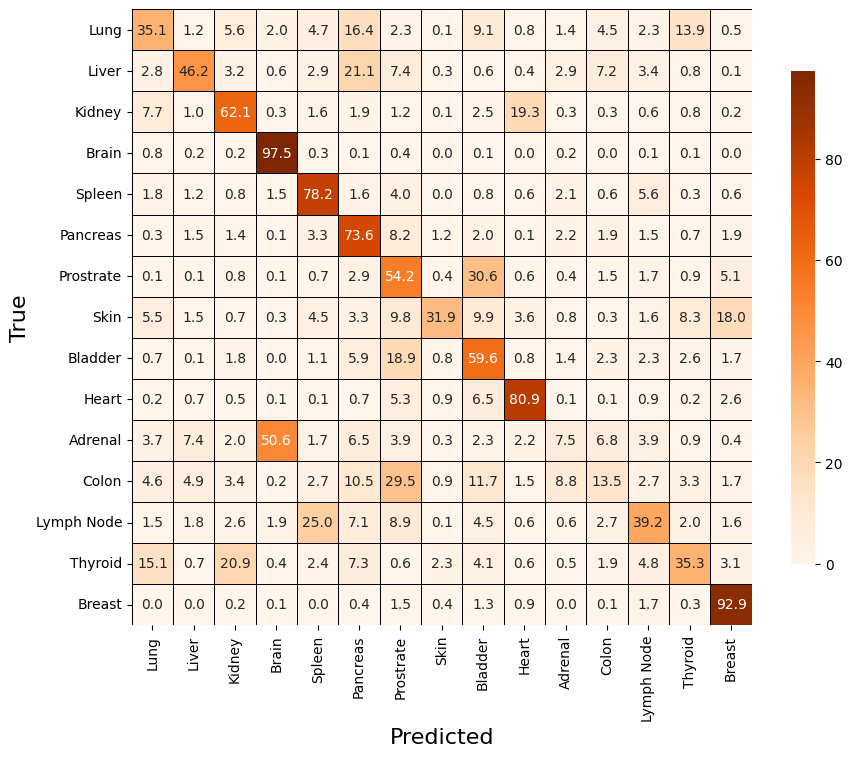

Slide-level Accuracy: 0.6912

Slide-level Classification Report:

              precision    recall  f1-score    support
Lung           1.000000  0.200000  0.333333   5.000000
Liver          1.000000  0.600000  0.750000   5.000000
Kidney         0.800000  0.800000  0.800000   5.000000
Brain          0.833333  1.000000  0.909091   5.000000
Spleen         0.714286  1.000000  0.833333   5.000000
Pancreas       0.714286  1.000000  0.833333   5.000000
Prostrate      0.375000  0.600000  0.461538   5.000000
Skin           1.000000  0.400000  0.571429   5.000000
Bladder        0.571429  0.800000  0.666667   5.000000
Heart          0.833333  1.000000  0.909091   5.000000
Adrenal        1.000000  0.333333  0.500000   3.000000
Colon          0.333333  0.333333  0.333333   3.000000
Lymph Node     1.000000  0.400000  0.571429   5.000000
Thyroid        0.400000  0.666667  0.500000   3.000000
Breast         0.800000  1.000000  0.888889   4.000000
accuracy       0.691176  0.691176  0.691176   0.691176

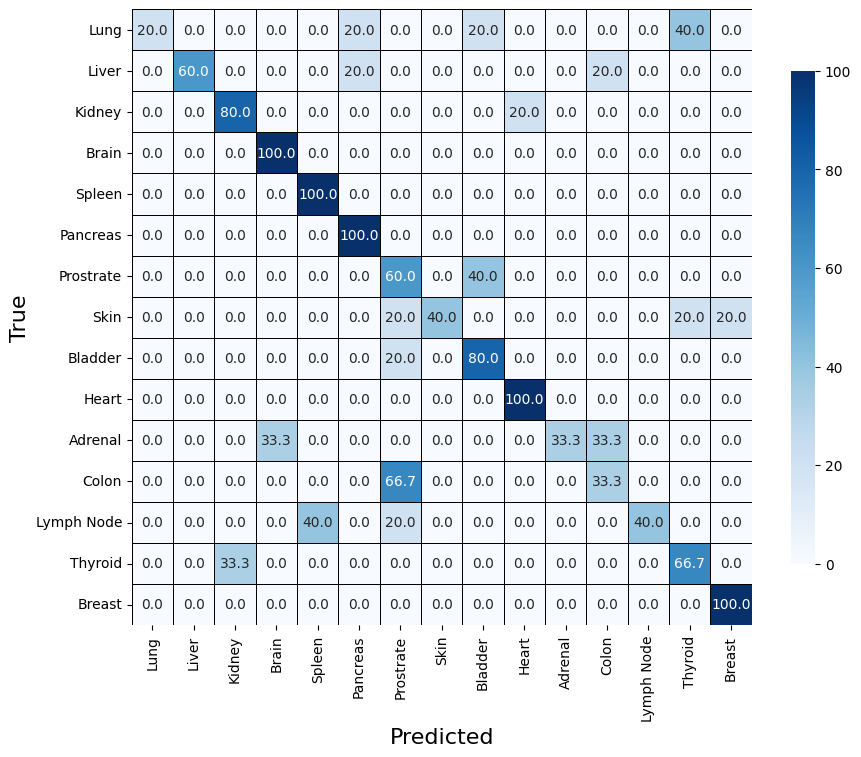

In [ ]:


# Define the mapping of organ numbers to names
organ_names = {
    0: "Lung", 1: "Liver", 2: "Kidney", 3: "Brain", 4: "Spleen",
    5: "Pancreas", 6: "Prostrate", 7: "Skin", 8: "Bladder", 9: "Heart",
    10: "Adrenal", 11: "Colon", 12: "Lymph Node", 13: "Thyroid", 14: "Breast"
}

# Assuming `all_labels`, `all_preds`, `num_classes`, `results_path`, and `model_name` are defined
# Convert the numeric labels to organ names for classification report
target_names = [organ_names[i] for i in range(num_classes)]

report_dict = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_csv_filename = results_path + model_name + "_patch_level_classification_report_test.csv"
report_df.to_csv(report_csv_filename)

# Print the report to the console
print("\nPatch-level Classification Report:\n")
print(report_df)

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

# Save the patch-level confusion matrix to a CSV file
cm_patch_df = pd.DataFrame(cm_patch_percentage, index=target_names, columns=target_names)
cm_patch_df.to_csv(results_path + model_name + "_patch_level_confusion_matrix_test.csv")

# Plot the patch-level confusion matrix with borders and save as PNG
plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Oranges', xticklabels=target_names, yticklabels=target_names, linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
# plt.title('Patch-level Confusion Matrix (in %)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(results_path + model_name + "_patch_level_confusion_matrix_test.png", bbox_inches='tight')
plt.show()

# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Convert the numeric labels to organ names for slide-level classification report
slide_report_dict = classification_report(slide_true_labels, slide_pred_labels, target_names=target_names, output_dict=True)

# Convert the dictionary to a DataFrame
slide_report_df = pd.DataFrame(slide_report_dict).transpose()

# Save the DataFrame to a CSV file
slide_report_csv_filename = results_path + model_name + "_slide_level_classification_report_test.csv"
slide_report_df.to_csv(slide_report_csv_filename)

# Print the report to the console
print("\nSlide-level Classification Report:\n")
print(slide_report_df)

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

# Save the slide-level confusion matrix to a CSV file
cm_slide_df = pd.DataFrame(cm_slide_percentage, index=target_names, columns=target_names)
cm_slide_df.to_csv(results_path + model_name + "_slide_level_confusion_matrix_test.csv")

# Plot the slide-level confusion matrix with borders and save as PNG
plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names, linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
# plt.title('Slide-level Confusion Matrix (in %)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_facecolor('white')  # Ensure the background is white to show borders
plt.savefig(results_path + model_name + "_slide_level_confusion_matrix_test.png", bbox_inches='tight')
plt.show()


In [ ]:
# Initialize variables
eval_loss = 0.0
eval_corrects = 0
eval_preds = []
eval_labels = []
eval_slide_predictions = defaultdict(list)
eval_slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(expanded_test_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        eval_loss += loss.item() * inputs.size(0)
        eval_corrects += torch.sum(preds == labels.data)

        eval_preds.extend(preds.cpu().numpy())
        eval_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            eval_slide_predictions[slide_id].append(pred)
            eval_slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = eval_corrects.double() / len(eval_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {eval_loss / len(eval_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")


Evaluating:   0%|          | 1/656 [00:04<52:36,  4.82s/batch]

Batch Loss: 0.6806, Batch Accuracy: 0.7969


Evaluating:   0%|          | 2/656 [00:07<38:27,  3.53s/batch]

Batch Loss: 1.2665, Batch Accuracy: 0.6406


Evaluating:   0%|          | 3/656 [00:10<34:37,  3.18s/batch]

Batch Loss: 2.3461, Batch Accuracy: 0.4531


Evaluating:   1%|          | 4/656 [00:12<32:02,  2.95s/batch]

Batch Loss: 2.3211, Batch Accuracy: 0.4082


Evaluating:   1%|          | 5/656 [00:15<31:38,  2.92s/batch]

Batch Loss: 2.2080, Batch Accuracy: 0.4031


Evaluating:   1%|          | 6/656 [00:18<30:04,  2.78s/batch]

Batch Loss: 2.4184, Batch Accuracy: 0.3802


Evaluating:   1%|          | 7/656 [00:20<29:16,  2.71s/batch]

Batch Loss: 2.5545, Batch Accuracy: 0.3516


Evaluating:   1%|          | 8/656 [00:23<28:51,  2.67s/batch]

Batch Loss: 2.5495, Batch Accuracy: 0.3477


Evaluating:   1%|▏         | 9/656 [00:25<28:36,  2.65s/batch]

Batch Loss: 2.4245, Batch Accuracy: 0.3663


Evaluating:   2%|▏         | 10/656 [00:28<29:14,  2.72s/batch]

Batch Loss: 2.5303, Batch Accuracy: 0.3547


Evaluating:   2%|▏         | 11/656 [00:31<29:28,  2.74s/batch]

Batch Loss: 2.5520, Batch Accuracy: 0.3416


Evaluating:   2%|▏         | 12/656 [00:34<29:24,  2.74s/batch]

Batch Loss: 2.4046, Batch Accuracy: 0.3750


Evaluating:   2%|▏         | 13/656 [00:36<28:55,  2.70s/batch]

Batch Loss: 2.2681, Batch Accuracy: 0.4050


Evaluating:   2%|▏         | 14/656 [00:39<28:24,  2.66s/batch]

Batch Loss: 2.4584, Batch Accuracy: 0.3923


Evaluating:   2%|▏         | 15/656 [00:42<28:02,  2.62s/batch]

Batch Loss: 2.5656, Batch Accuracy: 0.3750


Evaluating:   2%|▏         | 16/656 [00:44<27:45,  2.60s/batch]

Batch Loss: 2.4554, Batch Accuracy: 0.3989


Evaluating:   3%|▎         | 17/656 [00:47<27:37,  2.59s/batch]

Batch Loss: 2.4012, Batch Accuracy: 0.4076


Evaluating:   3%|▎         | 18/656 [00:49<27:17,  2.57s/batch]

Batch Loss: 2.3905, Batch Accuracy: 0.3993


Evaluating:   3%|▎         | 19/656 [00:52<27:44,  2.61s/batch]

Batch Loss: 2.4624, Batch Accuracy: 0.3877


Evaluating:   3%|▎         | 20/656 [00:54<27:08,  2.56s/batch]

Batch Loss: 2.4787, Batch Accuracy: 0.3863


Evaluating:   3%|▎         | 21/656 [00:57<27:12,  2.57s/batch]

Batch Loss: 2.4510, Batch Accuracy: 0.3936


Evaluating:   3%|▎         | 22/656 [00:59<26:52,  2.54s/batch]

Batch Loss: 2.3968, Batch Accuracy: 0.4066


Evaluating:   4%|▎         | 23/656 [01:02<26:34,  2.52s/batch]

Batch Loss: 2.4912, Batch Accuracy: 0.3933


Evaluating:   4%|▎         | 24/656 [01:04<26:42,  2.54s/batch]

Batch Loss: 2.4747, Batch Accuracy: 0.3945


Evaluating:   4%|▍         | 25/656 [01:07<26:21,  2.51s/batch]

Batch Loss: 2.4843, Batch Accuracy: 0.3869


Evaluating:   4%|▍         | 26/656 [01:09<26:32,  2.53s/batch]

Batch Loss: 2.4791, Batch Accuracy: 0.3807


Evaluating:   4%|▍         | 27/656 [01:12<26:32,  2.53s/batch]

Batch Loss: 2.4699, Batch Accuracy: 0.3773


Evaluating:   4%|▍         | 28/656 [01:15<26:27,  2.53s/batch]

Batch Loss: 2.4445, Batch Accuracy: 0.3814


Evaluating:   4%|▍         | 29/656 [01:17<26:43,  2.56s/batch]

Batch Loss: 2.4089, Batch Accuracy: 0.3844


Evaluating:   5%|▍         | 30/656 [01:20<26:25,  2.53s/batch]

Batch Loss: 2.4829, Batch Accuracy: 0.3747


Evaluating:   5%|▍         | 31/656 [01:22<26:12,  2.52s/batch]

Batch Loss: 2.5858, Batch Accuracy: 0.3644


Evaluating:   5%|▍         | 32/656 [01:25<26:18,  2.53s/batch]

Batch Loss: 2.5600, Batch Accuracy: 0.3679


Evaluating:   5%|▌         | 33/656 [01:27<26:40,  2.57s/batch]

Batch Loss: 2.6405, Batch Accuracy: 0.3596


Evaluating:   5%|▌         | 34/656 [01:30<26:42,  2.58s/batch]

Batch Loss: 2.6347, Batch Accuracy: 0.3564


Evaluating:   5%|▌         | 35/656 [01:32<26:18,  2.54s/batch]

Batch Loss: 2.6537, Batch Accuracy: 0.3513


Evaluating:   5%|▌         | 36/656 [01:35<26:35,  2.57s/batch]

Batch Loss: 2.6402, Batch Accuracy: 0.3503


Evaluating:   6%|▌         | 37/656 [01:37<26:08,  2.53s/batch]

Batch Loss: 2.6558, Batch Accuracy: 0.3473


Evaluating:   6%|▌         | 38/656 [01:40<26:10,  2.54s/batch]

Batch Loss: 2.6231, Batch Accuracy: 0.3524


Evaluating:   6%|▌         | 39/656 [01:43<26:04,  2.54s/batch]

Batch Loss: 2.5808, Batch Accuracy: 0.3622


Evaluating:   6%|▌         | 40/656 [01:45<26:03,  2.54s/batch]

Batch Loss: 2.5866, Batch Accuracy: 0.3600


Evaluating:   6%|▋         | 41/656 [01:48<25:54,  2.53s/batch]

Batch Loss: 2.5523, Batch Accuracy: 0.3681


Evaluating:   6%|▋         | 42/656 [01:50<26:00,  2.54s/batch]

Batch Loss: 2.5416, Batch Accuracy: 0.3674


Evaluating:   7%|▋         | 43/656 [01:53<25:45,  2.52s/batch]

Batch Loss: 2.5532, Batch Accuracy: 0.3641


Evaluating:   7%|▋         | 44/656 [01:55<25:32,  2.50s/batch]

Batch Loss: 2.5304, Batch Accuracy: 0.3659


Evaluating:   7%|▋         | 45/656 [01:58<25:19,  2.49s/batch]

Batch Loss: 2.5133, Batch Accuracy: 0.3684


Evaluating:   7%|▋         | 46/656 [02:00<25:28,  2.51s/batch]

Batch Loss: 2.5013, Batch Accuracy: 0.3689


Evaluating:   7%|▋         | 47/656 [02:03<25:32,  2.52s/batch]

Batch Loss: 2.4663, Batch Accuracy: 0.3775


Evaluating:   7%|▋         | 48/656 [02:05<25:23,  2.51s/batch]

Batch Loss: 2.4859, Batch Accuracy: 0.3727


Evaluating:   7%|▋         | 49/656 [02:08<25:25,  2.51s/batch]

Batch Loss: 2.4892, Batch Accuracy: 0.3729


Evaluating:   8%|▊         | 50/656 [02:10<25:16,  2.50s/batch]

Batch Loss: 2.5299, Batch Accuracy: 0.3689


Evaluating:   8%|▊         | 51/656 [02:13<25:57,  2.57s/batch]

Batch Loss: 2.5145, Batch Accuracy: 0.3699


Evaluating:   8%|▊         | 52/656 [02:15<26:03,  2.59s/batch]

Batch Loss: 2.5372, Batch Accuracy: 0.3642


Evaluating:   8%|▊         | 53/656 [02:18<25:42,  2.56s/batch]

Batch Loss: 2.5820, Batch Accuracy: 0.3582


Evaluating:   8%|▊         | 54/656 [02:21<25:50,  2.58s/batch]

Batch Loss: 2.5816, Batch Accuracy: 0.3571


Evaluating:   8%|▊         | 55/656 [02:23<25:42,  2.57s/batch]

Batch Loss: 2.5665, Batch Accuracy: 0.3588


Evaluating:   9%|▊         | 56/656 [02:26<25:49,  2.58s/batch]

Batch Loss: 2.5538, Batch Accuracy: 0.3598


Evaluating:   9%|▊         | 57/656 [02:28<25:59,  2.60s/batch]

Batch Loss: 2.5472, Batch Accuracy: 0.3586


Evaluating:   9%|▉         | 58/656 [02:31<25:35,  2.57s/batch]

Batch Loss: 2.5410, Batch Accuracy: 0.3578


Evaluating:   9%|▉         | 59/656 [02:34<26:11,  2.63s/batch]

Batch Loss: 2.5525, Batch Accuracy: 0.3578


Evaluating:   9%|▉         | 60/656 [02:36<25:42,  2.59s/batch]

Batch Loss: 2.5741, Batch Accuracy: 0.3547


Evaluating:   9%|▉         | 61/656 [02:39<25:26,  2.57s/batch]

Batch Loss: 2.5585, Batch Accuracy: 0.3569


Evaluating:   9%|▉         | 62/656 [02:41<25:44,  2.60s/batch]

Batch Loss: 2.5317, Batch Accuracy: 0.3625


Evaluating:  10%|▉         | 63/656 [02:44<25:30,  2.58s/batch]

Batch Loss: 2.5478, Batch Accuracy: 0.3626


Evaluating:  10%|▉         | 64/656 [02:46<25:09,  2.55s/batch]

Batch Loss: 2.5930, Batch Accuracy: 0.3574


Evaluating:  10%|▉         | 65/656 [02:49<25:41,  2.61s/batch]

Batch Loss: 2.6737, Batch Accuracy: 0.3523


Evaluating:  10%|█         | 66/656 [02:52<25:28,  2.59s/batch]

Batch Loss: 2.6979, Batch Accuracy: 0.3484


Evaluating:  10%|█         | 67/656 [02:54<25:56,  2.64s/batch]

Batch Loss: 2.6946, Batch Accuracy: 0.3496


Evaluating:  10%|█         | 68/656 [02:57<26:20,  2.69s/batch]

Batch Loss: 2.7114, Batch Accuracy: 0.3465


Evaluating:  11%|█         | 69/656 [03:00<25:37,  2.62s/batch]

Batch Loss: 2.6924, Batch Accuracy: 0.3508


Evaluating:  11%|█         | 70/656 [03:02<25:07,  2.57s/batch]

Batch Loss: 2.6745, Batch Accuracy: 0.3539


Evaluating:  11%|█         | 71/656 [03:05<25:09,  2.58s/batch]

Batch Loss: 2.6713, Batch Accuracy: 0.3527


Evaluating:  11%|█         | 72/656 [03:07<25:27,  2.62s/batch]

Batch Loss: 2.6519, Batch Accuracy: 0.3562


Evaluating:  11%|█         | 73/656 [03:10<24:55,  2.56s/batch]

Batch Loss: 2.6332, Batch Accuracy: 0.3600


Evaluating:  11%|█▏        | 74/656 [03:12<24:36,  2.54s/batch]

Batch Loss: 2.6416, Batch Accuracy: 0.3594


Evaluating:  11%|█▏        | 75/656 [03:15<24:34,  2.54s/batch]

Batch Loss: 2.6323, Batch Accuracy: 0.3605


Evaluating:  12%|█▏        | 76/656 [03:17<24:32,  2.54s/batch]

Batch Loss: 2.6349, Batch Accuracy: 0.3603


Evaluating:  12%|█▏        | 77/656 [03:20<24:31,  2.54s/batch]

Batch Loss: 2.6673, Batch Accuracy: 0.3570


Evaluating:  12%|█▏        | 78/656 [03:22<24:19,  2.52s/batch]

Batch Loss: 2.6522, Batch Accuracy: 0.3595


Evaluating:  12%|█▏        | 79/656 [03:25<24:33,  2.55s/batch]

Batch Loss: 2.6580, Batch Accuracy: 0.3571


Evaluating:  12%|█▏        | 80/656 [03:28<25:28,  2.65s/batch]

Batch Loss: 2.6749, Batch Accuracy: 0.3542


Evaluating:  12%|█▏        | 81/656 [03:30<24:51,  2.59s/batch]

Batch Loss: 2.6686, Batch Accuracy: 0.3539


Evaluating:  12%|█▎        | 82/656 [03:33<24:39,  2.58s/batch]

Batch Loss: 2.6518, Batch Accuracy: 0.3574


Evaluating:  13%|█▎        | 83/656 [03:36<24:38,  2.58s/batch]

Batch Loss: 2.6407, Batch Accuracy: 0.3591


Evaluating:  13%|█▎        | 84/656 [03:38<24:16,  2.55s/batch]

Batch Loss: 2.6344, Batch Accuracy: 0.3596


Evaluating:  13%|█▎        | 85/656 [03:41<24:04,  2.53s/batch]

Batch Loss: 2.6466, Batch Accuracy: 0.3568


Evaluating:  13%|█▎        | 86/656 [03:43<24:07,  2.54s/batch]

Batch Loss: 2.6345, Batch Accuracy: 0.3586


Evaluating:  13%|█▎        | 87/656 [03:46<24:02,  2.54s/batch]

Batch Loss: 2.6256, Batch Accuracy: 0.3584


Evaluating:  13%|█▎        | 88/656 [03:48<23:49,  2.52s/batch]

Batch Loss: 2.6199, Batch Accuracy: 0.3581


Evaluating:  14%|█▎        | 89/656 [03:51<23:51,  2.52s/batch]

Batch Loss: 2.6077, Batch Accuracy: 0.3604


Evaluating:  14%|█▎        | 90/656 [03:53<23:46,  2.52s/batch]

Batch Loss: 2.5965, Batch Accuracy: 0.3620


Evaluating:  14%|█▍        | 91/656 [03:56<24:27,  2.60s/batch]

Batch Loss: 2.5956, Batch Accuracy: 0.3618


Evaluating:  14%|█▍        | 92/656 [03:59<24:33,  2.61s/batch]

Batch Loss: 2.5789, Batch Accuracy: 0.3651


Evaluating:  14%|█▍        | 93/656 [04:01<24:47,  2.64s/batch]

Batch Loss: 2.5872, Batch Accuracy: 0.3631


Evaluating:  14%|█▍        | 94/656 [04:04<24:35,  2.62s/batch]

Batch Loss: 2.5800, Batch Accuracy: 0.3637


Evaluating:  14%|█▍        | 95/656 [04:06<24:05,  2.58s/batch]

Batch Loss: 2.5761, Batch Accuracy: 0.3637


Evaluating:  15%|█▍        | 96/656 [04:09<23:44,  2.54s/batch]

Batch Loss: 2.5628, Batch Accuracy: 0.3661


Evaluating:  15%|█▍        | 97/656 [04:11<23:29,  2.52s/batch]

Batch Loss: 2.5502, Batch Accuracy: 0.3682


Evaluating:  15%|█▍        | 98/656 [04:14<23:36,  2.54s/batch]

Batch Loss: 2.5513, Batch Accuracy: 0.3668


Evaluating:  15%|█▌        | 99/656 [04:16<23:25,  2.52s/batch]

Batch Loss: 2.5576, Batch Accuracy: 0.3662


Evaluating:  15%|█▌        | 100/656 [04:19<24:00,  2.59s/batch]

Batch Loss: 2.5818, Batch Accuracy: 0.3634


Evaluating:  15%|█▌        | 101/656 [04:22<23:56,  2.59s/batch]

Batch Loss: 2.5778, Batch Accuracy: 0.3632


Evaluating:  16%|█▌        | 102/656 [04:24<24:22,  2.64s/batch]

Batch Loss: 2.5837, Batch Accuracy: 0.3609


Evaluating:  16%|█▌        | 103/656 [04:28<25:45,  2.80s/batch]

Batch Loss: 2.5808, Batch Accuracy: 0.3600


Evaluating:  16%|█▌        | 104/656 [04:30<24:58,  2.71s/batch]

Batch Loss: 2.5810, Batch Accuracy: 0.3601


Evaluating:  16%|█▌        | 105/656 [04:33<24:18,  2.65s/batch]

Batch Loss: 2.5749, Batch Accuracy: 0.3603


Evaluating:  16%|█▌        | 106/656 [04:35<24:00,  2.62s/batch]

Batch Loss: 2.5810, Batch Accuracy: 0.3592


Evaluating:  16%|█▋        | 107/656 [04:38<23:41,  2.59s/batch]

Batch Loss: 2.5741, Batch Accuracy: 0.3605


Evaluating:  16%|█▋        | 108/656 [04:40<23:20,  2.56s/batch]

Batch Loss: 2.5648, Batch Accuracy: 0.3622


Evaluating:  17%|█▋        | 109/656 [04:43<23:04,  2.53s/batch]

Batch Loss: 2.5665, Batch Accuracy: 0.3610


Evaluating:  17%|█▋        | 110/656 [04:45<22:53,  2.52s/batch]

Batch Loss: 2.5647, Batch Accuracy: 0.3607


Evaluating:  17%|█▋        | 111/656 [04:48<23:10,  2.55s/batch]

Batch Loss: 2.5673, Batch Accuracy: 0.3589


Evaluating:  17%|█▋        | 112/656 [04:50<23:21,  2.58s/batch]

Batch Loss: 2.5791, Batch Accuracy: 0.3573


Evaluating:  17%|█▋        | 113/656 [04:53<22:59,  2.54s/batch]

Batch Loss: 2.5844, Batch Accuracy: 0.3558


Evaluating:  17%|█▋        | 114/656 [04:55<23:01,  2.55s/batch]

Batch Loss: 2.5778, Batch Accuracy: 0.3557


Evaluating:  18%|█▊        | 115/656 [04:58<22:55,  2.54s/batch]

Batch Loss: 2.5952, Batch Accuracy: 0.3539


Evaluating:  18%|█▊        | 116/656 [05:01<23:01,  2.56s/batch]

Batch Loss: 2.5904, Batch Accuracy: 0.3535


Evaluating:  18%|█▊        | 117/656 [05:03<22:40,  2.52s/batch]

Batch Loss: 2.5829, Batch Accuracy: 0.3544


Evaluating:  18%|█▊        | 118/656 [05:06<23:19,  2.60s/batch]

Batch Loss: 2.5775, Batch Accuracy: 0.3567


Evaluating:  18%|█▊        | 119/656 [05:08<23:10,  2.59s/batch]

Batch Loss: 2.5808, Batch Accuracy: 0.3554


Evaluating:  18%|█▊        | 120/656 [05:11<22:50,  2.56s/batch]

Batch Loss: 2.6029, Batch Accuracy: 0.3553


Evaluating:  18%|█▊        | 121/656 [05:13<22:49,  2.56s/batch]

Batch Loss: 2.6139, Batch Accuracy: 0.3556


Evaluating:  19%|█▊        | 122/656 [05:16<22:35,  2.54s/batch]

Batch Loss: 2.6160, Batch Accuracy: 0.3541


Evaluating:  19%|█▉        | 123/656 [05:18<22:29,  2.53s/batch]

Batch Loss: 2.6282, Batch Accuracy: 0.3522


Evaluating:  19%|█▉        | 124/656 [05:21<22:46,  2.57s/batch]

Batch Loss: 2.6336, Batch Accuracy: 0.3513


Evaluating:  19%|█▉        | 125/656 [05:24<22:42,  2.57s/batch]

Batch Loss: 2.6243, Batch Accuracy: 0.3532


Evaluating:  19%|█▉        | 126/656 [05:26<22:47,  2.58s/batch]

Batch Loss: 2.6279, Batch Accuracy: 0.3534


Evaluating:  19%|█▉        | 127/656 [05:29<22:51,  2.59s/batch]

Batch Loss: 2.6535, Batch Accuracy: 0.3510


Evaluating:  20%|█▉        | 128/656 [05:31<22:50,  2.60s/batch]

Batch Loss: 2.6559, Batch Accuracy: 0.3501


Evaluating:  20%|█▉        | 129/656 [05:34<22:29,  2.56s/batch]

Batch Loss: 2.6648, Batch Accuracy: 0.3477


Evaluating:  20%|█▉        | 130/656 [05:36<22:16,  2.54s/batch]

Batch Loss: 2.6653, Batch Accuracy: 0.3465


Evaluating:  20%|█▉        | 131/656 [05:39<22:07,  2.53s/batch]

Batch Loss: 2.6694, Batch Accuracy: 0.3453


Evaluating:  20%|██        | 132/656 [05:41<22:05,  2.53s/batch]

Batch Loss: 2.6639, Batch Accuracy: 0.3465


Evaluating:  20%|██        | 133/656 [05:44<22:11,  2.55s/batch]

Batch Loss: 2.6719, Batch Accuracy: 0.3450


Evaluating:  20%|██        | 134/656 [05:46<21:58,  2.53s/batch]

Batch Loss: 2.6694, Batch Accuracy: 0.3450


Evaluating:  21%|██        | 135/656 [05:49<21:48,  2.51s/batch]

Batch Loss: 2.6624, Batch Accuracy: 0.3465


Evaluating:  21%|██        | 136/656 [05:52<22:03,  2.55s/batch]

Batch Loss: 2.6517, Batch Accuracy: 0.3486


Evaluating:  21%|██        | 137/656 [05:54<21:58,  2.54s/batch]

Batch Loss: 2.6410, Batch Accuracy: 0.3509


Evaluating:  21%|██        | 138/656 [05:57<21:59,  2.55s/batch]

Batch Loss: 2.6630, Batch Accuracy: 0.3498


Evaluating:  21%|██        | 139/656 [05:59<22:02,  2.56s/batch]

Batch Loss: 2.6727, Batch Accuracy: 0.3491


Evaluating:  21%|██▏       | 140/656 [06:02<21:48,  2.54s/batch]

Batch Loss: 2.6782, Batch Accuracy: 0.3482


Evaluating:  21%|██▏       | 141/656 [06:04<22:03,  2.57s/batch]

Batch Loss: 2.6718, Batch Accuracy: 0.3492


Evaluating:  22%|██▏       | 142/656 [06:07<21:58,  2.57s/batch]

Batch Loss: 2.6722, Batch Accuracy: 0.3482


Evaluating:  22%|██▏       | 143/656 [06:09<21:50,  2.55s/batch]

Batch Loss: 2.6692, Batch Accuracy: 0.3477


Evaluating:  22%|██▏       | 144/656 [06:12<22:24,  2.63s/batch]

Batch Loss: 2.6721, Batch Accuracy: 0.3467


Evaluating:  22%|██▏       | 145/656 [06:15<21:54,  2.57s/batch]

Batch Loss: 2.6643, Batch Accuracy: 0.3476


Evaluating:  22%|██▏       | 146/656 [06:17<21:48,  2.57s/batch]

Batch Loss: 2.6565, Batch Accuracy: 0.3488


Evaluating:  22%|██▏       | 147/656 [06:20<21:30,  2.54s/batch]

Batch Loss: 2.6767, Batch Accuracy: 0.3470


Evaluating:  23%|██▎       | 148/656 [06:22<21:17,  2.51s/batch]

Batch Loss: 2.6845, Batch Accuracy: 0.3454


Evaluating:  23%|██▎       | 149/656 [06:25<21:13,  2.51s/batch]

Batch Loss: 2.6820, Batch Accuracy: 0.3458


Evaluating:  23%|██▎       | 150/656 [06:28<22:17,  2.64s/batch]

Batch Loss: 2.6688, Batch Accuracy: 0.3485


Evaluating:  23%|██▎       | 151/656 [06:30<21:42,  2.58s/batch]

Batch Loss: 2.6635, Batch Accuracy: 0.3495


Evaluating:  23%|██▎       | 152/656 [06:33<21:31,  2.56s/batch]

Batch Loss: 2.6602, Batch Accuracy: 0.3499


Evaluating:  23%|██▎       | 153/656 [06:35<21:57,  2.62s/batch]

Batch Loss: 2.6592, Batch Accuracy: 0.3492


Evaluating:  23%|██▎       | 154/656 [06:38<21:34,  2.58s/batch]

Batch Loss: 2.6558, Batch Accuracy: 0.3499


Evaluating:  24%|██▎       | 155/656 [06:40<21:21,  2.56s/batch]

Batch Loss: 2.6752, Batch Accuracy: 0.3478


Evaluating:  24%|██▍       | 156/656 [06:43<21:07,  2.53s/batch]

Batch Loss: 2.6723, Batch Accuracy: 0.3483


Evaluating:  24%|██▍       | 157/656 [06:45<21:03,  2.53s/batch]

Batch Loss: 2.6656, Batch Accuracy: 0.3489


Evaluating:  24%|██▍       | 158/656 [06:48<20:59,  2.53s/batch]

Batch Loss: 2.6563, Batch Accuracy: 0.3505


Evaluating:  24%|██▍       | 159/656 [06:51<21:20,  2.58s/batch]

Batch Loss: 2.6456, Batch Accuracy: 0.3527


Evaluating:  24%|██▍       | 160/656 [06:53<21:00,  2.54s/batch]

Batch Loss: 2.6441, Batch Accuracy: 0.3519


Evaluating:  25%|██▍       | 161/656 [06:56<21:18,  2.58s/batch]

Batch Loss: 2.6437, Batch Accuracy: 0.3508


Evaluating:  25%|██▍       | 162/656 [06:58<21:11,  2.57s/batch]

Batch Loss: 2.6506, Batch Accuracy: 0.3498


Evaluating:  25%|██▍       | 163/656 [07:01<21:01,  2.56s/batch]

Batch Loss: 2.6499, Batch Accuracy: 0.3492


Evaluating:  25%|██▌       | 164/656 [07:03<20:49,  2.54s/batch]

Batch Loss: 2.6464, Batch Accuracy: 0.3498


Evaluating:  25%|██▌       | 165/656 [07:06<20:35,  2.52s/batch]

Batch Loss: 2.6445, Batch Accuracy: 0.3500


Evaluating:  25%|██▌       | 166/656 [07:08<20:55,  2.56s/batch]

Batch Loss: 2.6466, Batch Accuracy: 0.3494


Evaluating:  25%|██▌       | 167/656 [07:11<20:37,  2.53s/batch]

Batch Loss: 2.6444, Batch Accuracy: 0.3498


Evaluating:  26%|██▌       | 168/656 [07:13<20:36,  2.53s/batch]

Batch Loss: 2.6358, Batch Accuracy: 0.3513


Evaluating:  26%|██▌       | 169/656 [07:16<20:32,  2.53s/batch]

Batch Loss: 2.6345, Batch Accuracy: 0.3510


Evaluating:  26%|██▌       | 170/656 [07:18<20:25,  2.52s/batch]

Batch Loss: 2.6282, Batch Accuracy: 0.3514


Evaluating:  26%|██▌       | 171/656 [07:21<20:33,  2.54s/batch]

Batch Loss: 2.6190, Batch Accuracy: 0.3530


Evaluating:  26%|██▌       | 172/656 [07:24<20:27,  2.54s/batch]

Batch Loss: 2.6199, Batch Accuracy: 0.3525


Evaluating:  26%|██▋       | 173/656 [07:26<21:02,  2.61s/batch]

Batch Loss: 2.6204, Batch Accuracy: 0.3533


Evaluating:  27%|██▋       | 174/656 [07:29<21:34,  2.69s/batch]

Batch Loss: 2.6402, Batch Accuracy: 0.3516


Evaluating:  27%|██▋       | 175/656 [07:32<21:07,  2.63s/batch]

Batch Loss: 2.6441, Batch Accuracy: 0.3504


Evaluating:  27%|██▋       | 176/656 [07:34<20:56,  2.62s/batch]

Batch Loss: 2.6424, Batch Accuracy: 0.3505


Evaluating:  27%|██▋       | 177/656 [07:37<20:35,  2.58s/batch]

Batch Loss: 2.6422, Batch Accuracy: 0.3507


Evaluating:  27%|██▋       | 178/656 [07:39<20:37,  2.59s/batch]

Batch Loss: 2.6480, Batch Accuracy: 0.3503


Evaluating:  27%|██▋       | 179/656 [07:42<20:54,  2.63s/batch]

Batch Loss: 2.6417, Batch Accuracy: 0.3518


Evaluating:  27%|██▋       | 180/656 [07:45<20:32,  2.59s/batch]

Batch Loss: 2.6353, Batch Accuracy: 0.3532


Evaluating:  28%|██▊       | 181/656 [07:47<20:26,  2.58s/batch]

Batch Loss: 2.6343, Batch Accuracy: 0.3529


Evaluating:  28%|██▊       | 182/656 [07:50<20:44,  2.63s/batch]

Batch Loss: 2.6271, Batch Accuracy: 0.3545


Evaluating:  28%|██▊       | 183/656 [07:52<20:26,  2.59s/batch]

Batch Loss: 2.6200, Batch Accuracy: 0.3554


Evaluating:  28%|██▊       | 184/656 [07:55<20:17,  2.58s/batch]

Batch Loss: 2.6159, Batch Accuracy: 0.3564


Evaluating:  28%|██▊       | 185/656 [07:57<20:03,  2.55s/batch]

Batch Loss: 2.6199, Batch Accuracy: 0.3551


Evaluating:  28%|██▊       | 186/656 [08:00<19:50,  2.53s/batch]

Batch Loss: 2.6397, Batch Accuracy: 0.3535


Evaluating:  29%|██▊       | 187/656 [08:02<19:48,  2.53s/batch]

Batch Loss: 2.6617, Batch Accuracy: 0.3518


Evaluating:  29%|██▊       | 188/656 [08:05<19:47,  2.54s/batch]

Batch Loss: 2.6608, Batch Accuracy: 0.3511


Evaluating:  29%|██▉       | 189/656 [08:08<19:43,  2.53s/batch]

Batch Loss: 2.6557, Batch Accuracy: 0.3518


Evaluating:  29%|██▉       | 190/656 [08:10<19:33,  2.52s/batch]

Batch Loss: 2.6480, Batch Accuracy: 0.3532


Evaluating:  29%|██▉       | 191/656 [08:13<19:55,  2.57s/batch]

Batch Loss: 2.6509, Batch Accuracy: 0.3519


Evaluating:  29%|██▉       | 192/656 [08:15<19:46,  2.56s/batch]

Batch Loss: 2.6731, Batch Accuracy: 0.3504


Evaluating:  29%|██▉       | 193/656 [08:18<19:32,  2.53s/batch]

Batch Loss: 2.6688, Batch Accuracy: 0.3528


Evaluating:  30%|██▉       | 194/656 [08:20<19:42,  2.56s/batch]

Batch Loss: 2.6662, Batch Accuracy: 0.3527


Evaluating:  30%|██▉       | 195/656 [08:23<19:27,  2.53s/batch]

Batch Loss: 2.6645, Batch Accuracy: 0.3525


Evaluating:  30%|██▉       | 196/656 [08:25<19:33,  2.55s/batch]

Batch Loss: 2.6650, Batch Accuracy: 0.3518


Evaluating:  30%|███       | 197/656 [08:28<20:13,  2.64s/batch]

Batch Loss: 2.6668, Batch Accuracy: 0.3507


Evaluating:  30%|███       | 198/656 [08:31<19:47,  2.59s/batch]

Batch Loss: 2.6662, Batch Accuracy: 0.3511


Evaluating:  30%|███       | 199/656 [08:33<19:36,  2.57s/batch]

Batch Loss: 2.6747, Batch Accuracy: 0.3500


Evaluating:  30%|███       | 200/656 [08:36<19:24,  2.55s/batch]

Batch Loss: 2.6809, Batch Accuracy: 0.3484


Evaluating:  31%|███       | 201/656 [08:38<19:14,  2.54s/batch]

Batch Loss: 2.6743, Batch Accuracy: 0.3498


Evaluating:  31%|███       | 202/656 [08:41<19:23,  2.56s/batch]

Batch Loss: 2.6769, Batch Accuracy: 0.3486


Evaluating:  31%|███       | 203/656 [08:44<19:33,  2.59s/batch]

Batch Loss: 2.6815, Batch Accuracy: 0.3478


Evaluating:  31%|███       | 204/656 [08:46<19:22,  2.57s/batch]

Batch Loss: 2.6883, Batch Accuracy: 0.3471


Evaluating:  31%|███▏      | 205/656 [08:49<19:10,  2.55s/batch]

Batch Loss: 2.6801, Batch Accuracy: 0.3489


Evaluating:  31%|███▏      | 206/656 [08:51<19:16,  2.57s/batch]

Batch Loss: 2.6803, Batch Accuracy: 0.3490


Evaluating:  32%|███▏      | 207/656 [08:54<19:10,  2.56s/batch]

Batch Loss: 2.6809, Batch Accuracy: 0.3489


Evaluating:  32%|███▏      | 208/656 [08:56<18:54,  2.53s/batch]

Batch Loss: 2.6740, Batch Accuracy: 0.3501


Evaluating:  32%|███▏      | 209/656 [08:59<19:02,  2.56s/batch]

Batch Loss: 2.6679, Batch Accuracy: 0.3507


Evaluating:  32%|███▏      | 210/656 [09:01<18:51,  2.54s/batch]

Batch Loss: 2.6591, Batch Accuracy: 0.3526


Evaluating:  32%|███▏      | 211/656 [09:04<18:47,  2.53s/batch]

Batch Loss: 2.6547, Batch Accuracy: 0.3531


Evaluating:  32%|███▏      | 212/656 [09:07<19:22,  2.62s/batch]

Batch Loss: 2.6615, Batch Accuracy: 0.3526


Evaluating:  32%|███▏      | 213/656 [09:09<18:58,  2.57s/batch]

Batch Loss: 2.6559, Batch Accuracy: 0.3534


Evaluating:  33%|███▎      | 214/656 [09:12<18:46,  2.55s/batch]

Batch Loss: 2.6549, Batch Accuracy: 0.3528


Evaluating:  33%|███▎      | 215/656 [09:14<18:43,  2.55s/batch]

Batch Loss: 2.6530, Batch Accuracy: 0.3529


Evaluating:  33%|███▎      | 216/656 [09:17<19:02,  2.60s/batch]

Batch Loss: 2.6587, Batch Accuracy: 0.3519


Evaluating:  33%|███▎      | 217/656 [09:19<18:38,  2.55s/batch]

Batch Loss: 2.6510, Batch Accuracy: 0.3535


Evaluating:  33%|███▎      | 218/656 [09:22<18:54,  2.59s/batch]

Batch Loss: 2.6476, Batch Accuracy: 0.3542


Evaluating:  33%|███▎      | 219/656 [09:25<18:45,  2.58s/batch]

Batch Loss: 2.6501, Batch Accuracy: 0.3537


Evaluating:  34%|███▎      | 220/656 [09:27<18:52,  2.60s/batch]

Batch Loss: 2.6482, Batch Accuracy: 0.3537


Evaluating:  34%|███▎      | 221/656 [09:30<18:40,  2.58s/batch]

Batch Loss: 2.6447, Batch Accuracy: 0.3538


Evaluating:  34%|███▍      | 222/656 [09:32<18:32,  2.56s/batch]

Batch Loss: 2.6447, Batch Accuracy: 0.3534


Evaluating:  34%|███▍      | 223/656 [09:35<18:20,  2.54s/batch]

Batch Loss: 2.6472, Batch Accuracy: 0.3524


Evaluating:  34%|███▍      | 224/656 [09:37<18:10,  2.52s/batch]

Batch Loss: 2.6457, Batch Accuracy: 0.3522


Evaluating:  34%|███▍      | 225/656 [09:40<18:32,  2.58s/batch]

Batch Loss: 2.6480, Batch Accuracy: 0.3512


Evaluating:  34%|███▍      | 226/656 [09:42<18:15,  2.55s/batch]

Batch Loss: 2.6435, Batch Accuracy: 0.3516


Evaluating:  35%|███▍      | 227/656 [09:45<18:14,  2.55s/batch]

Batch Loss: 2.6422, Batch Accuracy: 0.3513


Evaluating:  35%|███▍      | 228/656 [09:48<18:20,  2.57s/batch]

Batch Loss: 2.6420, Batch Accuracy: 0.3509


Evaluating:  35%|███▍      | 229/656 [09:50<18:23,  2.58s/batch]

Batch Loss: 2.6417, Batch Accuracy: 0.3505


Evaluating:  35%|███▌      | 230/656 [09:53<18:15,  2.57s/batch]

Batch Loss: 2.6424, Batch Accuracy: 0.3501


Evaluating:  35%|███▌      | 231/656 [09:55<18:13,  2.57s/batch]

Batch Loss: 2.6405, Batch Accuracy: 0.3505


Evaluating:  35%|███▌      | 232/656 [09:58<18:01,  2.55s/batch]

Batch Loss: 2.6473, Batch Accuracy: 0.3491


Evaluating:  36%|███▌      | 233/656 [10:00<17:52,  2.54s/batch]

Batch Loss: 2.6439, Batch Accuracy: 0.3500


Evaluating:  36%|███▌      | 234/656 [10:03<18:10,  2.58s/batch]

Batch Loss: 2.6417, Batch Accuracy: 0.3503


Evaluating:  36%|███▌      | 235/656 [10:05<17:54,  2.55s/batch]

Batch Loss: 2.6333, Batch Accuracy: 0.3523


Evaluating:  36%|███▌      | 236/656 [10:08<18:02,  2.58s/batch]

Batch Loss: 2.6446, Batch Accuracy: 0.3514


Evaluating:  36%|███▌      | 237/656 [10:11<18:24,  2.64s/batch]

Batch Loss: 2.6427, Batch Accuracy: 0.3519


Evaluating:  36%|███▋      | 238/656 [10:13<18:10,  2.61s/batch]

Batch Loss: 2.6348, Batch Accuracy: 0.3537


Evaluating:  36%|███▋      | 239/656 [10:16<18:37,  2.68s/batch]

Batch Loss: 2.6371, Batch Accuracy: 0.3532


Evaluating:  37%|███▋      | 240/656 [10:19<18:32,  2.68s/batch]

Batch Loss: 2.6368, Batch Accuracy: 0.3527


Evaluating:  37%|███▋      | 241/656 [10:21<18:05,  2.62s/batch]

Batch Loss: 2.6366, Batch Accuracy: 0.3524


Evaluating:  37%|███▋      | 242/656 [10:24<18:09,  2.63s/batch]

Batch Loss: 2.6390, Batch Accuracy: 0.3513


Evaluating:  37%|███▋      | 243/656 [10:27<18:47,  2.73s/batch]

Batch Loss: 2.6363, Batch Accuracy: 0.3513


Evaluating:  37%|███▋      | 244/656 [10:30<18:11,  2.65s/batch]

Batch Loss: 2.6322, Batch Accuracy: 0.3517


Evaluating:  37%|███▋      | 245/656 [10:32<18:25,  2.69s/batch]

Batch Loss: 2.6316, Batch Accuracy: 0.3514


Evaluating:  38%|███▊      | 246/656 [10:35<17:53,  2.62s/batch]

Batch Loss: 2.6369, Batch Accuracy: 0.3506


Evaluating:  38%|███▊      | 247/656 [10:37<17:47,  2.61s/batch]

Batch Loss: 2.6406, Batch Accuracy: 0.3498


Evaluating:  38%|███▊      | 248/656 [10:40<17:35,  2.59s/batch]

Batch Loss: 2.6417, Batch Accuracy: 0.3493


Evaluating:  38%|███▊      | 249/656 [10:42<17:18,  2.55s/batch]

Batch Loss: 2.6459, Batch Accuracy: 0.3485


Evaluating:  38%|███▊      | 250/656 [10:45<17:08,  2.53s/batch]

Batch Loss: 2.6422, Batch Accuracy: 0.3491


Evaluating:  38%|███▊      | 251/656 [10:47<17:10,  2.54s/batch]

Batch Loss: 2.6387, Batch Accuracy: 0.3500


Evaluating:  38%|███▊      | 252/656 [10:50<17:07,  2.54s/batch]

Batch Loss: 2.6385, Batch Accuracy: 0.3498


Evaluating:  39%|███▊      | 253/656 [10:52<17:00,  2.53s/batch]

Batch Loss: 2.6352, Batch Accuracy: 0.3501


Evaluating:  39%|███▊      | 254/656 [10:55<17:25,  2.60s/batch]

Batch Loss: 2.6500, Batch Accuracy: 0.3491


Evaluating:  39%|███▉      | 255/656 [10:58<17:13,  2.58s/batch]

Batch Loss: 2.6448, Batch Accuracy: 0.3500


Evaluating:  39%|███▉      | 256/656 [11:00<17:07,  2.57s/batch]

Batch Loss: 2.6450, Batch Accuracy: 0.3497


Evaluating:  39%|███▉      | 257/656 [11:03<16:56,  2.55s/batch]

Batch Loss: 2.6430, Batch Accuracy: 0.3499


Evaluating:  39%|███▉      | 258/656 [11:05<16:54,  2.55s/batch]

Batch Loss: 2.6358, Batch Accuracy: 0.3516


Evaluating:  39%|███▉      | 259/656 [11:08<16:47,  2.54s/batch]

Batch Loss: 2.6316, Batch Accuracy: 0.3524


Evaluating:  40%|███▉      | 260/656 [11:10<16:42,  2.53s/batch]

Batch Loss: 2.6283, Batch Accuracy: 0.3527


Evaluating:  40%|███▉      | 261/656 [11:13<16:42,  2.54s/batch]

Batch Loss: 2.6316, Batch Accuracy: 0.3521


Evaluating:  40%|███▉      | 262/656 [11:15<16:36,  2.53s/batch]

Batch Loss: 2.6263, Batch Accuracy: 0.3530


Evaluating:  40%|████      | 263/656 [11:18<17:05,  2.61s/batch]

Batch Loss: 2.6249, Batch Accuracy: 0.3538


Evaluating:  40%|████      | 264/656 [11:21<16:57,  2.60s/batch]

Batch Loss: 2.6221, Batch Accuracy: 0.3544


Evaluating:  40%|████      | 265/656 [11:23<16:51,  2.59s/batch]

Batch Loss: 2.6187, Batch Accuracy: 0.3550


Evaluating:  41%|████      | 266/656 [11:26<16:48,  2.59s/batch]

Batch Loss: 2.6160, Batch Accuracy: 0.3553


Evaluating:  41%|████      | 267/656 [11:29<16:47,  2.59s/batch]

Batch Loss: 2.6141, Batch Accuracy: 0.3556


Evaluating:  41%|████      | 268/656 [11:31<16:35,  2.57s/batch]

Batch Loss: 2.6192, Batch Accuracy: 0.3545


Evaluating:  41%|████      | 269/656 [11:33<16:19,  2.53s/batch]

Batch Loss: 2.6208, Batch Accuracy: 0.3538


Evaluating:  41%|████      | 270/656 [11:36<16:47,  2.61s/batch]

Batch Loss: 2.6302, Batch Accuracy: 0.3525


Evaluating:  41%|████▏     | 271/656 [11:39<16:25,  2.56s/batch]

Batch Loss: 2.6427, Batch Accuracy: 0.3513


Evaluating:  41%|████▏     | 272/656 [11:41<16:20,  2.55s/batch]

Batch Loss: 2.6401, Batch Accuracy: 0.3520


Evaluating:  42%|████▏     | 273/656 [11:44<16:06,  2.52s/batch]

Batch Loss: 2.6504, Batch Accuracy: 0.3510


Evaluating:  42%|████▏     | 274/656 [11:46<16:00,  2.52s/batch]

Batch Loss: 2.6595, Batch Accuracy: 0.3505


Evaluating:  42%|████▏     | 275/656 [11:49<15:55,  2.51s/batch]

Batch Loss: 2.6623, Batch Accuracy: 0.3498


Evaluating:  42%|████▏     | 276/656 [11:51<15:53,  2.51s/batch]

Batch Loss: 2.6651, Batch Accuracy: 0.3491


Evaluating:  42%|████▏     | 277/656 [11:54<15:54,  2.52s/batch]

Batch Loss: 2.6602, Batch Accuracy: 0.3498


Evaluating:  42%|████▏     | 278/656 [11:56<16:09,  2.56s/batch]

Batch Loss: 2.6556, Batch Accuracy: 0.3506


Evaluating:  43%|████▎     | 279/656 [11:59<16:06,  2.56s/batch]

Batch Loss: 2.6540, Batch Accuracy: 0.3511


Evaluating:  43%|████▎     | 280/656 [12:01<15:56,  2.54s/batch]

Batch Loss: 2.6575, Batch Accuracy: 0.3501


Evaluating:  43%|████▎     | 281/656 [12:04<16:05,  2.57s/batch]

Batch Loss: 2.6578, Batch Accuracy: 0.3497


Evaluating:  43%|████▎     | 282/656 [12:07<15:53,  2.55s/batch]

Batch Loss: 2.6559, Batch Accuracy: 0.3499


Evaluating:  43%|████▎     | 283/656 [12:09<15:51,  2.55s/batch]

Batch Loss: 2.6549, Batch Accuracy: 0.3496


Evaluating:  43%|████▎     | 284/656 [12:12<15:44,  2.54s/batch]

Batch Loss: 2.6591, Batch Accuracy: 0.3486


Evaluating:  43%|████▎     | 285/656 [12:14<15:37,  2.53s/batch]

Batch Loss: 2.6581, Batch Accuracy: 0.3491


Evaluating:  44%|████▎     | 286/656 [12:17<15:37,  2.53s/batch]

Batch Loss: 2.6603, Batch Accuracy: 0.3487


Evaluating:  44%|████▍     | 287/656 [12:19<15:29,  2.52s/batch]

Batch Loss: 2.6633, Batch Accuracy: 0.3489


Evaluating:  44%|████▍     | 288/656 [12:22<15:25,  2.51s/batch]

Batch Loss: 2.6677, Batch Accuracy: 0.3488


Evaluating:  44%|████▍     | 289/656 [12:24<15:18,  2.50s/batch]

Batch Loss: 2.6640, Batch Accuracy: 0.3494


Evaluating:  44%|████▍     | 290/656 [12:27<15:41,  2.57s/batch]

Batch Loss: 2.6609, Batch Accuracy: 0.3498


Evaluating:  44%|████▍     | 291/656 [12:30<15:45,  2.59s/batch]

Batch Loss: 2.6630, Batch Accuracy: 0.3492


Evaluating:  45%|████▍     | 292/656 [12:32<15:39,  2.58s/batch]

Batch Loss: 2.6631, Batch Accuracy: 0.3490


Evaluating:  45%|████▍     | 293/656 [12:35<15:24,  2.55s/batch]

Batch Loss: 2.6629, Batch Accuracy: 0.3488


Evaluating:  45%|████▍     | 294/656 [12:37<15:14,  2.53s/batch]

Batch Loss: 2.6549, Batch Accuracy: 0.3508


Evaluating:  45%|████▍     | 295/656 [12:40<15:15,  2.54s/batch]

Batch Loss: 2.6502, Batch Accuracy: 0.3521


Evaluating:  45%|████▌     | 296/656 [12:42<15:08,  2.52s/batch]

Batch Loss: 2.6436, Batch Accuracy: 0.3536


Evaluating:  45%|████▌     | 297/656 [12:45<15:04,  2.52s/batch]

Batch Loss: 2.6550, Batch Accuracy: 0.3531


Evaluating:  45%|████▌     | 298/656 [12:47<15:13,  2.55s/batch]

Batch Loss: 2.6535, Batch Accuracy: 0.3537


Evaluating:  46%|████▌     | 299/656 [12:50<15:15,  2.57s/batch]

Batch Loss: 2.6518, Batch Accuracy: 0.3545


Evaluating:  46%|████▌     | 300/656 [12:52<15:03,  2.54s/batch]

Batch Loss: 2.6449, Batch Accuracy: 0.3563


Evaluating:  46%|████▌     | 301/656 [12:55<14:51,  2.51s/batch]

Batch Loss: 2.6446, Batch Accuracy: 0.3559


Evaluating:  46%|████▌     | 302/656 [12:57<14:55,  2.53s/batch]

Batch Loss: 2.6394, Batch Accuracy: 0.3572


Evaluating:  46%|████▌     | 303/656 [13:00<14:52,  2.53s/batch]

Batch Loss: 2.6438, Batch Accuracy: 0.3575


Evaluating:  46%|████▋     | 304/656 [13:02<14:45,  2.52s/batch]

Batch Loss: 2.6406, Batch Accuracy: 0.3584


Evaluating:  46%|████▋     | 305/656 [13:05<14:46,  2.52s/batch]

Batch Loss: 2.6446, Batch Accuracy: 0.3577


Evaluating:  47%|████▋     | 306/656 [13:07<14:48,  2.54s/batch]

Batch Loss: 2.6465, Batch Accuracy: 0.3570


Evaluating:  47%|████▋     | 307/656 [13:10<14:42,  2.53s/batch]

Batch Loss: 2.6410, Batch Accuracy: 0.3584


Evaluating:  47%|████▋     | 308/656 [13:13<15:05,  2.60s/batch]

Batch Loss: 2.6341, Batch Accuracy: 0.3599


Evaluating:  47%|████▋     | 309/656 [13:16<15:25,  2.67s/batch]

Batch Loss: 2.6348, Batch Accuracy: 0.3593


Evaluating:  47%|████▋     | 310/656 [13:18<15:10,  2.63s/batch]

Batch Loss: 2.6328, Batch Accuracy: 0.3597


Evaluating:  47%|████▋     | 311/656 [13:21<14:57,  2.60s/batch]

Batch Loss: 2.6264, Batch Accuracy: 0.3613


Evaluating:  48%|████▊     | 312/656 [13:23<15:00,  2.62s/batch]

Batch Loss: 2.6298, Batch Accuracy: 0.3611


Evaluating:  48%|████▊     | 313/656 [13:26<15:19,  2.68s/batch]

Batch Loss: 2.6277, Batch Accuracy: 0.3617


Evaluating:  48%|████▊     | 314/656 [13:29<15:15,  2.68s/batch]

Batch Loss: 2.6308, Batch Accuracy: 0.3609


Evaluating:  48%|████▊     | 315/656 [13:32<15:37,  2.75s/batch]

Batch Loss: 2.6295, Batch Accuracy: 0.3614


Evaluating:  48%|████▊     | 316/656 [13:35<15:37,  2.76s/batch]

Batch Loss: 2.6222, Batch Accuracy: 0.3631


Evaluating:  48%|████▊     | 317/656 [13:37<15:02,  2.66s/batch]

Batch Loss: 2.6189, Batch Accuracy: 0.3639


Evaluating:  48%|████▊     | 318/656 [13:39<14:40,  2.60s/batch]

Batch Loss: 2.6249, Batch Accuracy: 0.3631


Evaluating:  49%|████▊     | 319/656 [13:42<14:31,  2.59s/batch]

Batch Loss: 2.6205, Batch Accuracy: 0.3638


Evaluating:  49%|████▉     | 320/656 [13:44<14:17,  2.55s/batch]

Batch Loss: 2.6144, Batch Accuracy: 0.3651


Evaluating:  49%|████▉     | 321/656 [13:47<14:30,  2.60s/batch]

Batch Loss: 2.6081, Batch Accuracy: 0.3665


Evaluating:  49%|████▉     | 322/656 [13:50<14:20,  2.58s/batch]

Batch Loss: 2.6123, Batch Accuracy: 0.3663


Evaluating:  49%|████▉     | 323/656 [13:52<14:11,  2.56s/batch]

Batch Loss: 2.6075, Batch Accuracy: 0.3671


Evaluating:  49%|████▉     | 324/656 [13:55<14:01,  2.53s/batch]

Batch Loss: 2.6028, Batch Accuracy: 0.3679


Evaluating:  50%|████▉     | 325/656 [13:57<14:07,  2.56s/batch]

Batch Loss: 2.6008, Batch Accuracy: 0.3677


Evaluating:  50%|████▉     | 326/656 [14:00<13:59,  2.54s/batch]

Batch Loss: 2.5970, Batch Accuracy: 0.3684


Evaluating:  50%|████▉     | 327/656 [14:02<13:57,  2.55s/batch]

Batch Loss: 2.5962, Batch Accuracy: 0.3683


Evaluating:  50%|█████     | 328/656 [14:05<13:53,  2.54s/batch]

Batch Loss: 2.5922, Batch Accuracy: 0.3686


Evaluating:  50%|█████     | 329/656 [14:07<13:42,  2.51s/batch]

Batch Loss: 2.5931, Batch Accuracy: 0.3680


Evaluating:  50%|█████     | 330/656 [14:10<13:38,  2.51s/batch]

Batch Loss: 2.5958, Batch Accuracy: 0.3680


Evaluating:  50%|█████     | 331/656 [14:12<13:36,  2.51s/batch]

Batch Loss: 2.5884, Batch Accuracy: 0.3698


Evaluating:  51%|█████     | 332/656 [14:15<13:42,  2.54s/batch]

Batch Loss: 2.5864, Batch Accuracy: 0.3701


Evaluating:  51%|█████     | 333/656 [14:17<13:35,  2.53s/batch]

Batch Loss: 2.5875, Batch Accuracy: 0.3704


Evaluating:  51%|█████     | 334/656 [14:20<13:36,  2.54s/batch]

Batch Loss: 2.5853, Batch Accuracy: 0.3712


Evaluating:  51%|█████     | 335/656 [14:23<13:35,  2.54s/batch]

Batch Loss: 2.5845, Batch Accuracy: 0.3714


Evaluating:  51%|█████     | 336/656 [14:25<13:41,  2.57s/batch]

Batch Loss: 2.5925, Batch Accuracy: 0.3708


Evaluating:  51%|█████▏    | 337/656 [14:28<14:10,  2.67s/batch]

Batch Loss: 2.5863, Batch Accuracy: 0.3724


Evaluating:  52%|█████▏    | 338/656 [14:31<13:58,  2.64s/batch]

Batch Loss: 2.5800, Batch Accuracy: 0.3738


Evaluating:  52%|█████▏    | 339/656 [14:33<13:44,  2.60s/batch]

Batch Loss: 2.5792, Batch Accuracy: 0.3737


Evaluating:  52%|█████▏    | 340/656 [14:36<13:36,  2.58s/batch]

Batch Loss: 2.5733, Batch Accuracy: 0.3748


Evaluating:  52%|█████▏    | 341/656 [14:38<13:27,  2.56s/batch]

Batch Loss: 2.5669, Batch Accuracy: 0.3763


Evaluating:  52%|█████▏    | 342/656 [14:41<13:19,  2.55s/batch]

Batch Loss: 2.5620, Batch Accuracy: 0.3771


Evaluating:  52%|█████▏    | 343/656 [14:43<13:16,  2.54s/batch]

Batch Loss: 2.5705, Batch Accuracy: 0.3765


Evaluating:  52%|█████▏    | 344/656 [14:46<13:10,  2.53s/batch]

Batch Loss: 2.5658, Batch Accuracy: 0.3774


Evaluating:  53%|█████▎    | 345/656 [14:48<13:12,  2.55s/batch]

Batch Loss: 2.5644, Batch Accuracy: 0.3774


Evaluating:  53%|█████▎    | 346/656 [14:51<13:04,  2.53s/batch]

Batch Loss: 2.5596, Batch Accuracy: 0.3783


Evaluating:  53%|█████▎    | 347/656 [14:53<12:55,  2.51s/batch]

Batch Loss: 2.5628, Batch Accuracy: 0.3782


Evaluating:  53%|█████▎    | 348/656 [14:56<12:52,  2.51s/batch]

Batch Loss: 2.5653, Batch Accuracy: 0.3774


Evaluating:  53%|█████▎    | 349/656 [14:58<12:53,  2.52s/batch]

Batch Loss: 2.5628, Batch Accuracy: 0.3777


Evaluating:  53%|█████▎    | 350/656 [15:01<12:58,  2.54s/batch]

Batch Loss: 2.5618, Batch Accuracy: 0.3775


Evaluating:  54%|█████▎    | 351/656 [15:04<12:56,  2.55s/batch]

Batch Loss: 2.5567, Batch Accuracy: 0.3787


Evaluating:  54%|█████▎    | 352/656 [15:06<12:58,  2.56s/batch]

Batch Loss: 2.5561, Batch Accuracy: 0.3786


Evaluating:  54%|█████▍    | 353/656 [15:09<12:54,  2.55s/batch]

Batch Loss: 2.5520, Batch Accuracy: 0.3796


Evaluating:  54%|█████▍    | 354/656 [15:11<12:54,  2.56s/batch]

Batch Loss: 2.5468, Batch Accuracy: 0.3808


Evaluating:  54%|█████▍    | 355/656 [15:14<12:43,  2.54s/batch]

Batch Loss: 2.5427, Batch Accuracy: 0.3816


Evaluating:  54%|█████▍    | 356/656 [15:16<12:38,  2.53s/batch]

Batch Loss: 2.5412, Batch Accuracy: 0.3815


Evaluating:  54%|█████▍    | 357/656 [15:19<12:35,  2.53s/batch]

Batch Loss: 2.5384, Batch Accuracy: 0.3822


Evaluating:  55%|█████▍    | 358/656 [15:21<12:27,  2.51s/batch]

Batch Loss: 2.5352, Batch Accuracy: 0.3831


Evaluating:  55%|█████▍    | 359/656 [15:24<12:40,  2.56s/batch]

Batch Loss: 2.5349, Batch Accuracy: 0.3832


Evaluating:  55%|█████▍    | 360/656 [15:27<13:04,  2.65s/batch]

Batch Loss: 2.5309, Batch Accuracy: 0.3841


Evaluating:  55%|█████▌    | 361/656 [15:30<13:14,  2.69s/batch]

Batch Loss: 2.5262, Batch Accuracy: 0.3851


Evaluating:  55%|█████▌    | 362/656 [15:32<12:58,  2.65s/batch]

Batch Loss: 2.5207, Batch Accuracy: 0.3863


Evaluating:  55%|█████▌    | 363/656 [15:35<12:45,  2.61s/batch]

Batch Loss: 2.5164, Batch Accuracy: 0.3872


Evaluating:  55%|█████▌    | 364/656 [15:37<12:33,  2.58s/batch]

Batch Loss: 2.5120, Batch Accuracy: 0.3882


Evaluating:  56%|█████▌    | 365/656 [15:40<12:30,  2.58s/batch]

Batch Loss: 2.5096, Batch Accuracy: 0.3883


Evaluating:  56%|█████▌    | 366/656 [15:42<12:29,  2.59s/batch]

Batch Loss: 2.5093, Batch Accuracy: 0.3888


Evaluating:  56%|█████▌    | 367/656 [15:45<12:20,  2.56s/batch]

Batch Loss: 2.5108, Batch Accuracy: 0.3888


Evaluating:  56%|█████▌    | 368/656 [15:47<12:14,  2.55s/batch]

Batch Loss: 2.5073, Batch Accuracy: 0.3895


Evaluating:  56%|█████▋    | 369/656 [15:50<12:16,  2.56s/batch]

Batch Loss: 2.5047, Batch Accuracy: 0.3899


Evaluating:  56%|█████▋    | 370/656 [15:52<12:12,  2.56s/batch]

Batch Loss: 2.5012, Batch Accuracy: 0.3905


Evaluating:  57%|█████▋    | 371/656 [15:55<12:09,  2.56s/batch]

Batch Loss: 2.4982, Batch Accuracy: 0.3911


Evaluating:  57%|█████▋    | 372/656 [15:58<12:01,  2.54s/batch]

Batch Loss: 2.4978, Batch Accuracy: 0.3918


Evaluating:  57%|█████▋    | 373/656 [16:00<12:04,  2.56s/batch]

Batch Loss: 2.5087, Batch Accuracy: 0.3916


Evaluating:  57%|█████▋    | 374/656 [16:03<11:58,  2.55s/batch]

Batch Loss: 2.5043, Batch Accuracy: 0.3924


Evaluating:  57%|█████▋    | 375/656 [16:05<12:17,  2.63s/batch]

Batch Loss: 2.5029, Batch Accuracy: 0.3924


Evaluating:  57%|█████▋    | 376/656 [16:08<12:05,  2.59s/batch]

Batch Loss: 2.4983, Batch Accuracy: 0.3934


Evaluating:  57%|█████▋    | 377/656 [16:11<12:02,  2.59s/batch]

Batch Loss: 2.4935, Batch Accuracy: 0.3945


Evaluating:  58%|█████▊    | 378/656 [16:13<12:08,  2.62s/batch]

Batch Loss: 2.4888, Batch Accuracy: 0.3955


Evaluating:  58%|█████▊    | 379/656 [16:16<11:59,  2.60s/batch]

Batch Loss: 2.4838, Batch Accuracy: 0.3966


Evaluating:  58%|█████▊    | 380/656 [16:18<11:57,  2.60s/batch]

Batch Loss: 2.4824, Batch Accuracy: 0.3971


Evaluating:  58%|█████▊    | 381/656 [16:21<11:53,  2.59s/batch]

Batch Loss: 2.4823, Batch Accuracy: 0.3970


Evaluating:  58%|█████▊    | 382/656 [16:24<11:46,  2.58s/batch]

Batch Loss: 2.4769, Batch Accuracy: 0.3982


Evaluating:  58%|█████▊    | 383/656 [16:26<11:48,  2.59s/batch]

Batch Loss: 2.4742, Batch Accuracy: 0.3987


Evaluating:  59%|█████▊    | 384/656 [16:29<11:52,  2.62s/batch]

Batch Loss: 2.4687, Batch Accuracy: 0.4000


Evaluating:  59%|█████▊    | 385/656 [16:31<11:42,  2.59s/batch]

Batch Loss: 2.4655, Batch Accuracy: 0.4005


Evaluating:  59%|█████▉    | 386/656 [16:34<11:32,  2.56s/batch]

Batch Loss: 2.4624, Batch Accuracy: 0.4011


Evaluating:  59%|█████▉    | 387/656 [16:36<11:26,  2.55s/batch]

Batch Loss: 2.4578, Batch Accuracy: 0.4020


Evaluating:  59%|█████▉    | 388/656 [16:39<11:17,  2.53s/batch]

Batch Loss: 2.4533, Batch Accuracy: 0.4029


Evaluating:  59%|█████▉    | 389/656 [16:41<11:19,  2.55s/batch]

Batch Loss: 2.4494, Batch Accuracy: 0.4036


Evaluating:  59%|█████▉    | 390/656 [16:44<11:23,  2.57s/batch]

Batch Loss: 2.4597, Batch Accuracy: 0.4029


Evaluating:  60%|█████▉    | 391/656 [16:47<11:14,  2.55s/batch]

Batch Loss: 2.4576, Batch Accuracy: 0.4032


Evaluating:  60%|█████▉    | 392/656 [16:49<11:33,  2.63s/batch]

Batch Loss: 2.4535, Batch Accuracy: 0.4040


Evaluating:  60%|█████▉    | 393/656 [16:52<11:25,  2.61s/batch]

Batch Loss: 2.4500, Batch Accuracy: 0.4048


Evaluating:  60%|██████    | 394/656 [16:54<11:17,  2.59s/batch]

Batch Loss: 2.4527, Batch Accuracy: 0.4044


Evaluating:  60%|██████    | 395/656 [16:57<11:14,  2.58s/batch]

Batch Loss: 2.4483, Batch Accuracy: 0.4053


Evaluating:  60%|██████    | 396/656 [17:00<11:12,  2.59s/batch]

Batch Loss: 2.4474, Batch Accuracy: 0.4053


Evaluating:  61%|██████    | 397/656 [17:02<11:19,  2.62s/batch]

Batch Loss: 2.4437, Batch Accuracy: 0.4059


Evaluating:  61%|██████    | 398/656 [17:05<11:16,  2.62s/batch]

Batch Loss: 2.4395, Batch Accuracy: 0.4069


Evaluating:  61%|██████    | 399/656 [17:08<11:09,  2.61s/batch]

Batch Loss: 2.4385, Batch Accuracy: 0.4070


Evaluating:  61%|██████    | 400/656 [17:10<11:06,  2.60s/batch]

Batch Loss: 2.4358, Batch Accuracy: 0.4075


Evaluating:  61%|██████    | 401/656 [17:13<11:01,  2.60s/batch]

Batch Loss: 2.4340, Batch Accuracy: 0.4077


Evaluating:  61%|██████▏   | 402/656 [17:15<10:55,  2.58s/batch]

Batch Loss: 2.4312, Batch Accuracy: 0.4082


Evaluating:  61%|██████▏   | 403/656 [17:18<10:52,  2.58s/batch]

Batch Loss: 2.4268, Batch Accuracy: 0.4093


Evaluating:  62%|██████▏   | 404/656 [17:21<11:07,  2.65s/batch]

Batch Loss: 2.4232, Batch Accuracy: 0.4101


Evaluating:  62%|██████▏   | 405/656 [17:23<10:51,  2.59s/batch]

Batch Loss: 2.4190, Batch Accuracy: 0.4110


Evaluating:  62%|██████▏   | 406/656 [17:26<10:52,  2.61s/batch]

Batch Loss: 2.4162, Batch Accuracy: 0.4115


Evaluating:  62%|██████▏   | 407/656 [17:29<11:11,  2.70s/batch]

Batch Loss: 2.4145, Batch Accuracy: 0.4115


Evaluating:  62%|██████▏   | 408/656 [17:31<10:59,  2.66s/batch]

Batch Loss: 2.4165, Batch Accuracy: 0.4111


Evaluating:  62%|██████▏   | 409/656 [17:34<10:44,  2.61s/batch]

Batch Loss: 2.4228, Batch Accuracy: 0.4107


Evaluating:  62%|██████▎   | 410/656 [17:36<10:34,  2.58s/batch]

Batch Loss: 2.4205, Batch Accuracy: 0.4112


Evaluating:  63%|██████▎   | 411/656 [17:39<10:24,  2.55s/batch]

Batch Loss: 2.4173, Batch Accuracy: 0.4118


Evaluating:  63%|██████▎   | 412/656 [17:41<10:16,  2.53s/batch]

Batch Loss: 2.4136, Batch Accuracy: 0.4125


Evaluating:  63%|██████▎   | 413/656 [17:44<10:12,  2.52s/batch]

Batch Loss: 2.4097, Batch Accuracy: 0.4132


Evaluating:  63%|██████▎   | 414/656 [17:46<10:16,  2.55s/batch]

Batch Loss: 2.4059, Batch Accuracy: 0.4139


Evaluating:  63%|██████▎   | 415/656 [17:49<10:12,  2.54s/batch]

Batch Loss: 2.4034, Batch Accuracy: 0.4143


Evaluating:  63%|██████▎   | 416/656 [17:51<10:15,  2.57s/batch]

Batch Loss: 2.4019, Batch Accuracy: 0.4147


Evaluating:  64%|██████▎   | 417/656 [17:54<10:30,  2.64s/batch]

Batch Loss: 2.3992, Batch Accuracy: 0.4150


Evaluating:  64%|██████▎   | 418/656 [17:57<10:24,  2.62s/batch]

Batch Loss: 2.3974, Batch Accuracy: 0.4151


Evaluating:  64%|██████▍   | 419/656 [17:59<10:16,  2.60s/batch]

Batch Loss: 2.3917, Batch Accuracy: 0.4165


Evaluating:  64%|██████▍   | 420/656 [18:02<10:11,  2.59s/batch]

Batch Loss: 2.3898, Batch Accuracy: 0.4172


Evaluating:  64%|██████▍   | 421/656 [18:05<10:11,  2.60s/batch]

Batch Loss: 2.3870, Batch Accuracy: 0.4180


Evaluating:  64%|██████▍   | 422/656 [18:07<10:00,  2.57s/batch]

Batch Loss: 2.3821, Batch Accuracy: 0.4192


Evaluating:  64%|██████▍   | 423/656 [18:10<10:14,  2.64s/batch]

Batch Loss: 2.3770, Batch Accuracy: 0.4205


Evaluating:  65%|██████▍   | 424/656 [18:12<10:04,  2.60s/batch]

Batch Loss: 2.3770, Batch Accuracy: 0.4207


Evaluating:  65%|██████▍   | 425/656 [18:15<09:54,  2.57s/batch]

Batch Loss: 2.3733, Batch Accuracy: 0.4216


Evaluating:  65%|██████▍   | 426/656 [18:18<10:18,  2.69s/batch]

Batch Loss: 2.3678, Batch Accuracy: 0.4229


Evaluating:  65%|██████▌   | 427/656 [18:20<10:03,  2.64s/batch]

Batch Loss: 2.3628, Batch Accuracy: 0.4242


Evaluating:  65%|██████▌   | 428/656 [18:23<09:51,  2.59s/batch]

Batch Loss: 2.3577, Batch Accuracy: 0.4254


Evaluating:  65%|██████▌   | 429/656 [18:26<10:14,  2.71s/batch]

Batch Loss: 2.3526, Batch Accuracy: 0.4266


Evaluating:  66%|██████▌   | 430/656 [18:29<10:08,  2.69s/batch]

Batch Loss: 2.3472, Batch Accuracy: 0.4279


Evaluating:  66%|██████▌   | 431/656 [18:31<10:01,  2.67s/batch]

Batch Loss: 2.3423, Batch Accuracy: 0.4291


Evaluating:  66%|██████▌   | 432/656 [18:34<09:45,  2.61s/batch]

Batch Loss: 2.3372, Batch Accuracy: 0.4303


Evaluating:  66%|██████▌   | 433/656 [18:36<09:34,  2.58s/batch]

Batch Loss: 2.3325, Batch Accuracy: 0.4315


Evaluating:  66%|██████▌   | 434/656 [18:39<09:27,  2.56s/batch]

Batch Loss: 2.3280, Batch Accuracy: 0.4326


Evaluating:  66%|██████▋   | 435/656 [18:41<09:20,  2.54s/batch]

Batch Loss: 2.3232, Batch Accuracy: 0.4338


Evaluating:  66%|██████▋   | 436/656 [18:44<09:22,  2.56s/batch]

Batch Loss: 2.3180, Batch Accuracy: 0.4351


Evaluating:  67%|██████▋   | 437/656 [18:46<09:18,  2.55s/batch]

Batch Loss: 2.3138, Batch Accuracy: 0.4361


Evaluating:  67%|██████▋   | 438/656 [18:49<09:42,  2.67s/batch]

Batch Loss: 2.3097, Batch Accuracy: 0.4371


Evaluating:  67%|██████▋   | 439/656 [18:52<09:35,  2.65s/batch]

Batch Loss: 2.3046, Batch Accuracy: 0.4383


Evaluating:  67%|██████▋   | 440/656 [18:55<09:41,  2.69s/batch]

Batch Loss: 2.2995, Batch Accuracy: 0.4395


Evaluating:  67%|██████▋   | 441/656 [18:57<09:25,  2.63s/batch]

Batch Loss: 2.2949, Batch Accuracy: 0.4406


Evaluating:  67%|██████▋   | 442/656 [19:00<09:17,  2.60s/batch]

Batch Loss: 2.2911, Batch Accuracy: 0.4415


Evaluating:  68%|██████▊   | 443/656 [19:02<09:16,  2.61s/batch]

Batch Loss: 2.2882, Batch Accuracy: 0.4422


Evaluating:  68%|██████▊   | 444/656 [19:05<09:05,  2.58s/batch]

Batch Loss: 2.2951, Batch Accuracy: 0.4417


Evaluating:  68%|██████▊   | 445/656 [19:07<09:01,  2.57s/batch]

Batch Loss: 2.2917, Batch Accuracy: 0.4425


Evaluating:  68%|██████▊   | 446/656 [19:10<08:55,  2.55s/batch]

Batch Loss: 2.2880, Batch Accuracy: 0.4433


Evaluating:  68%|██████▊   | 447/656 [19:12<08:53,  2.55s/batch]

Batch Loss: 2.2862, Batch Accuracy: 0.4437


Evaluating:  68%|██████▊   | 448/656 [19:15<08:49,  2.55s/batch]

Batch Loss: 2.2890, Batch Accuracy: 0.4435


Evaluating:  68%|██████▊   | 449/656 [19:17<08:45,  2.54s/batch]

Batch Loss: 2.2848, Batch Accuracy: 0.4444


Evaluating:  69%|██████▊   | 450/656 [19:20<08:41,  2.53s/batch]

Batch Loss: 2.2810, Batch Accuracy: 0.4452


Evaluating:  69%|██████▉   | 451/656 [19:23<08:43,  2.55s/batch]

Batch Loss: 2.2779, Batch Accuracy: 0.4458


Evaluating:  69%|██████▉   | 452/656 [19:25<08:35,  2.53s/batch]

Batch Loss: 2.2777, Batch Accuracy: 0.4454


Evaluating:  69%|██████▉   | 453/656 [19:28<08:40,  2.56s/batch]

Batch Loss: 2.2758, Batch Accuracy: 0.4456


Evaluating:  69%|██████▉   | 454/656 [19:30<08:39,  2.57s/batch]

Batch Loss: 2.2729, Batch Accuracy: 0.4462


Evaluating:  69%|██████▉   | 455/656 [19:33<08:50,  2.64s/batch]

Batch Loss: 2.2688, Batch Accuracy: 0.4472


Evaluating:  70%|██████▉   | 456/656 [19:36<08:39,  2.60s/batch]

Batch Loss: 2.2680, Batch Accuracy: 0.4471


Evaluating:  70%|██████▉   | 457/656 [19:38<08:34,  2.59s/batch]

Batch Loss: 2.2723, Batch Accuracy: 0.4462


Evaluating:  70%|██████▉   | 458/656 [19:41<08:36,  2.61s/batch]

Batch Loss: 2.2687, Batch Accuracy: 0.4469


Evaluating:  70%|██████▉   | 459/656 [19:43<08:34,  2.61s/batch]

Batch Loss: 2.2650, Batch Accuracy: 0.4477


Evaluating:  70%|███████   | 460/656 [19:46<08:31,  2.61s/batch]

Batch Loss: 2.2615, Batch Accuracy: 0.4486


Evaluating:  70%|███████   | 461/656 [19:49<08:29,  2.61s/batch]

Batch Loss: 2.2584, Batch Accuracy: 0.4493


Evaluating:  70%|███████   | 462/656 [19:51<08:19,  2.58s/batch]

Batch Loss: 2.2558, Batch Accuracy: 0.4498


Evaluating:  71%|███████   | 463/656 [19:54<08:21,  2.60s/batch]

Batch Loss: 2.2549, Batch Accuracy: 0.4499


Evaluating:  71%|███████   | 464/656 [19:56<08:16,  2.59s/batch]

Batch Loss: 2.2533, Batch Accuracy: 0.4503


Evaluating:  71%|███████   | 465/656 [19:59<08:20,  2.62s/batch]

Batch Loss: 2.2551, Batch Accuracy: 0.4497


Evaluating:  71%|███████   | 466/656 [20:02<08:15,  2.61s/batch]

Batch Loss: 2.2531, Batch Accuracy: 0.4498


Evaluating:  71%|███████   | 467/656 [20:04<08:29,  2.69s/batch]

Batch Loss: 2.2507, Batch Accuracy: 0.4501


Evaluating:  71%|███████▏  | 468/656 [20:07<08:19,  2.65s/batch]

Batch Loss: 2.2501, Batch Accuracy: 0.4498


Evaluating:  71%|███████▏  | 469/656 [20:10<08:11,  2.63s/batch]

Batch Loss: 2.2476, Batch Accuracy: 0.4501


Evaluating:  72%|███████▏  | 470/656 [20:12<08:00,  2.58s/batch]

Batch Loss: 2.2461, Batch Accuracy: 0.4500


Evaluating:  72%|███████▏  | 471/656 [20:15<07:53,  2.56s/batch]

Batch Loss: 2.2446, Batch Accuracy: 0.4499


Evaluating:  72%|███████▏  | 472/656 [20:17<07:51,  2.56s/batch]

Batch Loss: 2.2441, Batch Accuracy: 0.4494


Evaluating:  72%|███████▏  | 473/656 [20:20<07:56,  2.60s/batch]

Batch Loss: 2.2428, Batch Accuracy: 0.4494


Evaluating:  72%|███████▏  | 474/656 [20:22<07:50,  2.59s/batch]

Batch Loss: 2.2402, Batch Accuracy: 0.4499


Evaluating:  72%|███████▏  | 475/656 [20:25<07:50,  2.60s/batch]

Batch Loss: 2.2374, Batch Accuracy: 0.4504


Evaluating:  73%|███████▎  | 476/656 [20:28<07:53,  2.63s/batch]

Batch Loss: 2.2348, Batch Accuracy: 0.4509


Evaluating:  73%|███████▎  | 477/656 [20:30<07:52,  2.64s/batch]

Batch Loss: 2.2317, Batch Accuracy: 0.4515


Evaluating:  73%|███████▎  | 478/656 [20:33<07:44,  2.61s/batch]

Batch Loss: 2.2294, Batch Accuracy: 0.4517


Evaluating:  73%|███████▎  | 479/656 [20:36<07:40,  2.60s/batch]

Batch Loss: 2.2278, Batch Accuracy: 0.4519


Evaluating:  73%|███████▎  | 480/656 [20:38<07:35,  2.59s/batch]

Batch Loss: 2.2298, Batch Accuracy: 0.4512


Evaluating:  73%|███████▎  | 481/656 [20:41<07:27,  2.56s/batch]

Batch Loss: 2.2331, Batch Accuracy: 0.4504


Evaluating:  73%|███████▎  | 482/656 [20:43<07:24,  2.55s/batch]

Batch Loss: 2.2321, Batch Accuracy: 0.4503


Evaluating:  74%|███████▎  | 483/656 [20:46<07:18,  2.54s/batch]

Batch Loss: 2.2295, Batch Accuracy: 0.4507


Evaluating:  74%|███████▍  | 484/656 [20:48<07:30,  2.62s/batch]

Batch Loss: 2.2291, Batch Accuracy: 0.4503


Evaluating:  74%|███████▍  | 485/656 [20:51<07:27,  2.62s/batch]

Batch Loss: 2.2282, Batch Accuracy: 0.4500


Evaluating:  74%|███████▍  | 486/656 [20:54<07:19,  2.59s/batch]

Batch Loss: 2.2258, Batch Accuracy: 0.4504


Evaluating:  74%|███████▍  | 487/656 [20:56<07:17,  2.59s/batch]

Batch Loss: 2.2234, Batch Accuracy: 0.4509


Evaluating:  74%|███████▍  | 488/656 [20:59<07:19,  2.62s/batch]

Batch Loss: 2.2216, Batch Accuracy: 0.4510


Evaluating:  75%|███████▍  | 489/656 [21:01<07:13,  2.60s/batch]

Batch Loss: 2.2217, Batch Accuracy: 0.4506


Evaluating:  75%|███████▍  | 490/656 [21:04<07:07,  2.57s/batch]

Batch Loss: 2.2201, Batch Accuracy: 0.4507


Evaluating:  75%|███████▍  | 491/656 [21:07<07:06,  2.59s/batch]

Batch Loss: 2.2190, Batch Accuracy: 0.4504


Evaluating:  75%|███████▌  | 492/656 [21:09<06:59,  2.56s/batch]

Batch Loss: 2.2172, Batch Accuracy: 0.4504


Evaluating:  75%|███████▌  | 493/656 [21:12<07:03,  2.60s/batch]

Batch Loss: 2.2153, Batch Accuracy: 0.4505


Evaluating:  75%|███████▌  | 494/656 [21:14<06:59,  2.59s/batch]

Batch Loss: 2.2155, Batch Accuracy: 0.4502


Evaluating:  75%|███████▌  | 495/656 [21:17<06:55,  2.58s/batch]

Batch Loss: 2.2160, Batch Accuracy: 0.4498


Evaluating:  76%|███████▌  | 496/656 [21:19<06:53,  2.58s/batch]

Batch Loss: 2.2136, Batch Accuracy: 0.4503


Evaluating:  76%|███████▌  | 497/656 [21:22<06:48,  2.57s/batch]

Batch Loss: 2.2137, Batch Accuracy: 0.4500


Evaluating:  76%|███████▌  | 498/656 [21:24<06:42,  2.55s/batch]

Batch Loss: 2.2137, Batch Accuracy: 0.4498


Evaluating:  76%|███████▌  | 499/656 [21:27<06:46,  2.59s/batch]

Batch Loss: 2.2111, Batch Accuracy: 0.4502


Evaluating:  76%|███████▌  | 500/656 [21:30<06:52,  2.65s/batch]

Batch Loss: 2.2119, Batch Accuracy: 0.4499


Evaluating:  76%|███████▋  | 501/656 [21:33<06:57,  2.70s/batch]

Batch Loss: 2.2119, Batch Accuracy: 0.4497


Evaluating:  77%|███████▋  | 502/656 [21:35<06:45,  2.63s/batch]

Batch Loss: 2.2116, Batch Accuracy: 0.4498


Evaluating:  77%|███████▋  | 503/656 [21:38<06:49,  2.68s/batch]

Batch Loss: 2.2115, Batch Accuracy: 0.4497


Evaluating:  77%|███████▋  | 504/656 [21:41<06:39,  2.63s/batch]

Batch Loss: 2.2108, Batch Accuracy: 0.4497


Evaluating:  77%|███████▋  | 505/656 [21:43<06:35,  2.62s/batch]

Batch Loss: 2.2142, Batch Accuracy: 0.4489


Evaluating:  77%|███████▋  | 506/656 [21:46<06:35,  2.64s/batch]

Batch Loss: 2.2132, Batch Accuracy: 0.4489


Evaluating:  77%|███████▋  | 507/656 [21:48<06:27,  2.60s/batch]

Batch Loss: 2.2129, Batch Accuracy: 0.4488


Evaluating:  77%|███████▋  | 508/656 [21:51<06:25,  2.61s/batch]

Batch Loss: 2.2132, Batch Accuracy: 0.4486


Evaluating:  78%|███████▊  | 509/656 [21:54<06:31,  2.66s/batch]

Batch Loss: 2.2128, Batch Accuracy: 0.4483


Evaluating:  78%|███████▊  | 510/656 [21:57<06:35,  2.71s/batch]

Batch Loss: 2.2142, Batch Accuracy: 0.4478


Evaluating:  78%|███████▊  | 511/656 [21:59<06:27,  2.67s/batch]

Batch Loss: 2.2162, Batch Accuracy: 0.4474


Evaluating:  78%|███████▊  | 512/656 [22:02<06:22,  2.65s/batch]

Batch Loss: 2.2149, Batch Accuracy: 0.4476


Evaluating:  78%|███████▊  | 513/656 [22:04<06:16,  2.63s/batch]

Batch Loss: 2.2167, Batch Accuracy: 0.4470


Evaluating:  78%|███████▊  | 514/656 [22:07<06:10,  2.61s/batch]

Batch Loss: 2.2170, Batch Accuracy: 0.4468


Evaluating:  79%|███████▊  | 515/656 [22:09<06:06,  2.60s/batch]

Batch Loss: 2.2196, Batch Accuracy: 0.4461


Evaluating:  79%|███████▊  | 516/656 [22:12<06:00,  2.57s/batch]

Batch Loss: 2.2181, Batch Accuracy: 0.4464


Evaluating:  79%|███████▉  | 517/656 [22:14<05:56,  2.56s/batch]

Batch Loss: 2.2167, Batch Accuracy: 0.4466


Evaluating:  79%|███████▉  | 518/656 [22:17<05:56,  2.59s/batch]

Batch Loss: 2.2159, Batch Accuracy: 0.4466


Evaluating:  79%|███████▉  | 519/656 [22:20<06:02,  2.65s/batch]

Batch Loss: 2.2167, Batch Accuracy: 0.4461


Evaluating:  79%|███████▉  | 520/656 [22:22<05:57,  2.63s/batch]

Batch Loss: 2.2159, Batch Accuracy: 0.4460


Evaluating:  79%|███████▉  | 521/656 [22:25<05:57,  2.65s/batch]

Batch Loss: 2.2180, Batch Accuracy: 0.4455


Evaluating:  80%|███████▉  | 522/656 [22:28<06:01,  2.70s/batch]

Batch Loss: 2.2183, Batch Accuracy: 0.4449


Evaluating:  80%|███████▉  | 523/656 [22:31<06:03,  2.73s/batch]

Batch Loss: 2.2179, Batch Accuracy: 0.4447


Evaluating:  80%|███████▉  | 524/656 [22:33<05:55,  2.69s/batch]

Batch Loss: 2.2195, Batch Accuracy: 0.4443


Evaluating:  80%|████████  | 525/656 [22:36<05:50,  2.67s/batch]

Batch Loss: 2.2198, Batch Accuracy: 0.4442


Evaluating:  80%|████████  | 526/656 [22:39<05:40,  2.62s/batch]

Batch Loss: 2.2187, Batch Accuracy: 0.4442


Evaluating:  80%|████████  | 527/656 [22:41<05:33,  2.58s/batch]

Batch Loss: 2.2206, Batch Accuracy: 0.4435


Evaluating:  80%|████████  | 528/656 [22:44<05:28,  2.56s/batch]

Batch Loss: 2.2223, Batch Accuracy: 0.4429


Evaluating:  81%|████████  | 529/656 [22:46<05:33,  2.63s/batch]

Batch Loss: 2.2216, Batch Accuracy: 0.4428


Evaluating:  81%|████████  | 530/656 [22:49<05:27,  2.60s/batch]

Batch Loss: 2.2218, Batch Accuracy: 0.4426


Evaluating:  81%|████████  | 531/656 [22:51<05:23,  2.59s/batch]

Batch Loss: 2.2204, Batch Accuracy: 0.4426


Evaluating:  81%|████████  | 532/656 [22:54<05:18,  2.57s/batch]

Batch Loss: 2.2215, Batch Accuracy: 0.4422


Evaluating:  81%|████████▏ | 533/656 [22:56<05:13,  2.55s/batch]

Batch Loss: 2.2201, Batch Accuracy: 0.4424


Evaluating:  81%|████████▏ | 534/656 [22:59<05:11,  2.55s/batch]

Batch Loss: 2.2189, Batch Accuracy: 0.4425


Evaluating:  82%|████████▏ | 535/656 [23:02<05:06,  2.54s/batch]

Batch Loss: 2.2175, Batch Accuracy: 0.4424


Evaluating:  82%|████████▏ | 536/656 [23:04<05:06,  2.55s/batch]

Batch Loss: 2.2179, Batch Accuracy: 0.4420


Evaluating:  82%|████████▏ | 537/656 [23:07<05:03,  2.55s/batch]

Batch Loss: 2.2179, Batch Accuracy: 0.4418


Evaluating:  82%|████████▏ | 538/656 [23:09<05:11,  2.64s/batch]

Batch Loss: 2.2215, Batch Accuracy: 0.4413


Evaluating:  82%|████████▏ | 539/656 [23:12<05:07,  2.63s/batch]

Batch Loss: 2.2206, Batch Accuracy: 0.4412


Evaluating:  82%|████████▏ | 540/656 [23:15<05:07,  2.66s/batch]

Batch Loss: 2.2193, Batch Accuracy: 0.4413


Evaluating:  82%|████████▏ | 541/656 [23:17<05:01,  2.63s/batch]

Batch Loss: 2.2180, Batch Accuracy: 0.4415


Evaluating:  83%|████████▎ | 542/656 [23:20<04:59,  2.63s/batch]

Batch Loss: 2.2176, Batch Accuracy: 0.4414


Evaluating:  83%|████████▎ | 543/656 [23:23<04:52,  2.59s/batch]

Batch Loss: 2.2170, Batch Accuracy: 0.4413


Evaluating:  83%|████████▎ | 544/656 [23:25<04:51,  2.60s/batch]

Batch Loss: 2.2171, Batch Accuracy: 0.4408


Evaluating:  83%|████████▎ | 545/656 [23:28<05:01,  2.71s/batch]

Batch Loss: 2.2166, Batch Accuracy: 0.4406


Evaluating:  83%|████████▎ | 546/656 [23:31<04:50,  2.64s/batch]

Batch Loss: 2.2142, Batch Accuracy: 0.4412


Evaluating:  83%|████████▎ | 547/656 [23:33<04:54,  2.70s/batch]

Batch Loss: 2.2124, Batch Accuracy: 0.4416


Evaluating:  84%|████████▎ | 548/656 [23:36<05:01,  2.79s/batch]

Batch Loss: 2.2103, Batch Accuracy: 0.4420


Evaluating:  84%|████████▎ | 549/656 [23:39<04:50,  2.71s/batch]

Batch Loss: 2.2089, Batch Accuracy: 0.4421


Evaluating:  84%|████████▍ | 550/656 [23:42<04:51,  2.75s/batch]

Batch Loss: 2.2064, Batch Accuracy: 0.4427


Evaluating:  84%|████████▍ | 551/656 [23:44<04:39,  2.66s/batch]

Batch Loss: 2.2040, Batch Accuracy: 0.4433


Evaluating:  84%|████████▍ | 552/656 [23:47<04:40,  2.69s/batch]

Batch Loss: 2.2023, Batch Accuracy: 0.4435


Evaluating:  84%|████████▍ | 553/656 [23:50<04:34,  2.66s/batch]

Batch Loss: 2.2005, Batch Accuracy: 0.4439


Evaluating:  84%|████████▍ | 554/656 [23:52<04:28,  2.64s/batch]

Batch Loss: 2.1986, Batch Accuracy: 0.4442


Evaluating:  85%|████████▍ | 555/656 [23:55<04:25,  2.63s/batch]

Batch Loss: 2.1978, Batch Accuracy: 0.4440


Evaluating:  85%|████████▍ | 556/656 [23:58<04:28,  2.69s/batch]

Batch Loss: 2.1958, Batch Accuracy: 0.4444


Evaluating:  85%|████████▍ | 557/656 [24:00<04:19,  2.62s/batch]

Batch Loss: 2.1944, Batch Accuracy: 0.4445


Evaluating:  85%|████████▌ | 558/656 [24:03<04:15,  2.60s/batch]

Batch Loss: 2.1930, Batch Accuracy: 0.4446


Evaluating:  85%|████████▌ | 559/656 [24:05<04:09,  2.58s/batch]

Batch Loss: 2.1915, Batch Accuracy: 0.4448


Evaluating:  85%|████████▌ | 560/656 [24:08<04:10,  2.61s/batch]

Batch Loss: 2.1881, Batch Accuracy: 0.4457


Evaluating:  86%|████████▌ | 561/656 [24:10<04:05,  2.58s/batch]

Batch Loss: 2.1846, Batch Accuracy: 0.4466


Evaluating:  86%|████████▌ | 562/656 [24:13<04:01,  2.57s/batch]

Batch Loss: 2.1819, Batch Accuracy: 0.4473


Evaluating:  86%|████████▌ | 563/656 [24:16<04:00,  2.59s/batch]

Batch Loss: 2.1788, Batch Accuracy: 0.4481


Evaluating:  86%|████████▌ | 564/656 [24:18<03:56,  2.57s/batch]

Batch Loss: 2.1765, Batch Accuracy: 0.4486


Evaluating:  86%|████████▌ | 565/656 [24:21<03:55,  2.59s/batch]

Batch Loss: 2.1747, Batch Accuracy: 0.4490


Evaluating:  86%|████████▋ | 566/656 [24:23<03:53,  2.59s/batch]

Batch Loss: 2.1713, Batch Accuracy: 0.4498


Evaluating:  86%|████████▋ | 567/656 [24:26<03:50,  2.59s/batch]

Batch Loss: 2.1682, Batch Accuracy: 0.4506


Evaluating:  87%|████████▋ | 568/656 [24:29<03:56,  2.68s/batch]

Batch Loss: 2.1650, Batch Accuracy: 0.4514


Evaluating:  87%|████████▋ | 569/656 [24:31<03:48,  2.62s/batch]

Batch Loss: 2.1621, Batch Accuracy: 0.4522


Evaluating:  87%|████████▋ | 570/656 [24:34<03:44,  2.61s/batch]

Batch Loss: 2.1599, Batch Accuracy: 0.4528


Evaluating:  87%|████████▋ | 571/656 [24:37<03:47,  2.67s/batch]

Batch Loss: 2.1568, Batch Accuracy: 0.4535


Evaluating:  87%|████████▋ | 572/656 [24:39<03:42,  2.65s/batch]

Batch Loss: 2.1536, Batch Accuracy: 0.4543


Evaluating:  87%|████████▋ | 573/656 [24:42<03:37,  2.62s/batch]

Batch Loss: 2.1502, Batch Accuracy: 0.4552


Evaluating:  88%|████████▊ | 574/656 [24:44<03:33,  2.60s/batch]

Batch Loss: 2.1469, Batch Accuracy: 0.4560


Evaluating:  88%|████████▊ | 575/656 [24:47<03:28,  2.58s/batch]

Batch Loss: 2.1449, Batch Accuracy: 0.4565


Evaluating:  88%|████████▊ | 576/656 [24:49<03:26,  2.58s/batch]

Batch Loss: 2.1513, Batch Accuracy: 0.4559


Evaluating:  88%|████████▊ | 577/656 [24:52<03:22,  2.57s/batch]

Batch Loss: 2.1588, Batch Accuracy: 0.4551


Evaluating:  88%|████████▊ | 578/656 [24:55<03:18,  2.55s/batch]

Batch Loss: 2.1615, Batch Accuracy: 0.4550


Evaluating:  88%|████████▊ | 579/656 [24:57<03:17,  2.57s/batch]

Batch Loss: 2.1581, Batch Accuracy: 0.4559


Evaluating:  88%|████████▊ | 580/656 [25:00<03:16,  2.58s/batch]

Batch Loss: 2.1547, Batch Accuracy: 0.4567


Evaluating:  89%|████████▊ | 581/656 [25:02<03:11,  2.55s/batch]

Batch Loss: 2.1515, Batch Accuracy: 0.4575


Evaluating:  89%|████████▊ | 582/656 [25:05<03:09,  2.56s/batch]

Batch Loss: 2.1486, Batch Accuracy: 0.4583


Evaluating:  89%|████████▉ | 583/656 [25:07<03:06,  2.56s/batch]

Batch Loss: 2.1473, Batch Accuracy: 0.4585


Evaluating:  89%|████████▉ | 584/656 [25:10<03:03,  2.54s/batch]

Batch Loss: 2.1448, Batch Accuracy: 0.4591


Evaluating:  89%|████████▉ | 585/656 [25:12<03:01,  2.56s/batch]

Batch Loss: 2.1425, Batch Accuracy: 0.4597


Evaluating:  89%|████████▉ | 586/656 [25:15<02:59,  2.57s/batch]

Batch Loss: 2.1391, Batch Accuracy: 0.4605


Evaluating:  89%|████████▉ | 587/656 [25:18<03:02,  2.64s/batch]

Batch Loss: 2.1359, Batch Accuracy: 0.4614


Evaluating:  90%|████████▉ | 588/656 [25:20<02:58,  2.62s/batch]

Batch Loss: 2.1327, Batch Accuracy: 0.4622


Evaluating:  90%|████████▉ | 589/656 [25:23<02:54,  2.60s/batch]

Batch Loss: 2.1296, Batch Accuracy: 0.4629


Evaluating:  90%|████████▉ | 590/656 [25:26<02:51,  2.60s/batch]

Batch Loss: 2.1268, Batch Accuracy: 0.4636


Evaluating:  90%|█████████ | 591/656 [25:28<02:49,  2.61s/batch]

Batch Loss: 2.1238, Batch Accuracy: 0.4642


Evaluating:  90%|█████████ | 592/656 [25:31<02:46,  2.60s/batch]

Batch Loss: 2.1211, Batch Accuracy: 0.4649


Evaluating:  90%|█████████ | 593/656 [25:33<02:43,  2.60s/batch]

Batch Loss: 2.1180, Batch Accuracy: 0.4657


Evaluating:  91%|█████████ | 594/656 [25:36<02:39,  2.57s/batch]

Batch Loss: 2.1157, Batch Accuracy: 0.4664


Evaluating:  91%|█████████ | 595/656 [25:38<02:35,  2.54s/batch]

Batch Loss: 2.1226, Batch Accuracy: 0.4661


Evaluating:  91%|█████████ | 596/656 [25:41<02:32,  2.54s/batch]

Batch Loss: 2.1197, Batch Accuracy: 0.4668


Evaluating:  91%|█████████ | 597/656 [25:44<02:30,  2.55s/batch]

Batch Loss: 2.1169, Batch Accuracy: 0.4675


Evaluating:  91%|█████████ | 598/656 [25:46<02:28,  2.56s/batch]

Batch Loss: 2.1146, Batch Accuracy: 0.4680


Evaluating:  91%|█████████▏| 599/656 [25:49<02:26,  2.56s/batch]

Batch Loss: 2.1160, Batch Accuracy: 0.4683


Evaluating:  91%|█████████▏| 600/656 [25:51<02:22,  2.54s/batch]

Batch Loss: 2.1181, Batch Accuracy: 0.4684


Evaluating:  92%|█████████▏| 601/656 [25:54<02:20,  2.55s/batch]

Batch Loss: 2.1153, Batch Accuracy: 0.4691


Evaluating:  92%|█████████▏| 602/656 [25:56<02:17,  2.55s/batch]

Batch Loss: 2.1124, Batch Accuracy: 0.4698


Evaluating:  92%|█████████▏| 603/656 [25:59<02:17,  2.60s/batch]

Batch Loss: 2.1099, Batch Accuracy: 0.4704


Evaluating:  92%|█████████▏| 604/656 [26:02<02:16,  2.62s/batch]

Batch Loss: 2.1067, Batch Accuracy: 0.4712


Evaluating:  92%|█████████▏| 605/656 [26:04<02:11,  2.58s/batch]

Batch Loss: 2.1051, Batch Accuracy: 0.4716


Evaluating:  92%|█████████▏| 606/656 [26:07<02:08,  2.58s/batch]

Batch Loss: 2.1021, Batch Accuracy: 0.4723


Evaluating:  93%|█████████▎| 607/656 [26:09<02:04,  2.54s/batch]

Batch Loss: 2.1000, Batch Accuracy: 0.4728


Evaluating:  93%|█████████▎| 608/656 [26:12<02:02,  2.55s/batch]

Batch Loss: 2.0972, Batch Accuracy: 0.4735


Evaluating:  93%|█████████▎| 609/656 [26:14<01:59,  2.55s/batch]

Batch Loss: 2.0988, Batch Accuracy: 0.4736


Evaluating:  93%|█████████▎| 610/656 [26:17<01:59,  2.60s/batch]

Batch Loss: 2.1042, Batch Accuracy: 0.4735


Evaluating:  93%|█████████▎| 611/656 [26:20<01:56,  2.58s/batch]

Batch Loss: 2.1081, Batch Accuracy: 0.4733


Evaluating:  93%|█████████▎| 612/656 [26:22<01:54,  2.60s/batch]

Batch Loss: 2.1076, Batch Accuracy: 0.4737


Evaluating:  93%|█████████▎| 613/656 [26:25<01:49,  2.55s/batch]

Batch Loss: 2.1145, Batch Accuracy: 0.4735


Evaluating:  94%|█████████▎| 614/656 [26:27<01:49,  2.62s/batch]

Batch Loss: 2.1118, Batch Accuracy: 0.4741


Evaluating:  94%|█████████▍| 615/656 [26:30<01:49,  2.66s/batch]

Batch Loss: 2.1092, Batch Accuracy: 0.4747


Evaluating:  94%|█████████▍| 616/656 [26:33<01:45,  2.64s/batch]

Batch Loss: 2.1068, Batch Accuracy: 0.4753


Evaluating:  94%|█████████▍| 617/656 [26:35<01:42,  2.62s/batch]

Batch Loss: 2.1053, Batch Accuracy: 0.4757


Evaluating:  94%|█████████▍| 618/656 [26:38<01:38,  2.58s/batch]

Batch Loss: 2.1028, Batch Accuracy: 0.4762


Evaluating:  94%|█████████▍| 619/656 [26:40<01:35,  2.57s/batch]

Batch Loss: 2.1004, Batch Accuracy: 0.4767


Evaluating:  95%|█████████▍| 620/656 [26:43<01:32,  2.57s/batch]

Batch Loss: 2.0981, Batch Accuracy: 0.4772


Evaluating:  95%|█████████▍| 621/656 [26:45<01:29,  2.56s/batch]

Batch Loss: 2.0960, Batch Accuracy: 0.4777


Evaluating:  95%|█████████▍| 622/656 [26:48<01:28,  2.60s/batch]

Batch Loss: 2.0934, Batch Accuracy: 0.4783


Evaluating:  95%|█████████▍| 623/656 [26:51<01:25,  2.60s/batch]

Batch Loss: 2.0913, Batch Accuracy: 0.4787


Evaluating:  95%|█████████▌| 624/656 [26:53<01:21,  2.56s/batch]

Batch Loss: 2.0893, Batch Accuracy: 0.4792


Evaluating:  95%|█████████▌| 625/656 [26:56<01:19,  2.57s/batch]

Batch Loss: 2.0864, Batch Accuracy: 0.4798


Evaluating:  95%|█████████▌| 626/656 [26:58<01:16,  2.55s/batch]

Batch Loss: 2.0842, Batch Accuracy: 0.4804


Evaluating:  96%|█████████▌| 627/656 [27:01<01:13,  2.55s/batch]

Batch Loss: 2.0820, Batch Accuracy: 0.4809


Evaluating:  96%|█████████▌| 628/656 [27:03<01:11,  2.54s/batch]

Batch Loss: 2.0831, Batch Accuracy: 0.4809


Evaluating:  96%|█████████▌| 629/656 [27:06<01:08,  2.53s/batch]

Batch Loss: 2.0945, Batch Accuracy: 0.4801


Evaluating:  96%|█████████▌| 630/656 [27:08<01:05,  2.53s/batch]

Batch Loss: 2.0932, Batch Accuracy: 0.4807


Evaluating:  96%|█████████▌| 631/656 [27:11<01:03,  2.55s/batch]

Batch Loss: 2.0904, Batch Accuracy: 0.4814


Evaluating:  96%|█████████▋| 632/656 [27:14<01:02,  2.60s/batch]

Batch Loss: 2.0879, Batch Accuracy: 0.4820


Evaluating:  96%|█████████▋| 633/656 [27:16<00:59,  2.57s/batch]

Batch Loss: 2.0889, Batch Accuracy: 0.4817


Evaluating:  97%|█████████▋| 634/656 [27:19<00:56,  2.58s/batch]

Batch Loss: 2.0871, Batch Accuracy: 0.4821


Evaluating:  97%|█████████▋| 635/656 [27:21<00:54,  2.58s/batch]

Batch Loss: 2.0848, Batch Accuracy: 0.4826


Evaluating:  97%|█████████▋| 636/656 [27:24<00:51,  2.58s/batch]

Batch Loss: 2.0819, Batch Accuracy: 0.4833


Evaluating:  97%|█████████▋| 637/656 [27:27<00:49,  2.61s/batch]

Batch Loss: 2.0789, Batch Accuracy: 0.4840


Evaluating:  97%|█████████▋| 638/656 [27:29<00:47,  2.62s/batch]

Batch Loss: 2.0774, Batch Accuracy: 0.4843


Evaluating:  97%|█████████▋| 639/656 [27:32<00:44,  2.60s/batch]

Batch Loss: 2.0860, Batch Accuracy: 0.4840


Evaluating:  98%|█████████▊| 640/656 [27:34<00:41,  2.59s/batch]

Batch Loss: 2.0906, Batch Accuracy: 0.4835


Evaluating:  98%|█████████▊| 641/656 [27:37<00:39,  2.63s/batch]

Batch Loss: 2.0922, Batch Accuracy: 0.4828


Evaluating:  98%|█████████▊| 642/656 [27:40<00:36,  2.61s/batch]

Batch Loss: 2.0937, Batch Accuracy: 0.4823


Evaluating:  98%|█████████▊| 643/656 [27:42<00:33,  2.61s/batch]

Batch Loss: 2.0946, Batch Accuracy: 0.4818


Evaluating:  98%|█████████▊| 644/656 [27:45<00:30,  2.58s/batch]

Batch Loss: 2.0960, Batch Accuracy: 0.4812


Evaluating:  98%|█████████▊| 645/656 [27:47<00:28,  2.55s/batch]

Batch Loss: 2.0979, Batch Accuracy: 0.4806


Evaluating:  98%|█████████▊| 646/656 [27:50<00:25,  2.54s/batch]

Batch Loss: 2.0990, Batch Accuracy: 0.4800


Evaluating:  99%|█████████▊| 647/656 [27:52<00:23,  2.57s/batch]

Batch Loss: 2.1004, Batch Accuracy: 0.4794


Evaluating:  99%|█████████▉| 648/656 [27:55<00:20,  2.52s/batch]

Batch Loss: 2.1010, Batch Accuracy: 0.4790


Evaluating:  99%|█████████▉| 649/656 [27:57<00:16,  2.40s/batch]

Batch Loss: 2.1000, Batch Accuracy: 0.4791


Evaluating:  99%|█████████▉| 650/656 [27:59<00:13,  2.31s/batch]

Batch Loss: 2.0995, Batch Accuracy: 0.4790


Evaluating:  99%|█████████▉| 651/656 [28:01<00:11,  2.25s/batch]

Batch Loss: 2.0993, Batch Accuracy: 0.4789


Evaluating:  99%|█████████▉| 652/656 [28:03<00:08,  2.21s/batch]

Batch Loss: 2.0992, Batch Accuracy: 0.4787


Evaluating: 100%|█████████▉| 653/656 [28:05<00:06,  2.19s/batch]

Batch Loss: 2.0988, Batch Accuracy: 0.4787


Evaluating: 100%|█████████▉| 654/656 [28:08<00:04,  2.17s/batch]

Batch Loss: 2.0958, Batch Accuracy: 0.4794


Evaluating: 100%|█████████▉| 655/656 [28:10<00:02,  2.16s/batch]

Batch Loss: 2.0934, Batch Accuracy: 0.4800


Evaluating: 100%|██████████| 656/656 [28:11<00:00,  2.58s/batch]

Batch Loss: 2.0915, Batch Accuracy: 0.4805


In [ ]:
# Define the mapping of organ numbers to names
organ_names = {
    0: "Lung", 1: "Liver", 2: "Kidney", 3: "Brain", 4: "Spleen",
    5: "Pancreas", 6: "Prostrate", 7: "Skin", 8: "Bladder", 9: "Heart",
    10: "Adrenal", 11: "Colon", 12: "Lymph Node", 13: "Thyroid", 14: "Breast"
}

# Assuming `eval_labels`, `eval_preds`, `num_classes`, `eval_slide_predictions`, `eval_slide_labels`, `results_path`, and `model_name` are defined
target_names = [organ_names[i] for i in range(num_classes)]

# Patch-level Classification Report
report_dict = classification_report(eval_labels, eval_preds, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_csv_filename = results_path + model_name + "_patch_level_classification_report_expanded_test.csv"
report_df.to_csv(report_csv_filename)
print("\nPatch-level Classification Report:\n")
print(report_df)

cm_patch_eval = confusion_matrix(eval_labels, eval_preds)
cm_patch_percentage_eval = cm_patch_eval.astype('float') / cm_patch_eval.sum(axis=1)[:, np.newaxis] * 100
cm_patch_eval_df = pd.DataFrame(cm_patch_percentage_eval, index=target_names, columns=target_names)
cm_patch_eval_df.to_csv(results_path + model_name + "_patch_level_confusion_matrix_expanded_test.csv")

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage_eval, annot=True, fmt='.1f', cmap='Oranges', xticklabels=target_names, yticklabels=target_names, linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
# plt.title('Patch-level Confusion Matrix (in %)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(results_path + model_name + "_patch_level_confusion_matrix_expanded_test.png", bbox_inches='tight')
plt.show()

# Generate slide-level predictions
eval_slide_preds = {}
for slide_id, preds in eval_slide_predictions.items():
    eval_slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

eval_slide_true_labels = [label for slide_id, label in eval_slide_labels.items()]
eval_slide_pred_labels = [pred for slide_id, pred in eval_slide_preds.items()]

eval_slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(eval_slide_pred_labels, eval_slide_true_labels)])
eval_slide_accuracy = eval_slide_corrects / len(eval_slide_true_labels)
print(f"Slide-level Accuracy: {eval_slide_accuracy:.4f}")

# Slide-level Classification Report
slide_report_dict = classification_report(eval_slide_true_labels, eval_slide_pred_labels, target_names=target_names, output_dict=True)
slide_report_df = pd.DataFrame(slide_report_dict).transpose()
slide_report_csv_filename = results_path + model_name + "_slide_level_classification_report_expanded_test.csv"
slide_report_df.to_csv(slide_report_csv_filename)
print("\nSlide-level Classification Report:\n")
print(slide_report_df)

cm_slide_eval = confusion_matrix(eval_slide_true_labels, eval_slide_pred_labels)
cm_slide_percentage_eval = cm_slide_eval.astype('float') / cm_slide_eval.sum(axis=1)[:, np.newaxis] * 100
cm_slide_eval_df = pd.DataFrame(cm_slide_percentage_eval, index=target_names, columns=target_names)
cm_slide_eval_df.to_csv(results_path + model_name + "_slide_level_confusion_matrix_expanded_test.csv")

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage_eval, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names, linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
# plt.title('Slide-level Confusion Matrix (in %)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_facecolor('white')  # Ensure the background is white to show borders
plt.savefig(results_path + model_name + "_slide_level_confusion_matrix_expanded_test.png", bbox_inches='tight')
plt.show()



Patch-level Classification Report:

              precision    recall  f1-score       support
Lung           0.900635  0.348984  0.503045  37400.000000
Liver          0.734547  0.531013  0.616413   7900.000000
Kidney         0.561735  0.604756  0.582452   8200.000000
Brain          0.772554  0.906552  0.834206   2900.000000
Spleen         0.176226  0.665000  0.278617   1400.000000
Pancreas       0.145350  0.578333  0.232314   1800.000000
Prostrate      0.362628  0.452128  0.402462   4700.000000
Skin           0.865064  0.331204  0.479011   5323.000000
Bladder        0.161121  0.581053  0.252285   1900.000000
Heart          0.807258  0.763333  0.784681  10200.000000
Adrenal        0.023646  0.103333  0.038485    300.000000
Colon          0.018826  0.140000  0.033188    300.000000
Lymph Node     0.053652  0.224444  0.086602    900.000000
Thyroid        0.019508  0.306667  0.036683    300.000000
Breast         0.142803  0.937500  0.247852    400.000000
accuracy       0.480524  0.480524  